# Churn Prediction experimentation

In [210]:
# loading necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

In [211]:
# Read a CSV file into a DataFrame
df = pd.read_csv('churn_data_cleaned.csv')
df.head()

CustomerID     Geography  Gender Age_Band  TenureYears  EstimatedIncome  \
0     5188208       Rest_GR    Male    18-25            0         40683.96   
1     8683784  Thessaloniki  Female      65+            4          2429.51   
2     3512360        Athens    Male    45-55            4         41694.49   
3     7104818       Rest_GR    Male    25-35            5         74523.33   
4     6712745       Rest_GR  Female    25-35            9        111050.49   

   BalanceEuros  NoProducts  CreditCardholder  CustomerWithLoan  \
0    50086.2120           1                 0                 0   
1        0.0000           1                 1                 0   
2    26852.7072           1                 1                 1   
3    90325.6200           1                 0                 0   
4   100537.0608           2                 0                 0   

   Digital_TRX_ratio  Inactive  Is_45_65  More_than_3_prods  older_with_loan  \
0               0.38         0         0                  0                0   
1               0.33         1         0                  0                0   
2               0.72         0         1                  0                1   
3               0.08         0         0                  0                0   
4               1.38         0         0                  0                0   

   older_with_no_credit_card  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0

In [212]:
df.drop(['CustomerID'], axis=1, inplace=True)
df.head()

Geography  Gender Age_Band  TenureYears  EstimatedIncome  BalanceEuros  \
0       Rest_GR    Male    18-25            0         40683.96    50086.2120   
1  Thessaloniki  Female      65+            4          2429.51        0.0000   
2        Athens    Male    45-55            4         41694.49    26852.7072   
3       Rest_GR    Male    25-35            5         74523.33    90325.6200   
4       Rest_GR  Female    25-35            9        111050.49   100537.0608   

   NoProducts  CreditCardholder  CustomerWithLoan  Digital_TRX_ratio  \
0           1                 0                 0               0.38   
1           1                 1                 0               0.33   
2           1                 1                 1               0.72   
3           1                 0                 0               0.08   
4           2                 0                 0               1.38   

   Inactive  Is_45_65  More_than_3_prods  older_with_loan  \
0         0         0                  0                0   
1         1         0                  0                0   
2         0         1                  0                1   
3         0         0                  0                0   
4         0         0                  0                0   

   older_with_no_credit_card  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Geography                  10000 non-null  object 
 1   Gender                     10000 non-null  object 
 2   Age_Band                   10000 non-null  object 
 3   TenureYears                10000 non-null  int64  
 4   EstimatedIncome            10000 non-null  float64
 5   BalanceEuros               10000 non-null  float64
 6   NoProducts                 10000 non-null  int64  
 7   CreditCardholder           10000 non-null  int64  
 8   CustomerWithLoan           10000 non-null  int64  
 9   Digital_TRX_ratio          10000 non-null  float64
 10  Inactive                   10000 non-null  int64  
 11  Is_45_65                   10000 non-null  int64  
 12  More_than_3_prods          10000 non-null  int64  
 13  older_with_loan            10000 non-null  int6

In [214]:
df.columns

Index(['Geography', 'Gender', 'Age_Band', 'TenureYears', 'EstimatedIncome',
       'BalanceEuros', 'NoProducts', 'CreditCardholder', 'CustomerWithLoan',
       'Digital_TRX_ratio', 'Inactive', 'Is_45_65', 'More_than_3_prods',
       'older_with_loan', 'older_with_no_credit_card'],
      dtype='object')

In [215]:
continuous_features = ['EstimatedIncome', 'BalanceEuros', 'Digital_TRX_ratio']
categorical_features = ['Geography', 'Gender', 'Age_Band', 'TenureYears', 'NoProducts', 'CreditCardholder', 'CustomerWithLoan',]
target = ['Inactive']

### Data Preprocessing

In [216]:
# numerical data to float64
df[continuous_features] = df[continuous_features].astype('float32')
df[continuous_features].dtypes

EstimatedIncome      float32
BalanceEuros         float32
Digital_TRX_ratio    float32
dtype: object

In [217]:
# Encoding Categorcal Features
df = pd.get_dummies(df, columns=["Geography"], prefix=['Geo_'])
df = pd.get_dummies(df, columns=["Gender"], prefix=['Gender_'])
df.head(10)

Age_Band  TenureYears  EstimatedIncome   BalanceEuros  NoProducts  \
0    18-25            0     40683.960938   50086.210938           1   
1      65+            4      2429.510010       0.000000           1   
2    45-55            4     41694.488281   26852.707031           1   
3    25-35            5     74523.328125   90325.617188           1   
4    25-35            9    111050.492188  100537.062500           2   
5    25-35            1    156554.375000   37015.894531           2   
6    55-65            8     87476.570312   51946.726562           1   
7    25-35            4     81771.382812   72049.804688           1   
8    35-45            6     25149.769531  112088.765625           2   
9    25-35            1     97075.406250   67077.804688           1   

   CreditCardholder  CustomerWithLoan  Digital_TRX_ratio  Inactive  Is_45_65  \
0                 0                 0               0.38         0         0   
1                 1                 0               0.33         1         0   
2                 1                 1               0.72         0         1   
3                 0                 0               0.08         0         0   
4                 0                 0               1.38         0         0   
5                 0                 0               0.67         0         0   
6                 1                 1               0.51         0         1   
7                 1                 1               0.81         0         0   
8                 1                 1               0.76         0         0   
9                 1                 0               0.54         0         0   

   More_than_3_prods  older_with_loan  older_with_no_credit_card  Geo__Athens  \
0                  0                0                          0            0   
1                  0                0                          0            0   
2                  0                1                          0            1   
3                  0                0                          0            0   
4                  0                0                          0            0   
5                  0                0                          0            0   
6                  0                1                          0            0   
7                  0                0                          0            0   
8                  0                0                          0            0   
9                  0                0                          0            0   

   Geo__Rest_GR  Geo__Thessaloniki  Gender__Female  Gender__Male  
0             1                  0               0             1  
1             0                  1               1             0  
2             0                  0               0             1  
3             1                  0               0             1  
4             1                  0               1             0  
5             0                  1               0             1  
6             0                  1               0             1  
7             1                  0               0             1  
8             1                  0               1             0  
9             1                  0               1             0

In [218]:
# ordinal encoding
df['Age_Band'] = df['Age_Band'].replace({'18-25': 1, '25-35': 2, '35-45': 3, '45-55': 4, '55-65': 5, '65+': 6})
df.head(10)

Age_Band  TenureYears  EstimatedIncome   BalanceEuros  NoProducts  \
0         1            0     40683.960938   50086.210938           1   
1         6            4      2429.510010       0.000000           1   
2         4            4     41694.488281   26852.707031           1   
3         2            5     74523.328125   90325.617188           1   
4         2            9    111050.492188  100537.062500           2   
5         2            1    156554.375000   37015.894531           2   
6         5            8     87476.570312   51946.726562           1   
7         2            4     81771.382812   72049.804688           1   
8         3            6     25149.769531  112088.765625           2   
9         2            1     97075.406250   67077.804688           1   

   CreditCardholder  CustomerWithLoan  Digital_TRX_ratio  Inactive  Is_45_65  \
0                 0                 0               0.38         0         0   
1                 1                 0               0.33         1         0   
2                 1                 1               0.72         0         1   
3                 0                 0               0.08         0         0   
4                 0                 0               1.38         0         0   
5                 0                 0               0.67         0         0   
6                 1                 1               0.51         0         1   
7                 1                 1               0.81         0         0   
8                 1                 1               0.76         0         0   
9                 1                 0               0.54         0         0   

   More_than_3_prods  older_with_loan  older_with_no_credit_card  Geo__Athens  \
0                  0                0                          0            0   
1                  0                0                          0            0   
2                  0                1                          0            1   
3                  0                0                          0            0   
4                  0                0                          0            0   
5                  0                0                          0            0   
6                  0                1                          0            0   
7                  0                0                          0            0   
8                  0                0                          0            0   
9                  0                0                          0            0   

   Geo__Rest_GR  Geo__Thessaloniki  Gender__Female  Gender__Male  
0             1                  0               0             1  
1             0                  1               1             0  
2             0                  0               0             1  
3             1                  0               0             1  
4             1                  0               1             0  
5             0                  1               0             1  
6             0                  1               0             1  
7             1                  0               0             1  
8             1                  0               1             0  
9             1                  0               1             0

In [219]:
df.columns

Index(['Age_Band', 'TenureYears', 'EstimatedIncome', 'BalanceEuros',
       'NoProducts', 'CreditCardholder', 'CustomerWithLoan',
       'Digital_TRX_ratio', 'Inactive', 'Is_45_65', 'More_than_3_prods',
       'older_with_loan', 'older_with_no_credit_card', 'Geo__Athens',
       'Geo__Rest_GR', 'Geo__Thessaloniki', 'Gender__Female', 'Gender__Male'],
      dtype='object')

In [220]:
# What starts with Geo_ convert to int32
df['Geo__Athens'] = df['Geo__Athens'].astype('int32')
df['Geo__Rest_GR'] = df['Geo__Rest_GR'].astype('int32')
df['Geo__Thessaloniki'] = df['Geo__Thessaloniki'].astype('int32')

df['Gender__Male'] = df['Gender__Male'].astype('int32')
df['Gender__Female'] = df['Gender__Female'].astype('int32')


categorical_features = ['Age_Band','TenureYears','NoProducts', 'CreditCardholder',
                        'CustomerWithLoan','Inactive', 'Geo__Athens',
                        'Geo__Rest_GR','Geo__Thessaloniki',
                        'Gender__Female', 'Gender__Male']

df[categorical_features] = df[categorical_features].astype('int32')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age_Band                   10000 non-null  int32  
 1   TenureYears                10000 non-null  int32  
 2   EstimatedIncome            10000 non-null  float32
 3   BalanceEuros               10000 non-null  float32
 4   NoProducts                 10000 non-null  int32  
 5   CreditCardholder           10000 non-null  int32  
 6   CustomerWithLoan           10000 non-null  int32  
 7   Digital_TRX_ratio          10000 non-null  float32
 8   Inactive                   10000 non-null  int32  
 9   Is_45_65                   10000 non-null  int64  
 10  More_than_3_prods          10000 non-null  int64  
 11  older_with_loan            10000 non-null  int64  
 12  older_with_no_credit_card  10000 non-null  int64  
 13  Geo__Athens                10000 non-null  int3

In [221]:
df.columns

Index(['Age_Band', 'TenureYears', 'EstimatedIncome', 'BalanceEuros',
       'NoProducts', 'CreditCardholder', 'CustomerWithLoan',
       'Digital_TRX_ratio', 'Inactive', 'Is_45_65', 'More_than_3_prods',
       'older_with_loan', 'older_with_no_credit_card', 'Geo__Athens',
       'Geo__Rest_GR', 'Geo__Thessaloniki', 'Gender__Female', 'Gender__Male'],
      dtype='object')

In [222]:
df = df[['Age_Band', 'TenureYears', 'EstimatedIncome', 'BalanceEuros',
       'NoProducts', 'CreditCardholder', 'CustomerWithLoan',
       'Digital_TRX_ratio', 'Is_45_65', 'More_than_3_prods',
       'older_with_loan', 'older_with_no_credit_card', 'Geo__Athens',
       'Geo__Rest_GR', 'Geo__Thessaloniki', 'Gender__Female', 'Gender__Male', 'Inactive']]

#### Helper Functions

## Modeling - StratifiedKFold

In [223]:
X = df.drop(['Inactive'], axis=1)
features_label = X.columns
X = X.values
y = df['Inactive'].values

print(X.shape, y.shape)

(10000, 17) (10000,)


In [224]:
from sklearn.model_selection import StratifiedKFold

to_print_shapes = False

# Models for Classification
models = [('XGB' ,XGBClassifier(random_state=123456)),
          ('CART', DecisionTreeClassifier(random_state=123456)),
          ('RF', RandomForestClassifier(random_state=123456)),
          ('GB', GradientBoostingClassifier(random_state = 12345)),
          ("LightGBM", LGBMClassifier(random_state=123456))]

results = {}
accuracy = {}
precision = {}
recall = {}
f1 = {}
roc_auc = {}

feature_importances = {}

# enumerate the splits and summarize the distributions
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    results_per_model = []
    feature_importance_per_model = {}
    acc_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    roc_auc_per_fold = []
    for train_ix, test_ix in kfold.split(X, y):
        # select rows
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        # print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
        if to_print_shapes:
            # print the number of unique label values
            train_unique, train_counts = np.unique(train_y, return_counts=True)
            test_unique, test_counts = np.unique(test_y, return_counts=True)
            # print('Train: ', train_unique, train_counts)
            # print('Test: ', test_unique, test_counts)

        model.fit(train_X, train_y)
        results_per_model.append(model.score(test_X, test_y))

        y_pred = model.predict(test_X)

        # f-1 score, precision, recall, accuracy, roc_auc
        acc_per_fold.append(accuracy_score(test_y, y_pred))
        precision_per_fold.append(precision_score(test_y, y_pred))
        recall_per_fold.append(recall_score(test_y, y_pred))
        f1_per_fold.append(f1_score(test_y, y_pred))
        roc_auc_per_fold.append(roc_auc_score(test_y, y_pred))

        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        for i,column in zip(range(X.shape[1]), features_label):
            feature_importance_per_model[column] = importances[indices[i]]

        # print(classification_report(test_y,  model.predict(test_X)))

    # mean value of feature_importance_per_model
    feature_importance_per_model = {k: v / 5 for k, v in feature_importance_per_model.items()}
    # print(feature_importance_per_model)

    feature_importances[name] = feature_importance_per_model
    
    results[name] = results_per_model
    print('>%s %.3f (%.3f)' % (name, np.mean(results_per_model), np.std(results_per_model)))

    accuracy[name] = np.mean(acc_per_fold)
    precision[name] = np.mean(precision_per_fold)
    recall[name] = np.mean(recall_per_fold)
    f1[name] = np.mean(f1_per_fold)
    roc_auc[name] = np.mean(roc_auc_per_fold)
    print('>%s %.3f (%.3f)' % (name, np.mean(acc_per_fold), np.std(acc_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(precision_per_fold), np.std(precision_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(recall_per_fold), np.std(recall_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(f1_per_fold), np.std(f1_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(roc_auc_per_fold), np.std(roc_auc_per_fold)))



>XGB 0.847 (0.002)
>XGB 0.847 (0.002)
>XGB 0.680 (0.007)
>XGB 0.475 (0.019)
>XGB 0.559 (0.012)
>XGB 0.709 (0.008)
>CART 0.783 (0.006)
>CART 0.783 (0.006)
>CART 0.470 (0.014)
>CART 0.489 (0.024)
>CART 0.479 (0.016)
>CART 0.674 (0.011)
>RF 0.850 (0.002)
>RF 0.850 (0.002)
>RF 0.710 (0.013)
>RF 0.447 (0.022)
>RF 0.548 (0.014)
>RF 0.700 (0.009)
>GB 0.858 (0.006)
>GB 0.858 (0.006)
>GB 0.766 (0.030)
>GB 0.436 (0.016)
>GB 0.556 (0.016)
>GB 0.701 (0.008)
>LightGBM 0.855 (0.004)
>LightGBM 0.855 (0.004)
>LightGBM 0.724 (0.018)
>LightGBM 0.472 (0.016)
>LightGBM 0.571 (0.013)
>LightGBM 0.713 (0.007)


In [225]:
results

{'XGB': [0.8475, 0.846, 0.8505, 0.846, 0.846],
 'CART': [0.774, 0.7865, 0.782, 0.7925, 0.781],
 'RF': [0.8485, 0.85, 0.85, 0.8525, 0.8475],
 'GB': [0.85, 0.8645, 0.8625, 0.8525, 0.8585],
 'LightGBM': [0.8495, 0.8535, 0.861, 0.8565, 0.856]}

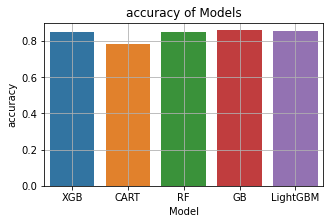

accuracy : {'XGB': 0.8472, 'CART': 0.7832000000000001, 'RF': 0.8497, 'GB': 0.8576, 'LightGBM': 0.8553000000000001}
-----------


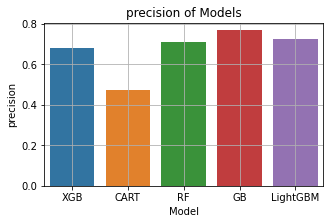

precision : {'XGB': 0.6804726359641614, 'CART': 0.4704611392805532, 'RF': 0.7101759672438248, 'GB': 0.7663871422694951, 'LightGBM': 0.7241013447080762}
-----------


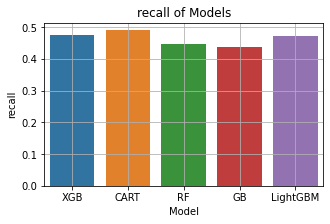

recall : {'XGB': 0.47502756603864044, 'CART': 0.4892180833213481, 'RF': 0.4471211467472075, 'GB': 0.43634642120907047, 'LightGBM': 0.4716009875832974}
-----------


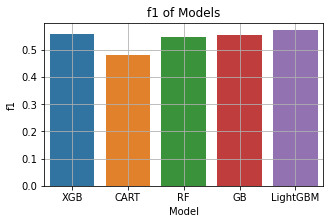

f1 : {'XGB': 0.5591860197263333, 'CART': 0.4794096320240331, 'RF': 0.5481899531741135, 'GB': 0.5558085459821003, 'LightGBM': 0.570892592573224}
-----------


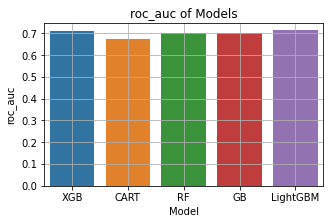

roc_auc : {'XGB': 0.7088633024581232, 'CART': 0.673925761968688, 'RF': 0.7000626232205759, 'GB': 0.7010206659832515, 'LightGBM': 0.7126794280607315}
-----------


In [226]:
# barplot for accuracy
for metric,name in zip([accuracy, precision, recall, f1, roc_auc],['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    plt.figure(figsize=(5,3))
    plt.title(f"{name} of Models")
    plt.xlabel("Model")
    plt.ylabel(f"{name}")
    sns.barplot(x=list(metric.keys()), y=list(metric.values()))
    plt.grid()
    plt.show()
    print(f'{name} : {metric}')
    print('-----------')

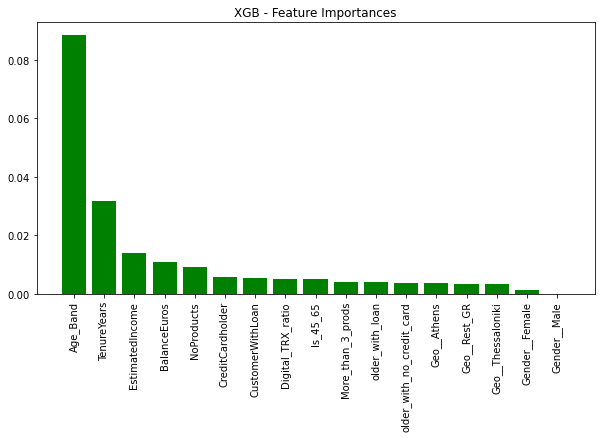

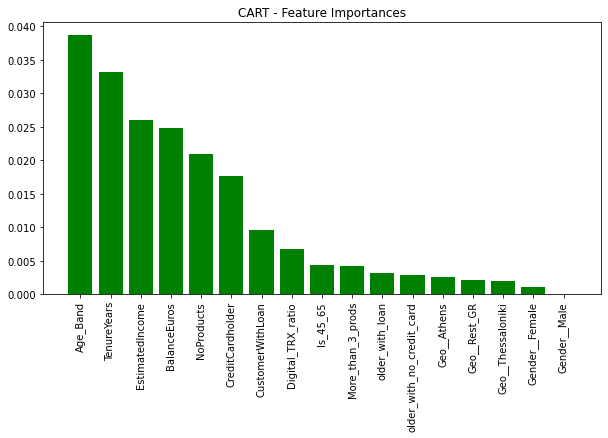

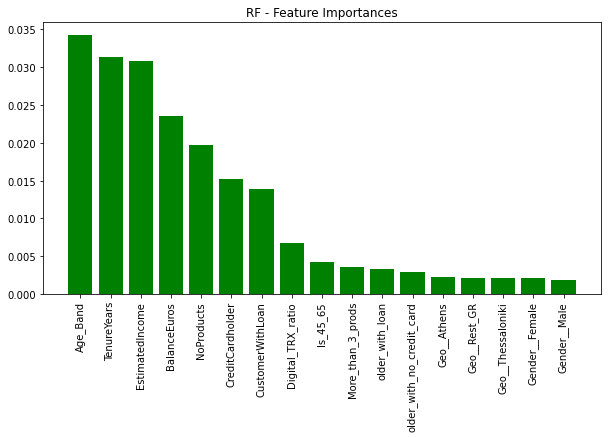

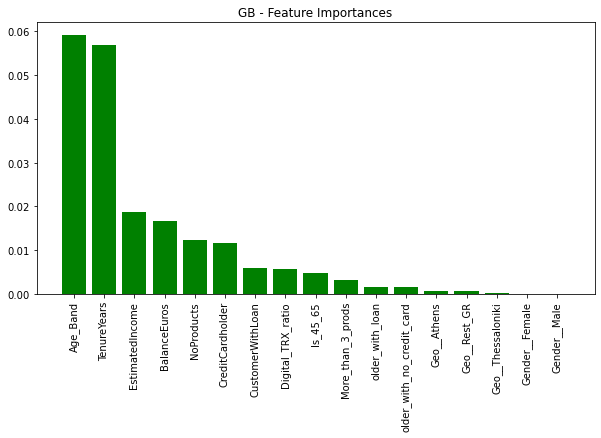

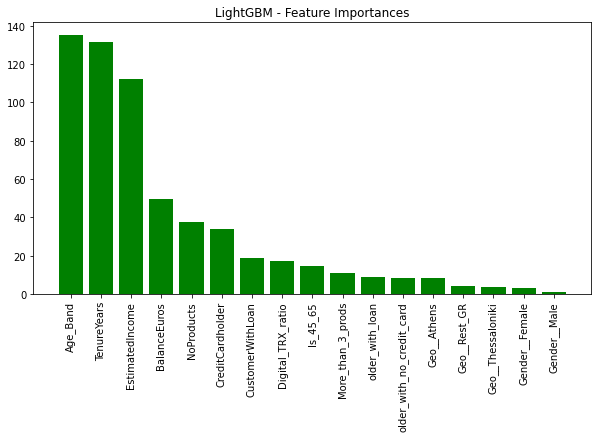

In [227]:
for model, feat_imp in feature_importances.items():
    plt.figure(figsize=(10, 5))
    plt.title(f'{model} - Feature Importances')
    plt.bar(range(len(features_label)), feat_imp.values(), color = "green", align = "center")
    plt.xticks(range(len(features_label)), feat_imp.keys(), rotation = 90)
    plt.show()

In [228]:
# mean and standard deviation of the results
for name, values in results.items():
    print('>%s %.3f (%.3f)' % (name, np.mean(values), np.std(values)))

>XGB 0.847 (0.002)
>CART 0.783 (0.006)
>RF 0.850 (0.002)
>GB 0.858 (0.006)
>LightGBM 0.855 (0.004)


### By removing Gender and Geography which have low feature importance, all metrics were reduced !!!

### Add more features - Feature engineering

In [229]:
df.columns

Index(['Age_Band', 'TenureYears', 'EstimatedIncome', 'BalanceEuros',
       'NoProducts', 'CreditCardholder', 'CustomerWithLoan',
       'Digital_TRX_ratio', 'Is_45_65', 'More_than_3_prods', 'older_with_loan',
       'older_with_no_credit_card', 'Geo__Athens', 'Geo__Rest_GR',
       'Geo__Thessaloniki', 'Gender__Female', 'Gender__Male', 'Inactive'],
      dtype='object')

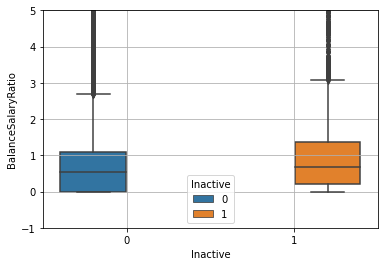

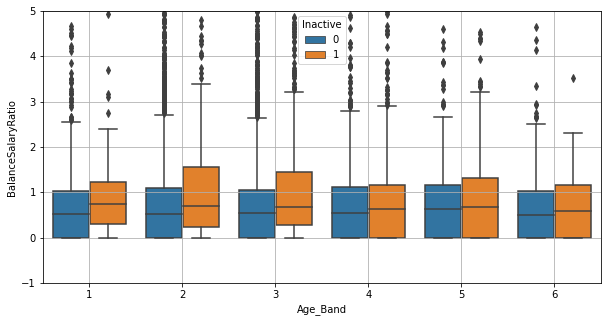

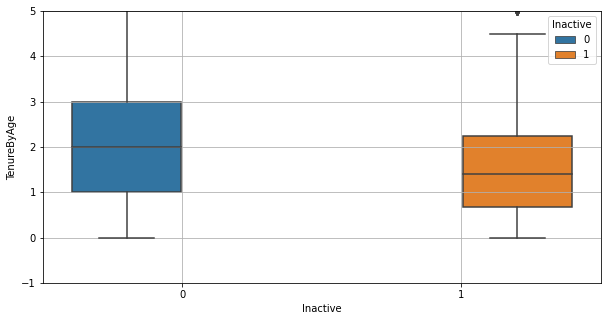

In [230]:
# 1st Attribute - Balance Salary Ratio
df['BalanceSalaryRatio'] = df.BalanceEuros/df.EstimatedIncome
sns.boxplot(y='BalanceSalaryRatio',x = 'Inactive', hue = 'Inactive',data = df)
plt.ylim(-1, 5)
plt.grid()

plt.figure(figsize=(10, 5))
sns.boxplot(y='BalanceSalaryRatio',x = 'Age_Band', hue = 'Inactive',data = df)
plt.ylim(-1, 5)
plt.grid()

plt.figure(figsize=(10, 5))
df['TenureByAge'] = df.TenureYears/(df.Age_Band)

df.dropna(inplace=True)
# drop infinite values
df = df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)

sns.boxplot(y='TenureByAge',x = 'Inactive', hue = 'Inactive',data = df)
plt.ylim(-1, 5)
plt.grid()

### Inactive customers have slightly larger Balance to Salary ratio

In [231]:
X = df.drop(['Inactive'], axis=1)
X.columns

Index(['Age_Band', 'TenureYears', 'EstimatedIncome', 'BalanceEuros',
       'NoProducts', 'CreditCardholder', 'CustomerWithLoan',
       'Digital_TRX_ratio', 'Is_45_65', 'More_than_3_prods', 'older_with_loan',
       'older_with_no_credit_card', 'Geo__Athens', 'Geo__Rest_GR',
       'Geo__Thessaloniki', 'Gender__Female', 'Gender__Male',
       'BalanceSalaryRatio', 'TenureByAge'],
      dtype='object')

In [232]:
X = df.drop(['Inactive'], axis=1)
# index of categorical features in X
categorical_features = [0,1,4,5,6,8,9,10,11,12]
# index of numerical features in X
numerical_features = [2,3,7,13,14]

features_label = X.columns
X = X.values
y = df['Inactive'].values

print(X.shape, y.shape)

(10000, 19) (10000,)


In [233]:
from sklearn.model_selection import StratifiedKFold

to_print_shapes = False

# Models for Classification
models = [('XGB' ,XGBClassifier(random_state=123456)),
          ('CART', DecisionTreeClassifier(random_state=123456)),
          ('RF', RandomForestClassifier(random_state=123456)),
          ('GB', GradientBoostingClassifier(random_state = 12345)),
          ("LightGBM", LGBMClassifier(random_state=123456))]

results = {}
accuracy = {}
precision = {}
recall = {}
f1 = {}
roc_auc = {}

feature_importances = {}

# enumerate the splits and summarize the distributions
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    results_per_model = []
    feature_importance_per_model = {}
    acc_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    roc_auc_per_fold = []
    for train_ix, test_ix in kfold.split(X, y):
        # select rows
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        # print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
        if to_print_shapes:
            # print the number of unique label values
            train_unique, train_counts = np.unique(train_y, return_counts=True)
            test_unique, test_counts = np.unique(test_y, return_counts=True)
            # print('Train: ', train_unique, train_counts)
            # print('Test: ', test_unique, test_counts)

        model.fit(train_X, train_y)
        results_per_model.append(model.score(test_X, test_y))

        y_pred = model.predict(test_X)

        # f-1 score, precision, recall, accuracy, roc_auc
        acc_per_fold.append(accuracy_score(test_y, y_pred))
        precision_per_fold.append(precision_score(test_y, y_pred))
        recall_per_fold.append(recall_score(test_y, y_pred))
        f1_per_fold.append(f1_score(test_y, y_pred))
        roc_auc_per_fold.append(roc_auc_score(test_y, y_pred))

        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        for i,column in zip(range(X.shape[1]), features_label):
            feature_importance_per_model[column] = importances[indices[i]]

        # print(classification_report(test_y,  model.predict(test_X)))

    # mean value of feature_importance_per_model
    feature_importance_per_model = {k: v / 5 for k, v in feature_importance_per_model.items()}
    # print(feature_importance_per_model)

    feature_importances[name] = feature_importance_per_model
    
    results[name] = results_per_model
    # print('>%s %.3f (%.3f)' % (name, np.mean(results_per_model), np.std(results_per_model)))

    accuracy[name] = np.mean(acc_per_fold)
    precision[name] = np.mean(precision_per_fold)
    recall[name] = np.mean(recall_per_fold)
    f1[name] = np.mean(f1_per_fold)
    roc_auc[name] = np.mean(roc_auc_per_fold)
    # print('>%s %.3f (%.3f)' % (name, np.mean(acc_per_fold), np.std(acc_per_fold)))
    # print('>%s %.3f (%.3f)' % (name, np.mean(precision_per_fold), np.std(precision_per_fold)))
    # print('>%s %.3f (%.3f)' % (name, np.mean(recall_per_fold), np.std(recall_per_fold)))
    # print('>%s %.3f (%.3f)' % (name, np.mean(f1_per_fold), np.std(f1_per_fold)))
    # print('>%s %.3f (%.3f)' % (name, np.mean(roc_auc_per_fold), np.std(roc_auc_per_fold)))

In [234]:
results

{'XGB': [0.8385, 0.85, 0.853, 0.856, 0.85],
 'CART': [0.7705, 0.782, 0.79, 0.7855, 0.793],
 'RF': [0.8415, 0.8475, 0.8525, 0.852, 0.855],
 'GB': [0.849, 0.8645, 0.86, 0.855, 0.8625],
 'LightGBM': [0.844, 0.852, 0.856, 0.8575, 0.8555]}

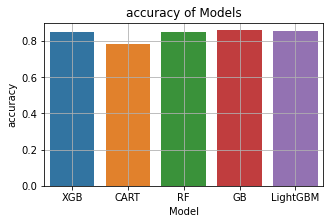

accuracy : {'XGB': 0.8494999999999999, 'CART': 0.7842, 'RF': 0.8497, 'GB': 0.8582000000000001, 'LightGBM': 0.853}
-----------


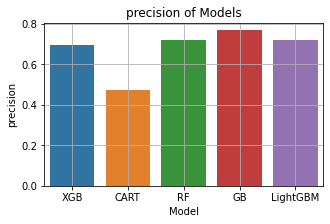

precision : {'XGB': 0.6922706961498621, 'CART': 0.4726311727635257, 'RF': 0.716569547031502, 'GB': 0.7659551451374007, 'LightGBM': 0.7181397431704015}
-----------


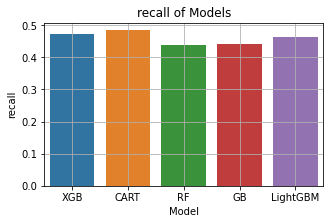

recall : {'XGB': 0.47403279160074785, 'CART': 0.483834316122537, 'RF': 0.4387914089841315, 'GB': 0.4407462006807613, 'LightGBM': 0.462788244882305}
-----------


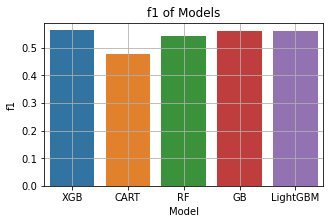

f1 : {'XGB': 0.5626508507639582, 'CART': 0.4780797719820008, 'RF': 0.5438520536440417, 'GB': 0.5592833314135455, 'LightGBM': 0.562456453036997}
-----------


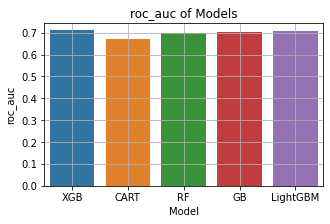

roc_auc : {'XGB': 0.7099368986919531, 'CART': 0.6725536450215255, 'RF': 0.6969662647098738, 'GB': 0.7030322319506633, 'LightGBM': 0.7079593811672152}
-----------


In [235]:
for metric,name in zip([accuracy, precision, recall, f1, roc_auc],['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    plt.figure(figsize=(5,3))
    plt.title(f"{name} of Models")
    plt.xlabel("Model")
    plt.ylabel(f"{name}")
    sns.barplot(x=list(metric.keys()), y=list(metric.values()))
    plt.grid()
    plt.show()
    print(f'{name} : {metric}')
    print('-----------')

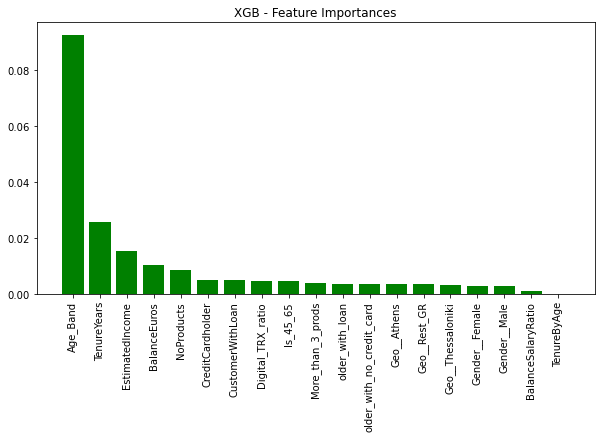

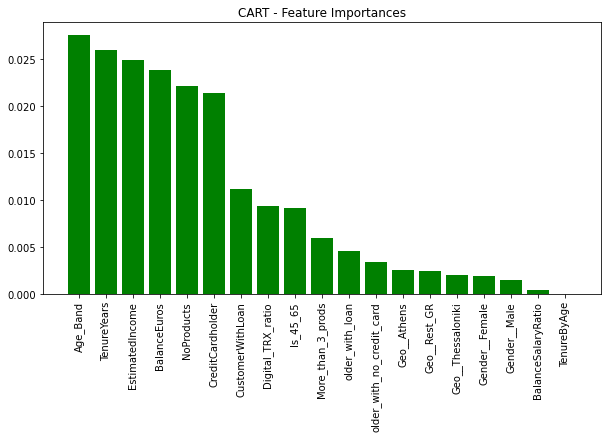

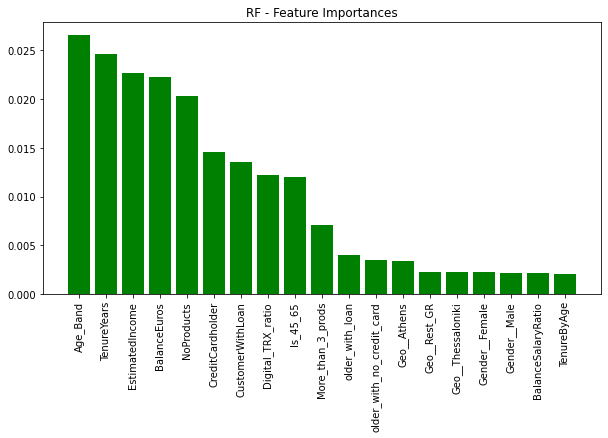

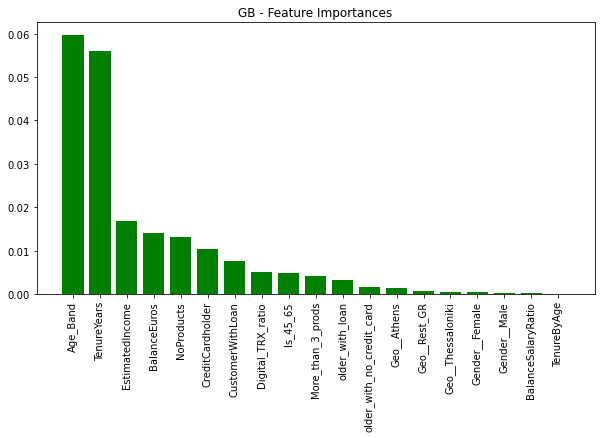

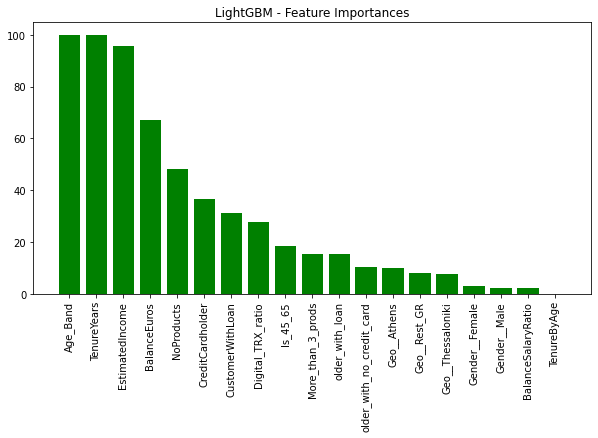

In [236]:
for model, feat_imp in feature_importances.items():
    plt.figure(figsize=(10, 5))
    plt.title(f'{model} - Feature Importances')
    plt.bar(range(len(features_label)), feat_imp.values(), color = "green", align = "center")
    plt.xticks(range(len(features_label)), feat_imp.keys(), rotation = 90)
    plt.show()

In [237]:
# mean and standard deviation of the results
for name, values in results.items():
    print('>%s %.3f (%.3f)' % (name, np.mean(values), np.std(values)))

>XGB 0.849 (0.006)
>CART 0.784 (0.008)
>RF 0.850 (0.005)
>GB 0.858 (0.006)
>LightGBM 0.853 (0.005)


In [238]:
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)
print('ROC_AUC: ', roc_auc)

Accuracy:  {'XGB': 0.8494999999999999, 'CART': 0.7842, 'RF': 0.8497, 'GB': 0.8582000000000001, 'LightGBM': 0.853}
Precision:  {'XGB': 0.6922706961498621, 'CART': 0.4726311727635257, 'RF': 0.716569547031502, 'GB': 0.7659551451374007, 'LightGBM': 0.7181397431704015}
Recall:  {'XGB': 0.47403279160074785, 'CART': 0.483834316122537, 'RF': 0.4387914089841315, 'GB': 0.4407462006807613, 'LightGBM': 0.462788244882305}
F1:  {'XGB': 0.5626508507639582, 'CART': 0.4780797719820008, 'RF': 0.5438520536440417, 'GB': 0.5592833314135455, 'LightGBM': 0.562456453036997}
ROC_AUC:  {'XGB': 0.7099368986919531, 'CART': 0.6725536450215255, 'RF': 0.6969662647098738, 'GB': 0.7030322319506633, 'LightGBM': 0.7079593811672152}


### Optuna optimization of LightGBM algorithm (Best model)

In [239]:
import optuna
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    """
    Objective function to be minimized.
    """
    params = {
    'objective': 'binary',
    'metric': 'auc', 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'random_state': 42,
    'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
    'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
    'subsample_freq': trial.suggest_loguniform('subsample_freq', 0.4, 1.0),
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
    'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
    'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 5, 256),
    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    }

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    f1_scores = []
    roc_auc_scores = []
    for train_ix, test_ix in kfold.split(X, y):
        # select rows
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        # print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
        # if to_print_shapes:
            # print the number of unique label values
            # train_unique, train_counts = np.unique(train_y, return_counts=True)
            # test_unique, test_counts = np.unique(test_y, return_counts=True)
            # print('Train: ', train_unique, train_counts)
            # print('Test: ', test_unique, test_counts)

        gbm = LGBMClassifier(**params)
        gbm.fit(train_X,train_y)
        preds = gbm.predict(test_X)
        f1 = f1_score(test_y, preds)
        f1_scores.append(f1)
        roc_auc = roc_auc_score(test_y, preds)
        roc_auc_scores.append(roc_auc)

    
    f1_scores = np.mean(f1_scores)  
    roc_auc_scores = np.mean(roc_auc_scores)   

    return roc_auc_scores

In [240]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

[I 2023-09-08 17:12:11,209] A new study created in memory with name: no-name-dc800f5f-5afb-4b50-8c02-21a63fc6acea
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

[LightGBM] [Warning] bagging_fraction is set=0.5503693883858065, subsample=0.5045876595435617 will be ignored. Current value: bagging_fraction=0.5503693883858065
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.43095707240970627 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5503693883858065, subsample=0.5045876595435617 will be ignored. Current value: bagging_fraction=0.5503693883858065
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.43095707240970627 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5503693883858065, subsample=0.5045876595435617 will be ignored. Current value: bagging_fraction=0.5503693883858065
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.43095707240970627 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5503693883858065, subsample=0.5045876595435617 will be ignored. Current value: bagging_fr

[I 2023-09-08 17:12:14,963] Trial 0 finished with value: 0.7055729711111731 and parameters: {'learning_rate': 0.006, 'subsample': 0.5045876595435617, 'subsample_freq': 0.43095707240970627, 'colsample_bytree': 0.7035025782663584, 'reg_alpha': 4.848529658981298, 'reg_lambda': 0.5113432285125671, 'min_child_weight': 11, 'min_child_samples': 20, 'bagging_fraction': 0.5503693883858065, 'bagging_freq': 3}. Best is trial 0 with value: 0.7055729711111731.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inste

[LightGBM] [Warning] bagging_fraction is set=0.5635869928727701, subsample=0.41747551190462456 will be ignored. Current value: bagging_fraction=0.5635869928727701
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.9606575549875994 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5635869928727701, subsample=0.41747551190462456 will be ignored. Current value: bagging_fraction=0.5635869928727701
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.9606575549875994 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5635869928727701, subsample=0.41747551190462456 will be ignored. Current value: bagging_fraction=0.5635869928727701
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.9606575549875994 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5635869928727701, subsample=0.41747551190462456 will be ignored. Current value: bagging_f

[I 2023-09-08 17:12:16,168] Trial 1 finished with value: 0.6378544532403 and parameters: {'learning_rate': 0.008, 'subsample': 0.41747551190462456, 'subsample_freq': 0.9606575549875994, 'colsample_bytree': 0.8550440785090706, 'reg_alpha': 0.1473752760005805, 'reg_lambda': 1.905430566845331, 'min_child_weight': 177, 'min_child_samples': 90, 'bagging_fraction': 0.5635869928727701, 'bagging_freq': 7}. Best is trial 0 with value: 0.7055729711111731.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead

[LightGBM] [Warning] bagging_fraction is set=0.5509981272047314, subsample=0.4101449119828131 will be ignored. Current value: bagging_fraction=0.5509981272047314
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.9986428807294467 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5509981272047314, subsample=0.4101449119828131 will be ignored. Current value: bagging_fraction=0.5509981272047314
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.9986428807294467 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5509981272047314, subsample=0.4101449119828131 will be ignored. Current value: bagging_fraction=0.5509981272047314
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.9986428807294467 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5509981272047314, subsample=0.4101449119828131 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:12:17,419] Trial 2 finished with value: 0.5541456343710129 and parameters: {'learning_rate': 0.014, 'subsample': 0.4101449119828131, 'subsample_freq': 0.9986428807294467, 'colsample_bytree': 0.6762392932569872, 'reg_alpha': 1.307344743774181, 'reg_lambda': 4.472165605093271, 'min_child_weight': 211, 'min_child_samples': 44, 'bagging_fraction': 0.5509981272047314, 'bagging_freq': 2}. Best is trial 0 with value: 0.7055729711111731.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instea

[LightGBM] [Warning] bagging_fraction is set=0.8850759266267865, subsample=0.9230469933039577 will be ignored. Current value: bagging_fraction=0.8850759266267865
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.8802100289731967 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8850759266267865, subsample=0.9230469933039577 will be ignored. Current value: bagging_fraction=0.8850759266267865
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.8802100289731967 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8850759266267865, subsample=0.9230469933039577 will be ignored. Current value: bagging_fraction=0.8850759266267865
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.8802100289731967 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8850759266267865, subsample=0.9230469933039577 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:12:19,922] Trial 3 finished with value: 0.6613707298153622 and parameters: {'learning_rate': 0.014, 'subsample': 0.9230469933039577, 'subsample_freq': 0.8802100289731967, 'colsample_bytree': 0.5517058968847735, 'reg_alpha': 0.016852230731106314, 'reg_lambda': 0.9722054824234525, 'min_child_weight': 78, 'min_child_samples': 51, 'bagging_fraction': 0.8850759266267865, 'bagging_freq': 4}. Best is trial 0 with value: 0.7055729711111731.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] bagging_fraction is set=0.41811402051658114, subsample=0.8493519567875627 will be ignored. Current value: bagging_fraction=0.41811402051658114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.758132795242182 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.41811402051658114, subsample=0.8493519567875627 will be ignored. Current value: bagging_fraction=0.41811402051658114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.758132795242182 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.41811402051658114, subsample=0.8493519567875627 will be ignored. Current value: bagging_fraction=0.41811402051658114
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.758132795242182 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.41811402051658114, subsample=0.8493519567875627 will be ignored. Current value: bagging_f

[I 2023-09-08 17:12:21,350] Trial 4 finished with value: 0.5219889936837326 and parameters: {'learning_rate': 0.01, 'subsample': 0.8493519567875627, 'subsample_freq': 0.758132795242182, 'colsample_bytree': 0.8562744887610361, 'reg_alpha': 0.6655886919268061, 'reg_lambda': 9.626245418894042, 'min_child_weight': 212, 'min_child_samples': 81, 'bagging_fraction': 0.41811402051658114, 'bagging_freq': 1}. Best is trial 0 with value: 0.7055729711111731.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instea

[LightGBM] [Warning] bagging_fraction is set=0.6504730127570164, subsample=0.9758284091018148 will be ignored. Current value: bagging_fraction=0.6504730127570164
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.9067464949754444 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6504730127570164, subsample=0.9758284091018148 will be ignored. Current value: bagging_fraction=0.6504730127570164
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.9067464949754444 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6504730127570164, subsample=0.9758284091018148 will be ignored. Current value: bagging_fraction=0.6504730127570164
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.9067464949754444 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6504730127570164, subsample=0.9758284091018148 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:12:22,626] Trial 5 finished with value: 0.6421865767124897 and parameters: {'learning_rate': 0.008, 'subsample': 0.9758284091018148, 'subsample_freq': 0.9067464949754444, 'colsample_bytree': 0.7476667086456594, 'reg_alpha': 0.3967311648371904, 'reg_lambda': 0.8727513647399568, 'min_child_weight': 180, 'min_child_samples': 31, 'bagging_fraction': 0.6504730127570164, 'bagging_freq': 6}. Best is trial 0 with value: 0.7055729711111731.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inst

[LightGBM] [Warning] bagging_fraction is set=0.8934743679908959, subsample=0.4813517954629342 will be ignored. Current value: bagging_fraction=0.8934743679908959
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6661096274221793 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8934743679908959, subsample=0.4813517954629342 will be ignored. Current value: bagging_fraction=0.8934743679908959
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6661096274221793 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8934743679908959, subsample=0.4813517954629342 will be ignored. Current value: bagging_fraction=0.8934743679908959
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6661096274221793 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8934743679908959, subsample=0.4813517954629342 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:12:24,117] Trial 6 finished with value: 0.638800141423212 and parameters: {'learning_rate': 0.006, 'subsample': 0.4813517954629342, 'subsample_freq': 0.6661096274221793, 'colsample_bytree': 0.6804789359430772, 'reg_alpha': 0.001855231980475975, 'reg_lambda': 0.005355004608157483, 'min_child_weight': 191, 'min_child_samples': 7, 'bagging_fraction': 0.8934743679908959, 'bagging_freq': 5}. Best is trial 0 with value: 0.7055729711111731.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.547457031611971, subsample=0.49119929888011526 will be ignored. Current value: bagging_fraction=0.547457031611971
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6512586638263494 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.547457031611971, subsample=0.49119929888011526 will be ignored. Current value: bagging_fraction=0.547457031611971
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6512586638263494 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.547457031611971, subsample=0.49119929888011526 will be ignored. Current value: bagging_fraction=0.547457031611971
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6512586638263494 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.547457031611971, subsample=0.49119929888011526 will be ignored. Current value: bagging_fraction

[I 2023-09-08 17:12:28,592] Trial 7 finished with value: 0.714301871430399 and parameters: {'learning_rate': 0.014, 'subsample': 0.49119929888011526, 'subsample_freq': 0.6512586638263494, 'colsample_bytree': 0.9252693919063483, 'reg_alpha': 0.24828711335507347, 'reg_lambda': 0.22629542640007538, 'min_child_weight': 12, 'min_child_samples': 36, 'bagging_fraction': 0.547457031611971, 'bagging_freq': 1}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inste

[LightGBM] [Warning] bagging_fraction is set=0.7557764990444695, subsample=0.797091115334038 will be ignored. Current value: bagging_fraction=0.7557764990444695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.4470702656688032 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7557764990444695, subsample=0.797091115334038 will be ignored. Current value: bagging_fraction=0.7557764990444695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.4470702656688032 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7557764990444695, subsample=0.797091115334038 will be ignored. Current value: bagging_fraction=0.7557764990444695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.4470702656688032 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7557764990444695, subsample=0.797091115334038 will be ignored. Current value: bagging_fraction=

[I 2023-09-08 17:12:32,447] Trial 8 finished with value: 0.7093982610443602 and parameters: {'learning_rate': 0.008, 'subsample': 0.797091115334038, 'subsample_freq': 0.4470702656688032, 'colsample_bytree': 0.4818554131350238, 'reg_alpha': 0.007651590424733371, 'reg_lambda': 0.18220759945850837, 'min_child_weight': 28, 'min_child_samples': 27, 'bagging_fraction': 0.7557764990444695, 'bagging_freq': 1}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inst

[LightGBM] [Warning] bagging_fraction is set=0.5312701345944665, subsample=0.6372289068747831 will be ignored. Current value: bagging_fraction=0.5312701345944665
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6441288130391072 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5312701345944665, subsample=0.6372289068747831 will be ignored. Current value: bagging_fraction=0.5312701345944665
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6441288130391072 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5312701345944665, subsample=0.6372289068747831 will be ignored. Current value: bagging_fraction=0.5312701345944665
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6441288130391072 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5312701345944665, subsample=0.6372289068747831 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:12:33,407] Trial 9 finished with value: 0.5196162191166058 and parameters: {'learning_rate': 0.008, 'subsample': 0.6372289068747831, 'subsample_freq': 0.6441288130391072, 'colsample_bytree': 0.8678930178423094, 'reg_alpha': 4.830184530045328, 'reg_lambda': 0.06625258962851298, 'min_child_weight': 228, 'min_child_samples': 15, 'bagging_fraction': 0.5312701345944665, 'bagging_freq': 6}. Best is trial 7 with value: 0.714301871430399.


[LightGBM] [Warning] bagging_fraction is set=0.5312701345944665, subsample=0.6372289068747831 will be ignored. Current value: bagging_fraction=0.5312701345944665
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6441288130391072 will be ignored. Current value: bagging_freq=6


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be 

[LightGBM] [Warning] bagging_fraction is set=0.40307543945997293, subsample=0.6078855126343624 will be ignored. Current value: bagging_fraction=0.40307543945997293
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.5469121624287641 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.40307543945997293, subsample=0.6078855126343624 will be ignored. Current value: bagging_fraction=0.40307543945997293
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.5469121624287641 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.40307543945997293, subsample=0.6078855126343624 will be ignored. Current value: bagging_fraction=0.40307543945997293
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.5469121624287641 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.40307543945997293, subsample=0.6078855126343624 will be ignored. Current value: baggin

[I 2023-09-08 17:12:34,677] Trial 10 finished with value: 0.6584431078334496 and parameters: {'learning_rate': 0.017, 'subsample': 0.6078855126343624, 'subsample_freq': 0.5469121624287641, 'colsample_bytree': 0.9865975321783513, 'reg_alpha': 0.04996498831753527, 'reg_lambda': 0.03299934861712575, 'min_child_weight': 107, 'min_child_samples': 69, 'bagging_fraction': 0.40307543945997293, 'bagging_freq': 3}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.7703581939764116, subsample=0.7411616283337653 will be ignored. Current value: bagging_fraction=0.7703581939764116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5259007634610228 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7703581939764116, subsample=0.7411616283337653 will be ignored. Current value: bagging_fraction=0.7703581939764116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5259007634610228 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7703581939764116, subsample=0.7411616283337653 will be ignored. Current value: bagging_fraction=0.7703581939764116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5259007634610228 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7703581939764116, subsample=0.7411616283337653 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:12:39,647] Trial 11 finished with value: 0.7140740495943382 and parameters: {'learning_rate': 0.02, 'subsample': 0.7411616283337653, 'subsample_freq': 0.5259007634610228, 'colsample_bytree': 0.40712073554687306, 'reg_alpha': 0.00846560088872858, 'reg_lambda': 0.17904741380048889, 'min_child_weight': 13, 'min_child_samples': 34, 'bagging_fraction': 0.7703581939764116, 'bagging_freq': 1}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] bagging_fraction is set=0.7402285538191656, subsample=0.7218013319658225 will be ignored. Current value: bagging_fraction=0.7402285538191656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5458638367207496 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7402285538191656, subsample=0.7218013319658225 will be ignored. Current value: bagging_fraction=0.7402285538191656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5458638367207496 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7402285538191656, subsample=0.7218013319658225 will be ignored. Current value: bagging_fraction=0.7402285538191656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5458638367207496 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7402285538191656, subsample=0.7218013319658225 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:12:43,187] Trial 12 finished with value: 0.6655459129431833 and parameters: {'learning_rate': 0.02, 'subsample': 0.7218013319658225, 'subsample_freq': 0.5458638367207496, 'colsample_bytree': 0.41359252621472653, 'reg_alpha': 0.0295992695459112, 'reg_lambda': 0.15612880611204036, 'min_child_weight': 55, 'min_child_samples': 38, 'bagging_fraction': 0.7402285538191656, 'bagging_freq': 1}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inst

[LightGBM] [Warning] bagging_fraction is set=0.8111859303071886, subsample=0.613889694597412 will be ignored. Current value: bagging_fraction=0.8111859303071886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5376004340020153 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8111859303071886, subsample=0.613889694597412 will be ignored. Current value: bagging_fraction=0.8111859303071886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5376004340020153 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8111859303071886, subsample=0.613889694597412 will be ignored. Current value: bagging_fraction=0.8111859303071886
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5376004340020153 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.8111859303071886, subsample=0.613889694597412 will be ignored. Current value: bagging_fraction=

[I 2023-09-08 17:12:46,827] Trial 13 finished with value: 0.6672332127551748 and parameters: {'learning_rate': 0.02, 'subsample': 0.613889694597412, 'subsample_freq': 0.5376004340020153, 'colsample_bytree': 0.5529796809611958, 'reg_alpha': 0.0979122880272201, 'reg_lambda': 0.01860746486128087, 'min_child_weight': 53, 'min_child_samples': 59, 'bagging_fraction': 0.8111859303071886, 'bagging_freq': 2}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instea

[LightGBM] [Warning] bagging_fraction is set=0.9980083456850148, subsample=0.717864024420682 will be ignored. Current value: bagging_fraction=0.9980083456850148
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7322137549116461 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9980083456850148, subsample=0.717864024420682 will be ignored. Current value: bagging_fraction=0.9980083456850148
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7322137549116461 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9980083456850148, subsample=0.717864024420682 will be ignored. Current value: bagging_fraction=0.9980083456850148
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.7322137549116461 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9980083456850148, subsample=0.717864024420682 will be ignored. Current value: bagging_fraction=

[I 2023-09-08 17:12:49,547] Trial 14 finished with value: 0.6633260418119538 and parameters: {'learning_rate': 0.02, 'subsample': 0.717864024420682, 'subsample_freq': 0.7322137549116461, 'colsample_bytree': 0.4015010433127252, 'reg_alpha': 0.005361976181369457, 'reg_lambda': 0.001417364095948283, 'min_child_weight': 133, 'min_child_samples': 63, 'bagging_fraction': 0.9980083456850148, 'bagging_freq': 2}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.6129401771545192, subsample=0.5505784704267059 will be ignored. Current value: bagging_fraction=0.6129401771545192
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.4903772735794642 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6129401771545192, subsample=0.5505784704267059 will be ignored. Current value: bagging_fraction=0.6129401771545192
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.4903772735794642 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6129401771545192, subsample=0.5505784704267059 will be ignored. Current value: bagging_fraction=0.6129401771545192
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.4903772735794642 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6129401771545192, subsample=0.5505784704267059 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:12:55,192] Trial 15 finished with value: 0.7131037347985154 and parameters: {'learning_rate': 0.014, 'subsample': 0.5505784704267059, 'subsample_freq': 0.4903772735794642, 'colsample_bytree': 0.6045985559603464, 'reg_alpha': 0.001586594838935515, 'reg_lambda': 0.3021836863064401, 'min_child_weight': 5, 'min_child_samples': 40, 'bagging_fraction': 0.6129401771545192, 'bagging_freq': 3}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inst

[LightGBM] [Warning] bagging_fraction is set=0.6827386559828877, subsample=0.4660440794290829 will be ignored. Current value: bagging_fraction=0.6827386559828877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6086543337163958 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6827386559828877, subsample=0.4660440794290829 will be ignored. Current value: bagging_fraction=0.6827386559828877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6086543337163958 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6827386559828877, subsample=0.4660440794290829 will be ignored. Current value: bagging_fraction=0.6827386559828877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6086543337163958 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6827386559828877, subsample=0.4660440794290829 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:12:57,547] Trial 16 finished with value: 0.6600972970036485 and parameters: {'learning_rate': 0.01, 'subsample': 0.4660440794290829, 'subsample_freq': 0.6086543337163958, 'colsample_bytree': 0.9935263115257347, 'reg_alpha': 0.09706157017597898, 'reg_lambda': 0.08063529980600738, 'min_child_weight': 105, 'min_child_samples': 51, 'bagging_fraction': 0.6827386559828877, 'bagging_freq': 1}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] bagging_fraction is set=0.7074231720704379, subsample=0.5335108675415554 will be ignored. Current value: bagging_fraction=0.7074231720704379
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.4811142644868937 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7074231720704379, subsample=0.5335108675415554 will be ignored. Current value: bagging_fraction=0.7074231720704379
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.4811142644868937 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7074231720704379, subsample=0.5335108675415554 will be ignored. Current value: bagging_fraction=0.7074231720704379
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.4811142644868937 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7074231720704379, subsample=0.5335108675415554 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:13:01,337] Trial 17 finished with value: 0.6643764003518079 and parameters: {'learning_rate': 0.017, 'subsample': 0.5335108675415554, 'subsample_freq': 0.4811142644868937, 'colsample_bytree': 0.4948407185496203, 'reg_alpha': 0.01481996335529924, 'reg_lambda': 0.4378282680881924, 'min_child_weight': 43, 'min_child_samples': 29, 'bagging_fraction': 0.7074231720704379, 'bagging_freq': 4}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inst

[LightGBM] [Warning] bagging_fraction is set=0.6212666045836691, subsample=0.7037501281072396 will be ignored. Current value: bagging_fraction=0.6212666045836691
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5913544578991934 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6212666045836691, subsample=0.7037501281072396 will be ignored. Current value: bagging_fraction=0.6212666045836691
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5913544578991934 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6212666045836691, subsample=0.7037501281072396 will be ignored. Current value: bagging_fraction=0.6212666045836691
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5913544578991934 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6212666045836691, subsample=0.7037501281072396 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:13:04,208] Trial 18 finished with value: 0.662650360350141 and parameters: {'learning_rate': 0.014, 'subsample': 0.7037501281072396, 'subsample_freq': 0.5913544578991934, 'colsample_bytree': 0.776371223945967, 'reg_alpha': 0.001001439113064009, 'reg_lambda': 0.16388416756400837, 'min_child_weight': 87, 'min_child_samples': 73, 'bagging_fraction': 0.6212666045836691, 'bagging_freq': 2}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inst

[LightGBM] [Warning] bagging_fraction is set=0.49141607438507984, subsample=0.5634803920773229 will be ignored. Current value: bagging_fraction=0.49141607438507984
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.4097275099187929 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.49141607438507984, subsample=0.5634803920773229 will be ignored. Current value: bagging_fraction=0.49141607438507984
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.4097275099187929 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.49141607438507984, subsample=0.5634803920773229 will be ignored. Current value: bagging_fraction=0.49141607438507984
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.4097275099187929 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.49141607438507984, subsample=0.5634803920773229 will be ignored. Current value: baggin

[I 2023-09-08 17:13:05,787] Trial 19 finished with value: 0.6536108765468842 and parameters: {'learning_rate': 0.02, 'subsample': 0.5634803920773229, 'subsample_freq': 0.4097275099187929, 'colsample_bytree': 0.6347591050096031, 'reg_alpha': 0.19786447818690056, 'reg_lambda': 0.03549040739767154, 'min_child_weight': 145, 'min_child_samples': 16, 'bagging_fraction': 0.49141607438507984, 'bagging_freq': 4}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.6313035220482885, subsample=0.4608397682740509 will be ignored. Current value: bagging_fraction=0.6313035220482885
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.6763567663808862 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6313035220482885, subsample=0.4608397682740509 will be ignored. Current value: bagging_fraction=0.6313035220482885
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.6763567663808862 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6313035220482885, subsample=0.4608397682740509 will be ignored. Current value: bagging_fraction=0.6313035220482885
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.6763567663808862 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6313035220482885, subsample=0.4608397682740509 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:13:10,167] Trial 20 finished with value: 0.6949865707269629 and parameters: {'learning_rate': 0.02, 'subsample': 0.4608397682740509, 'subsample_freq': 0.6763567663808862, 'colsample_bytree': 0.9111276881388554, 'reg_alpha': 0.04037951036712707, 'reg_lambda': 1.514561708522724, 'min_child_weight': 30, 'min_child_samples': 6, 'bagging_fraction': 0.6313035220482885, 'bagging_freq': 3}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead

[LightGBM] [Warning] bagging_fraction is set=0.627034419832685, subsample=0.5545759689560837 will be ignored. Current value: bagging_fraction=0.627034419832685
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5177883959344454 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.627034419832685, subsample=0.5545759689560837 will be ignored. Current value: bagging_fraction=0.627034419832685
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5177883959344454 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.627034419832685, subsample=0.5545759689560837 will be ignored. Current value: bagging_fraction=0.627034419832685
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5177883959344454 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.627034419832685, subsample=0.5545759689560837 will be ignored. Current value: bagging_fraction=0.6

[I 2023-09-08 17:13:17,143] Trial 21 finished with value: 0.7136465886245109 and parameters: {'learning_rate': 0.014, 'subsample': 0.5545759689560837, 'subsample_freq': 0.5177883959344454, 'colsample_bytree': 0.6103237510274377, 'reg_alpha': 0.003911733369729498, 'reg_lambda': 0.3453332955897088, 'min_child_weight': 7, 'min_child_samples': 40, 'bagging_fraction': 0.627034419832685, 'bagging_freq': 2}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inste

[LightGBM] [Warning] bagging_fraction is set=0.7019963089102765, subsample=0.5766451431411431 will be ignored. Current value: bagging_fraction=0.7019963089102765
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5002389241184669 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7019963089102765, subsample=0.5766451431411431 will be ignored. Current value: bagging_fraction=0.7019963089102765
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5002389241184669 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7019963089102765, subsample=0.5766451431411431 will be ignored. Current value: bagging_fraction=0.7019963089102765
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5002389241184669 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7019963089102765, subsample=0.5766451431411431 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:13:20,013] Trial 22 finished with value: 0.6637353509507994 and parameters: {'learning_rate': 0.014, 'subsample': 0.5766451431411431, 'subsample_freq': 0.5002389241184669, 'colsample_bytree': 0.764229198887599, 'reg_alpha': 0.0038562863010970045, 'reg_lambda': 0.2887224041137467, 'min_child_weight': 73, 'min_child_samples': 36, 'bagging_fraction': 0.7019963089102765, 'bagging_freq': 1}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] bagging_fraction is set=0.5943735886202721, subsample=0.5244606191931989 will be ignored. Current value: bagging_fraction=0.5943735886202721
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5847683625906162 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5943735886202721, subsample=0.5244606191931989 will be ignored. Current value: bagging_fraction=0.5943735886202721
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5847683625906162 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5943735886202721, subsample=0.5244606191931989 will be ignored. Current value: bagging_fraction=0.5943735886202721
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5847683625906162 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5943735886202721, subsample=0.5244606191931989 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:13:24,532] Trial 23 finished with value: 0.712351952096447 and parameters: {'learning_rate': 0.014, 'subsample': 0.5244606191931989, 'subsample_freq': 0.5847683625906162, 'colsample_bytree': 0.605177727736346, 'reg_alpha': 0.0034138128489903737, 'reg_lambda': 0.09683527856395355, 'min_child_weight': 25, 'min_child_samples': 45, 'bagging_fraction': 0.5943735886202721, 'bagging_freq': 2}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] bagging_fraction is set=0.48092588146297605, subsample=0.6521695964547229 will be ignored. Current value: bagging_fraction=0.48092588146297605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5227721868071793 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.48092588146297605, subsample=0.6521695964547229 will be ignored. Current value: bagging_fraction=0.48092588146297605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5227721868071793 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.48092588146297605, subsample=0.6521695964547229 will be ignored. Current value: bagging_fraction=0.48092588146297605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5227721868071793 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.48092588146297605, subsample=0.6521695964547229 will be ignored. Current value: baggin

[I 2023-09-08 17:13:26,522] Trial 24 finished with value: 0.519847676003798 and parameters: {'learning_rate': 0.014, 'subsample': 0.6521695964547229, 'subsample_freq': 0.5227721868071793, 'colsample_bytree': 0.46090945337456524, 'reg_alpha': 0.012307918570765018, 'reg_lambda': 0.5917465721547533, 'min_child_weight': 254, 'min_child_samples': 24, 'bagging_fraction': 0.48092588146297605, 'bagging_freq': 1}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.6813026522805479, subsample=0.4933108508618038 will be ignored. Current value: bagging_fraction=0.6813026522805479
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.4583439211431558 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6813026522805479, subsample=0.4933108508618038 will be ignored. Current value: bagging_fraction=0.6813026522805479
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.4583439211431558 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6813026522805479, subsample=0.4933108508618038 will be ignored. Current value: bagging_fraction=0.6813026522805479
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.4583439211431558 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6813026522805479, subsample=0.4933108508618038 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:13:32,772] Trial 25 finished with value: 0.7116435391182535 and parameters: {'learning_rate': 0.014, 'subsample': 0.4933108508618038, 'subsample_freq': 0.4583439211431558, 'colsample_bytree': 0.5317913143323308, 'reg_alpha': 0.008017812996163961, 'reg_lambda': 0.2547019981905332, 'min_child_weight': 7, 'min_child_samples': 32, 'bagging_fraction': 0.6813026522805479, 'bagging_freq': 2}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inst

[LightGBM] [Warning] bagging_fraction is set=0.592674799525511, subsample=0.5784692728612627 will be ignored. Current value: bagging_fraction=0.592674799525511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5835554241940165 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.592674799525511, subsample=0.5784692728612627 will be ignored. Current value: bagging_fraction=0.592674799525511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5835554241940165 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.592674799525511, subsample=0.5784692728612627 will be ignored. Current value: bagging_fraction=0.592674799525511
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5835554241940165 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.592674799525511, subsample=0.5784692728612627 will be ignored. Current value: bagging_fraction=0.5

[I 2023-09-08 17:13:36,212] Trial 26 finished with value: 0.6558477003326775 and parameters: {'learning_rate': 0.01, 'subsample': 0.5784692728612627, 'subsample_freq': 0.5835554241940165, 'colsample_bytree': 0.4351407225933588, 'reg_alpha': 0.023790378887144324, 'reg_lambda': 0.5128095454351049, 'min_child_weight': 47, 'min_child_samples': 58, 'bagging_fraction': 0.592674799525511, 'bagging_freq': 1}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inste

[LightGBM] [Warning] bagging_fraction is set=0.6358852261231043, subsample=0.44543484259708305 will be ignored. Current value: bagging_fraction=0.6358852261231043
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5161004824214395 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6358852261231043, subsample=0.44543484259708305 will be ignored. Current value: bagging_fraction=0.6358852261231043
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5161004824214395 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6358852261231043, subsample=0.44543484259708305 will be ignored. Current value: bagging_fraction=0.6358852261231043
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5161004824214395 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.6358852261231043, subsample=0.44543484259708305 will be ignored. Current value: bagging_f

[I 2023-09-08 17:13:39,167] Trial 27 finished with value: 0.659376117155513 and parameters: {'learning_rate': 0.017, 'subsample': 0.44543484259708305, 'subsample_freq': 0.5161004824214395, 'colsample_bytree': 0.4452833821155535, 'reg_alpha': 0.054517851722273115, 'reg_lambda': 0.10497392799117665, 'min_child_weight': 65, 'min_child_samples': 44, 'bagging_fraction': 0.6358852261231043, 'bagging_freq': 2}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.7761023802989857, subsample=0.500030604927746 will be ignored. Current value: bagging_fraction=0.7761023802989857
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.46799588060008285 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7761023802989857, subsample=0.500030604927746 will be ignored. Current value: bagging_fraction=0.7761023802989857
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.46799588060008285 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7761023802989857, subsample=0.500030604927746 will be ignored. Current value: bagging_fraction=0.7761023802989857
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.46799588060008285 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7761023802989857, subsample=0.500030604927746 will be ignored. Current value: bagging_fracti

[I 2023-09-08 17:13:43,662] Trial 28 finished with value: 0.7041572332173107 and parameters: {'learning_rate': 0.006, 'subsample': 0.500030604927746, 'subsample_freq': 0.46799588060008285, 'colsample_bytree': 0.5097202637847386, 'reg_alpha': 0.0030796160600676968, 'reg_lambda': 1.5488581866437552, 'min_child_weight': 33, 'min_child_samples': 52, 'bagging_fraction': 0.7761023802989857, 'bagging_freq': 3}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.6626366564443098, subsample=0.5281148894667053 will be ignored. Current value: bagging_fraction=0.6626366564443098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.43186031093297034 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6626366564443098, subsample=0.5281148894667053 will be ignored. Current value: bagging_fraction=0.6626366564443098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.43186031093297034 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6626366564443098, subsample=0.5281148894667053 will be ignored. Current value: bagging_fraction=0.6626366564443098
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.43186031093297034 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6626366564443098, subsample=0.5281148894667053 will be ignored. Current value: bagging_fr

[I 2023-09-08 17:13:45,962] Trial 29 finished with value: 0.6448837352246597 and parameters: {'learning_rate': 0.006, 'subsample': 0.5281148894667053, 'subsample_freq': 0.43186031093297034, 'colsample_bytree': 0.7206994250557566, 'reg_alpha': 0.009598328548304266, 'reg_lambda': 0.3992893418465799, 'min_child_weight': 105, 'min_child_samples': 21, 'bagging_fraction': 0.6626366564443098, 'bagging_freq': 1}. Best is trial 7 with value: 0.714301871430399.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5748380720023603, subsample=0.4380258500982285 will be ignored. Current value: bagging_fraction=0.5748380720023603
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5594323571996582 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5748380720023603, subsample=0.4380258500982285 will be ignored. Current value: bagging_fraction=0.5748380720023603
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5594323571996582 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5748380720023603, subsample=0.4380258500982285 will be ignored. Current value: bagging_fraction=0.5748380720023603
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5594323571996582 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5748380720023603, subsample=0.4380258500982285 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:13:50,367] Trial 30 finished with value: 0.7157201953811226 and parameters: {'learning_rate': 0.014, 'subsample': 0.4380258500982285, 'subsample_freq': 0.5594323571996582, 'colsample_bytree': 0.578975639426011, 'reg_alpha': 0.024315534480224908, 'reg_lambda': 0.20857490610841578, 'min_child_weight': 21, 'min_child_samples': 36, 'bagging_fraction': 0.5748380720023603, 'bagging_freq': 5}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5817288576362895, subsample=0.4426588842001993 will be ignored. Current value: bagging_fraction=0.5817288576362895
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5630390357392169 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5817288576362895, subsample=0.4426588842001993 will be ignored. Current value: bagging_fraction=0.5817288576362895
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5630390357392169 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5817288576362895, subsample=0.4426588842001993 will be ignored. Current value: bagging_fraction=0.5817288576362895
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5630390357392169 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5817288576362895, subsample=0.4426588842001993 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:13:55,457] Trial 31 finished with value: 0.7143565236747145 and parameters: {'learning_rate': 0.014, 'subsample': 0.4426588842001993, 'subsample_freq': 0.5630390357392169, 'colsample_bytree': 0.5913398065902778, 'reg_alpha': 0.018207281165187, 'reg_lambda': 0.23084390826459159, 'min_child_weight': 18, 'min_child_samples': 34, 'bagging_fraction': 0.5817288576362895, 'bagging_freq': 5}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] bagging_fraction is set=0.5680328868355449, subsample=0.43615736433172686 will be ignored. Current value: bagging_fraction=0.5680328868355449
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5615606877650384 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5680328868355449, subsample=0.43615736433172686 will be ignored. Current value: bagging_fraction=0.5680328868355449
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5615606877650384 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5680328868355449, subsample=0.43615736433172686 will be ignored. Current value: bagging_fraction=0.5680328868355449
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5615606877650384 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5680328868355449, subsample=0.43615736433172686 will be ignored. Current value: bagging_f

[I 2023-09-08 17:13:59,377] Trial 32 finished with value: 0.7151055696854067 and parameters: {'learning_rate': 0.014, 'subsample': 0.43615736433172686, 'subsample_freq': 0.5615606877650384, 'colsample_bytree': 0.5656293218070386, 'reg_alpha': 0.019815021295045317, 'reg_lambda': 0.20102518910796963, 'min_child_weight': 21, 'min_child_samples': 34, 'bagging_fraction': 0.5680328868355449, 'bagging_freq': 5}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

[LightGBM] [Warning] bagging_fraction is set=0.5645366438838072, subsample=0.4311109236269557 will be ignored. Current value: bagging_fraction=0.5645366438838072
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5614448586624161 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5645366438838072, subsample=0.4311109236269557 will be ignored. Current value: bagging_fraction=0.5645366438838072
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5614448586624161 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5645366438838072, subsample=0.4311109236269557 will be ignored. Current value: bagging_fraction=0.5645366438838072
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5614448586624161 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5645366438838072, subsample=0.4311109236269557 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:14:03,976] Trial 33 finished with value: 0.7137562491337536 and parameters: {'learning_rate': 0.014, 'subsample': 0.4311109236269557, 'subsample_freq': 0.5614448586624161, 'colsample_bytree': 0.5683931390506202, 'reg_alpha': 0.02376896748924249, 'reg_lambda': 0.6553461999966896, 'min_child_weight': 20, 'min_child_samples': 17, 'bagging_fraction': 0.5645366438838072, 'bagging_freq': 5}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.5246004520895058, subsample=0.4017370410378377 will be ignored. Current value: bagging_fraction=0.5246004520895058
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6218195601065909 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5246004520895058, subsample=0.4017370410378377 will be ignored. Current value: bagging_fraction=0.5246004520895058
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6218195601065909 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5246004520895058, subsample=0.4017370410378377 will be ignored. Current value: bagging_fraction=0.5246004520895058
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6218195601065909 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5246004520895058, subsample=0.4017370410378377 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:14:07,287] Trial 34 finished with value: 0.6640123527140419 and parameters: {'learning_rate': 0.014, 'subsample': 0.4017370410378377, 'subsample_freq': 0.6218195601065909, 'colsample_bytree': 0.6517448837380599, 'reg_alpha': 0.06404450104060741, 'reg_lambda': 0.9623541691153111, 'min_child_weight': 39, 'min_child_samples': 46, 'bagging_fraction': 0.5246004520895058, 'bagging_freq': 5}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.567032972175055, subsample=0.42640975093330363 will be ignored. Current value: bagging_fraction=0.567032972175055
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6228618847252684 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.567032972175055, subsample=0.42640975093330363 will be ignored. Current value: bagging_fraction=0.567032972175055
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6228618847252684 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.567032972175055, subsample=0.42640975093330363 will be ignored. Current value: bagging_fraction=0.567032972175055
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6228618847252684 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.567032972175055, subsample=0.42640975093330363 will be ignored. Current value: bagging_fraction

[I 2023-09-08 17:14:09,932] Trial 35 finished with value: 0.6613898827653937 and parameters: {'learning_rate': 0.014, 'subsample': 0.42640975093330363, 'subsample_freq': 0.6228618847252684, 'colsample_bytree': 0.5783323995155855, 'reg_alpha': 0.02269170441331578, 'reg_lambda': 2.1133336512008487, 'min_child_weight': 62, 'min_child_samples': 100, 'bagging_fraction': 0.567032972175055, 'bagging_freq': 6}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5034723278054215, subsample=0.4022312541409046 will be ignored. Current value: bagging_fraction=0.5034723278054215
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.5659019759852315 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5034723278054215, subsample=0.4022312541409046 will be ignored. Current value: bagging_fraction=0.5034723278054215
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.5659019759852315 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5034723278054215, subsample=0.4022312541409046 will be ignored. Current value: bagging_fraction=0.5034723278054215
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.5659019759852315 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5034723278054215, subsample=0.4022312541409046 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:14:12,086] Trial 36 finished with value: 0.6589905195208771 and parameters: {'learning_rate': 0.014, 'subsample': 0.4022312541409046, 'subsample_freq': 0.5659019759852315, 'colsample_bytree': 0.654894553742283, 'reg_alpha': 0.1542412579149271, 'reg_lambda': 0.21308209459828142, 'min_child_weight': 80, 'min_child_samples': 24, 'bagging_fraction': 0.5034723278054215, 'bagging_freq': 7}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] bagging_fraction is set=0.45255341452881026, subsample=0.4457909053404896 will be ignored. Current value: bagging_fraction=0.45255341452881026
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5672294175787206 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.45255341452881026, subsample=0.4457909053404896 will be ignored. Current value: bagging_fraction=0.45255341452881026
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5672294175787206 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.45255341452881026, subsample=0.4457909053404896 will be ignored. Current value: bagging_fraction=0.45255341452881026
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5672294175787206 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.45255341452881026, subsample=0.4457909053404896 will be ignored. Current value: baggin

[I 2023-09-08 17:14:15,317] Trial 37 finished with value: 0.7118859081676931 and parameters: {'learning_rate': 0.014, 'subsample': 0.4457909053404896, 'subsample_freq': 0.5672294175787206, 'colsample_bytree': 0.5314697461464676, 'reg_alpha': 0.014796117724297017, 'reg_lambda': 0.13104014093491245, 'min_child_weight': 20, 'min_child_samples': 11, 'bagging_fraction': 0.45255341452881026, 'bagging_freq': 5}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

[LightGBM] [Warning] bagging_fraction is set=0.5559276550868106, subsample=0.4225236358502438 will be ignored. Current value: bagging_fraction=0.5559276550868106
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6569558437369418 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5559276550868106, subsample=0.4225236358502438 will be ignored. Current value: bagging_fraction=0.5559276550868106
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6569558437369418 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5559276550868106, subsample=0.4225236358502438 will be ignored. Current value: bagging_fraction=0.5559276550868106
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6569558437369418 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5559276550868106, subsample=0.4225236358502438 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:14:16,837] Trial 38 finished with value: 0.6519249726626812 and parameters: {'learning_rate': 0.014, 'subsample': 0.4225236358502438, 'subsample_freq': 0.6569558437369418, 'colsample_bytree': 0.5860128707512952, 'reg_alpha': 0.03672832741981339, 'reg_lambda': 0.056698104945832196, 'min_child_weight': 155, 'min_child_samples': 30, 'bagging_fraction': 0.5559276550868106, 'bagging_freq': 6}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

[LightGBM] [Warning] bagging_fraction is set=0.5329949451566529, subsample=0.47875552081688694 will be ignored. Current value: bagging_fraction=0.5329949451566529
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6936543636497047 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5329949451566529, subsample=0.47875552081688694 will be ignored. Current value: bagging_fraction=0.5329949451566529
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6936543636497047 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5329949451566529, subsample=0.47875552081688694 will be ignored. Current value: bagging_fraction=0.5329949451566529
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6936543636497047 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5329949451566529, subsample=0.47875552081688694 will be ignored. Current value: bagging_f

[I 2023-09-08 17:14:18,852] Trial 39 finished with value: 0.660923918491134 and parameters: {'learning_rate': 0.014, 'subsample': 0.47875552081688694, 'subsample_freq': 0.6936543636497047, 'colsample_bytree': 0.7125714390697724, 'reg_alpha': 0.2688105024748041, 'reg_lambda': 0.7177874851100833, 'min_child_weight': 89, 'min_child_samples': 24, 'bagging_fraction': 0.5329949451566529, 'bagging_freq': 5}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] bagging_fraction is set=0.5820940172931517, subsample=0.44996859940912687 will be ignored. Current value: bagging_fraction=0.5820940172931517
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6062475637173241 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5820940172931517, subsample=0.44996859940912687 will be ignored. Current value: bagging_fraction=0.5820940172931517
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6062475637173241 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5820940172931517, subsample=0.44996859940912687 will be ignored. Current value: bagging_fraction=0.5820940172931517
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6062475637173241 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5820940172931517, subsample=0.44996859940912687 will be ignored. Current value: bagging_f

[I 2023-09-08 17:14:22,570] Trial 40 finished with value: 0.6591928715484732 and parameters: {'learning_rate': 0.008, 'subsample': 0.44996859940912687, 'subsample_freq': 0.6062475637173241, 'colsample_bytree': 0.6247746080800233, 'reg_alpha': 0.08424022414764301, 'reg_lambda': 0.2622836112528366, 'min_child_weight': 38, 'min_child_samples': 49, 'bagging_fraction': 0.5820940172931517, 'bagging_freq': 4}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.543143701008652, subsample=0.4812171389399485 will be ignored. Current value: bagging_fraction=0.543143701008652
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.533545279290878 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.543143701008652, subsample=0.4812171389399485 will be ignored. Current value: bagging_fraction=0.543143701008652
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.533545279290878 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.543143701008652, subsample=0.4812171389399485 will be ignored. Current value: bagging_fraction=0.543143701008652
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.533545279290878 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.543143701008652, subsample=0.4812171389399485 will be ignored. Current value: bagging_fraction=0.5431

[I 2023-09-08 17:14:27,387] Trial 41 finished with value: 0.7126259264646144 and parameters: {'learning_rate': 0.02, 'subsample': 0.4812171389399485, 'subsample_freq': 0.533545279290878, 'colsample_bytree': 0.47674411967425334, 'reg_alpha': 0.011458407749457767, 'reg_lambda': 0.15578402165627994, 'min_child_weight': 19, 'min_child_samples': 34, 'bagging_fraction': 0.543143701008652, 'bagging_freq': 4}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.5970194515515603, subsample=0.42045419923674726 will be ignored. Current value: bagging_fraction=0.5970194515515603
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.49996166133156905 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5970194515515603, subsample=0.42045419923674726 will be ignored. Current value: bagging_fraction=0.5970194515515603
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.49996166133156905 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5970194515515603, subsample=0.42045419923674726 will be ignored. Current value: bagging_fraction=0.5970194515515603
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.49996166133156905 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5970194515515603, subsample=0.42045419923674726 will be ignored. Current value: baggin

[I 2023-09-08 17:14:33,102] Trial 42 finished with value: 0.7123596324106487 and parameters: {'learning_rate': 0.01, 'subsample': 0.42045419923674726, 'subsample_freq': 0.49996166133156905, 'colsample_bytree': 0.5155199902637488, 'reg_alpha': 0.034813892534090014, 'reg_lambda': 0.18068000909030724, 'min_child_weight': 16, 'min_child_samples': 37, 'bagging_fraction': 0.5970194515515603, 'bagging_freq': 5}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

[LightGBM] [Warning] bagging_fraction is set=0.5074110678722391, subsample=0.44242348288939043 will be ignored. Current value: bagging_fraction=0.5074110678722391
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6385521980928083 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5074110678722391, subsample=0.44242348288939043 will be ignored. Current value: bagging_fraction=0.5074110678722391
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6385521980928083 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5074110678722391, subsample=0.44242348288939043 will be ignored. Current value: bagging_fraction=0.5074110678722391
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6385521980928083 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5074110678722391, subsample=0.44242348288939043 will be ignored. Current value: bagging_f

[I 2023-09-08 17:14:35,671] Trial 43 finished with value: 0.6637831667294665 and parameters: {'learning_rate': 0.014, 'subsample': 0.44242348288939043, 'subsample_freq': 0.6385521980928083, 'colsample_bytree': 0.5495988871193725, 'reg_alpha': 0.007066378512189401, 'reg_lambda': 0.10462587528690144, 'min_child_weight': 50, 'min_child_samples': 41, 'bagging_fraction': 0.5074110678722391, 'bagging_freq': 6}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

[LightGBM] [Warning] bagging_fraction is set=0.5702486417751415, subsample=0.4116400615592533 will be ignored. Current value: bagging_fraction=0.5702486417751415
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.554603926039399 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5702486417751415, subsample=0.4116400615592533 will be ignored. Current value: bagging_fraction=0.5702486417751415
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.554603926039399 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5702486417751415, subsample=0.4116400615592533 will be ignored. Current value: bagging_fraction=0.5702486417751415
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0.554603926039399 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5702486417751415, subsample=0.4116400615592533 will be ignored. Current value: bagging_fraction

[I 2023-09-08 17:14:39,937] Trial 44 finished with value: 0.680129873799824 and parameters: {'learning_rate': 0.006, 'subsample': 0.4116400615592533, 'subsample_freq': 0.554603926039399, 'colsample_bytree': 0.6852908086721202, 'reg_alpha': 0.01653356915534784, 'reg_lambda': 0.4029215213614728, 'min_child_weight': 28, 'min_child_samples': 33, 'bagging_fraction': 0.5702486417751415, 'bagging_freq': 7}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inst

[LightGBM] [Warning] bagging_fraction is set=0.4568097326058047, subsample=0.4695365618018569 will be ignored. Current value: bagging_fraction=0.4568097326058047
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5912976229936467 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4568097326058047, subsample=0.4695365618018569 will be ignored. Current value: bagging_fraction=0.4568097326058047
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5912976229936467 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4568097326058047, subsample=0.4695365618018569 will be ignored. Current value: bagging_fraction=0.4568097326058047
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5912976229936467 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4568097326058047, subsample=0.4695365618018569 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:14:44,474] Trial 45 finished with value: 0.713733066323852 and parameters: {'learning_rate': 0.02, 'subsample': 0.4695365618018569, 'subsample_freq': 0.5912976229936467, 'colsample_bytree': 0.49031938010277637, 'reg_alpha': 0.5669034752468483, 'reg_lambda': 0.05887421574974788, 'min_child_weight': 13, 'min_child_samples': 28, 'bagging_fraction': 0.4568097326058047, 'bagging_freq': 5}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] bagging_fraction is set=0.6536282455877584, subsample=0.4922937856147253 will be ignored. Current value: bagging_fraction=0.6536282455877584
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.5370530307915715 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6536282455877584, subsample=0.4922937856147253 will be ignored. Current value: bagging_fraction=0.6536282455877584
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.5370530307915715 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6536282455877584, subsample=0.4922937856147253 will be ignored. Current value: bagging_fraction=0.6536282455877584
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.5370530307915715 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6536282455877584, subsample=0.4922937856147253 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:14:47,311] Trial 46 finished with value: 0.6541634834925819 and parameters: {'learning_rate': 0.008, 'subsample': 0.4922937856147253, 'subsample_freq': 0.5370530307915715, 'colsample_bytree': 0.4277522616074327, 'reg_alpha': 0.020016201538680074, 'reg_lambda': 0.22986416076290536, 'min_child_weight': 62, 'min_child_samples': 56, 'bagging_fraction': 0.6536282455877584, 'bagging_freq': 6}. Best is trial 30 with value: 0.7157201953811226.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] bagging_fraction is set=0.5400562327450222, subsample=0.4601752635354003 will be ignored. Current value: bagging_fraction=0.5400562327450222
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6424230044184737 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5400562327450222, subsample=0.4601752635354003 will be ignored. Current value: bagging_fraction=0.5400562327450222
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6424230044184737 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5400562327450222, subsample=0.4601752635354003 will be ignored. Current value: bagging_fraction=0.5400562327450222
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6424230044184737 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5400562327450222, subsample=0.4601752635354003 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:14:53,092] Trial 47 finished with value: 0.7171785227088546 and parameters: {'learning_rate': 0.017, 'subsample': 0.4601752635354003, 'subsample_freq': 0.6424230044184737, 'colsample_bytree': 0.5600224021069122, 'reg_alpha': 0.05451351596404555, 'reg_lambda': 0.1437413060172684, 'min_child_weight': 5, 'min_child_samples': 20, 'bagging_fraction': 0.5400562327450222, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] bagging_fraction is set=0.5362698103301736, subsample=0.5091337194766296 will be ignored. Current value: bagging_fraction=0.5362698103301736
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.7069982243059665 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5362698103301736, subsample=0.5091337194766296 will be ignored. Current value: bagging_fraction=0.5362698103301736
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.7069982243059665 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5362698103301736, subsample=0.5091337194766296 will be ignored. Current value: bagging_fraction=0.5362698103301736
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.7069982243059665 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5362698103301736, subsample=0.5091337194766296 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:14:56,507] Trial 48 finished with value: 0.6652366838675751 and parameters: {'learning_rate': 0.017, 'subsample': 0.5091337194766296, 'subsample_freq': 0.7069982243059665, 'colsample_bytree': 0.5665956754347861, 'reg_alpha': 0.055792514850229416, 'reg_lambda': 0.09104332038434704, 'min_child_weight': 36, 'min_child_samples': 11, 'bagging_fraction': 0.5362698103301736, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] bagging_fraction is set=0.601573202428042, subsample=0.4605993645407746 will be ignored. Current value: bagging_fraction=0.601573202428042
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6391421075019201 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.601573202428042, subsample=0.4605993645407746 will be ignored. Current value: bagging_fraction=0.601573202428042
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6391421075019201 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.601573202428042, subsample=0.4605993645407746 will be ignored. Current value: bagging_fraction=0.601573202428042
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6391421075019201 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.601573202428042, subsample=0.4605993645407746 will be ignored. Current value: bagging_fraction=0.6

[I 2023-09-08 17:14:59,747] Trial 49 finished with value: 0.6635732140024153 and parameters: {'learning_rate': 0.017, 'subsample': 0.4605993645407746, 'subsample_freq': 0.6391421075019201, 'colsample_bytree': 0.6531615074665251, 'reg_alpha': 0.08743839368460361, 'reg_lambda': 0.12494079142663798, 'min_child_weight': 48, 'min_child_samples': 18, 'bagging_fraction': 0.601573202428042, 'bagging_freq': 4}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.5583624316126237, subsample=0.43919419440386465 will be ignored. Current value: bagging_fraction=0.5583624316126237
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6565536003756228 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5583624316126237, subsample=0.43919419440386465 will be ignored. Current value: bagging_fraction=0.5583624316126237
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6565536003756228 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5583624316126237, subsample=0.43919419440386465 will be ignored. Current value: bagging_fraction=0.5583624316126237
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6565536003756228 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5583624316126237, subsample=0.43919419440386465 will be ignored. Current value: bagging_f

[I 2023-09-08 17:15:05,882] Trial 50 finished with value: 0.7129104978407848 and parameters: {'learning_rate': 0.017, 'subsample': 0.43919419440386465, 'subsample_freq': 0.6565536003756228, 'colsample_bytree': 0.5943208940196598, 'reg_alpha': 0.13387897909074126, 'reg_lambda': 0.4548115342428797, 'min_child_weight': 5, 'min_child_samples': 12, 'bagging_fraction': 0.5583624316126237, 'bagging_freq': 6}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.5156796816570519, subsample=0.4152769505757621 will be ignored. Current value: bagging_fraction=0.5156796816570519
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5723055628420632 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5156796816570519, subsample=0.4152769505757621 will be ignored. Current value: bagging_fraction=0.5156796816570519
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5723055628420632 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5156796816570519, subsample=0.4152769505757621 will be ignored. Current value: bagging_fraction=0.5156796816570519
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5723055628420632 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5156796816570519, subsample=0.4152769505757621 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:15:10,511] Trial 51 finished with value: 0.7132429492071685 and parameters: {'learning_rate': 0.017, 'subsample': 0.4152769505757621, 'subsample_freq': 0.5723055628420632, 'colsample_bytree': 0.5432179823972966, 'reg_alpha': 0.030082526553290485, 'reg_lambda': 0.19492823536098855, 'min_child_weight': 16, 'min_child_samples': 25, 'bagging_fraction': 0.5156796816570519, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] bagging_fraction is set=0.6078704165503408, subsample=0.45774285586601093 will be ignored. Current value: bagging_fraction=0.6078704165503408
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5983579638208677 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6078704165503408, subsample=0.45774285586601093 will be ignored. Current value: bagging_fraction=0.6078704165503408
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5983579638208677 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6078704165503408, subsample=0.45774285586601093 will be ignored. Current value: bagging_fraction=0.6078704165503408
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5983579638208677 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6078704165503408, subsample=0.45774285586601093 will be ignored. Current value: bagging_f

[I 2023-09-08 17:15:14,527] Trial 52 finished with value: 0.6965025465678105 and parameters: {'learning_rate': 0.02, 'subsample': 0.45774285586601093, 'subsample_freq': 0.5983579638208677, 'colsample_bytree': 0.4644145454492216, 'reg_alpha': 0.00984827491546898, 'reg_lambda': 0.31145673454133244, 'min_child_weight': 29, 'min_child_samples': 20, 'bagging_fraction': 0.6078704165503408, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.537380409888965, subsample=0.4661942597707275 will be ignored. Current value: bagging_fraction=0.537380409888965
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6210458045408784 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.537380409888965, subsample=0.4661942597707275 will be ignored. Current value: bagging_fraction=0.537380409888965
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6210458045408784 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.537380409888965, subsample=0.4661942597707275 will be ignored. Current value: bagging_fraction=0.537380409888965
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6210458045408784 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.537380409888965, subsample=0.4661942597707275 will be ignored. Current value: bagging_fraction=0.5

[I 2023-09-08 17:15:19,637] Trial 53 finished with value: 0.7135525011783691 and parameters: {'learning_rate': 0.014, 'subsample': 0.4661942597707275, 'subsample_freq': 0.6210458045408784, 'colsample_bytree': 0.5225634300907507, 'reg_alpha': 0.040776498299139784, 'reg_lambda': 0.14249756996853757, 'min_child_weight': 14, 'min_child_samples': 40, 'bagging_fraction': 0.537380409888965, 'bagging_freq': 4}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.4832917511347671, subsample=0.43254228684011103 will be ignored. Current value: bagging_fraction=0.4832917511347671
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.5533958164736276 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.4832917511347671, subsample=0.43254228684011103 will be ignored. Current value: bagging_fraction=0.4832917511347671
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.5533958164736276 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.4832917511347671, subsample=0.43254228684011103 will be ignored. Current value: bagging_fraction=0.4832917511347671
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.5533958164736276 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.4832917511347671, subsample=0.43254228684011103 will be ignored. Current value: bagging_f

[I 2023-09-08 17:15:24,472] Trial 54 finished with value: 0.7107707417137343 and parameters: {'learning_rate': 0.014, 'subsample': 0.43254228684011103, 'subsample_freq': 0.5533958164736276, 'colsample_bytree': 0.5011056724411813, 'reg_alpha': 0.014271929612506878, 'reg_lambda': 0.06849900787926944, 'min_child_weight': 5, 'min_child_samples': 34, 'bagging_fraction': 0.4832917511347671, 'bagging_freq': 6}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] bagging_fraction is set=0.5797745943572776, subsample=0.5108852267212326 will be ignored. Current value: bagging_fraction=0.5797745943572776
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.604630694740917 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5797745943572776, subsample=0.5108852267212326 will be ignored. Current value: bagging_fraction=0.5797745943572776
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.604630694740917 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5797745943572776, subsample=0.5108852267212326 will be ignored. Current value: bagging_fraction=0.5797745943572776
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.604630694740917 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5797745943572776, subsample=0.5108852267212326 will be ignored. Current value: bagging_fraction

[I 2023-09-08 17:15:25,927] Trial 55 finished with value: 0.5982758378638249 and parameters: {'learning_rate': 0.02, 'subsample': 0.5108852267212326, 'subsample_freq': 0.604630694740917, 'colsample_bytree': 0.5598484476187221, 'reg_alpha': 0.006047026551044926, 'reg_lambda': 0.19911035476914005, 'min_child_weight': 198, 'min_child_samples': 47, 'bagging_fraction': 0.5797745943572776, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.6177824280793713, subsample=0.4771222236116158 will be ignored. Current value: bagging_fraction=0.6177824280793713
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7552604346717667 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6177824280793713, subsample=0.4771222236116158 will be ignored. Current value: bagging_fraction=0.6177824280793713
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7552604346717667 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6177824280793713, subsample=0.4771222236116158 will be ignored. Current value: bagging_fraction=0.6177824280793713
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.7552604346717667 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.6177824280793713, subsample=0.4771222236116158 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:15:30,317] Trial 56 finished with value: 0.7116735112113297 and parameters: {'learning_rate': 0.01, 'subsample': 0.4771222236116158, 'subsample_freq': 0.7552604346717667, 'colsample_bytree': 0.6243808861107178, 'reg_alpha': 0.020390693677963485, 'reg_lambda': 0.3099599988694564, 'min_child_weight': 24, 'min_child_samples': 30, 'bagging_fraction': 0.6177824280793713, 'bagging_freq': 3}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.5193585830447175, subsample=0.431136652408701 will be ignored. Current value: bagging_fraction=0.5193585830447175
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.545496550282979 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5193585830447175, subsample=0.431136652408701 will be ignored. Current value: bagging_fraction=0.5193585830447175
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.545496550282979 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5193585830447175, subsample=0.431136652408701 will be ignored. Current value: bagging_fraction=0.5193585830447175
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.545496550282979 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5193585830447175, subsample=0.431136652408701 will be ignored. Current value: bagging_fraction=0.5

[I 2023-09-08 17:15:33,172] Trial 57 finished with value: 0.6624087323899598 and parameters: {'learning_rate': 0.017, 'subsample': 0.431136652408701, 'subsample_freq': 0.545496550282979, 'colsample_bytree': 0.5937281039684235, 'reg_alpha': 0.06587430695343444, 'reg_lambda': 0.03840940012556444, 'min_child_weight': 39, 'min_child_samples': 37, 'bagging_fraction': 0.5193585830447175, 'bagging_freq': 4}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] bagging_fraction is set=0.6348617356860383, subsample=0.454193558333233 will be ignored. Current value: bagging_fraction=0.6348617356860383
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5143579373926012 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6348617356860383, subsample=0.454193558333233 will be ignored. Current value: bagging_fraction=0.6348617356860383
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5143579373926012 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6348617356860383, subsample=0.454193558333233 will be ignored. Current value: bagging_fraction=0.6348617356860383
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5143579373926012 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6348617356860383, subsample=0.454193558333233 will be ignored. Current value: bagging_fraction=

[I 2023-09-08 17:15:35,989] Trial 58 finished with value: 0.6613949609267874 and parameters: {'learning_rate': 0.014, 'subsample': 0.454193558333233, 'subsample_freq': 0.5143579373926012, 'colsample_bytree': 0.40072958109540063, 'reg_alpha': 0.027184258901223817, 'reg_lambda': 0.12917784048675973, 'min_child_weight': 55, 'min_child_samples': 43, 'bagging_fraction': 0.6348617356860383, 'bagging_freq': 4}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] bagging_fraction is set=0.5494816543794879, subsample=0.8036511536926735 will be ignored. Current value: bagging_fraction=0.5494816543794879
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5834073690239483 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5494816543794879, subsample=0.8036511536926735 will be ignored. Current value: bagging_fraction=0.5494816543794879
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5834073690239483 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5494816543794879, subsample=0.8036511536926735 will be ignored. Current value: bagging_fraction=0.5494816543794879
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5834073690239483 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5494816543794879, subsample=0.8036511536926735 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:15:39,247] Trial 59 finished with value: 0.6650351285060581 and parameters: {'learning_rate': 0.014, 'subsample': 0.8036511536926735, 'subsample_freq': 0.5834073690239483, 'colsample_bytree': 0.5297848174580555, 'reg_alpha': 0.045503957035442855, 'reg_lambda': 0.5038989985327352, 'min_child_weight': 29, 'min_child_samples': 27, 'bagging_fraction': 0.5494816543794879, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5801180436599078, subsample=0.49164779852457136 will be ignored. Current value: bagging_fraction=0.5801180436599078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6751956814916675 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5801180436599078, subsample=0.49164779852457136 will be ignored. Current value: bagging_fraction=0.5801180436599078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6751956814916675 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5801180436599078, subsample=0.49164779852457136 will be ignored. Current value: bagging_fraction=0.5801180436599078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.6751956814916675 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5801180436599078, subsample=0.49164779852457136 will be ignored. Current value: bagging_f

[I 2023-09-08 17:15:41,027] Trial 60 finished with value: 0.6516654050260893 and parameters: {'learning_rate': 0.02, 'subsample': 0.49164779852457136, 'subsample_freq': 0.6751956814916675, 'colsample_bytree': 0.48458295773757454, 'reg_alpha': 0.010332579802265561, 'reg_lambda': 0.07721405025067919, 'min_child_weight': 171, 'min_child_samples': 69, 'bagging_fraction': 0.5801180436599078, 'bagging_freq': 1}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

[LightGBM] [Warning] bagging_fraction is set=0.5673599404592387, subsample=0.435927311121894 will be ignored. Current value: bagging_fraction=0.5673599404592387
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5687438727735901 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5673599404592387, subsample=0.435927311121894 will be ignored. Current value: bagging_fraction=0.5673599404592387
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5687438727735901 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5673599404592387, subsample=0.435927311121894 will be ignored. Current value: bagging_fraction=0.5673599404592387
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5687438727735901 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5673599404592387, subsample=0.435927311121894 will be ignored. Current value: bagging_fraction=

[I 2023-09-08 17:15:44,669] Trial 61 finished with value: 0.7147470415472487 and parameters: {'learning_rate': 0.014, 'subsample': 0.435927311121894, 'subsample_freq': 0.5687438727735901, 'colsample_bytree': 0.5749699031360956, 'reg_alpha': 0.028016680886115742, 'reg_lambda': 0.6772290161343859, 'min_child_weight': 21, 'min_child_samples': 20, 'bagging_fraction': 0.5673599404592387, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.5571928914927232, subsample=0.41781086256013444 will be ignored. Current value: bagging_fraction=0.5571928914927232
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5792647241877176 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5571928914927232, subsample=0.41781086256013444 will be ignored. Current value: bagging_fraction=0.5571928914927232
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5792647241877176 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5571928914927232, subsample=0.41781086256013444 will be ignored. Current value: bagging_fraction=0.5571928914927232
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5792647241877176 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5571928914927232, subsample=0.41781086256013444 will be ignored. Current value: bagging_f

[I 2023-09-08 17:15:50,307] Trial 62 finished with value: 0.7129352345019704 and parameters: {'learning_rate': 0.014, 'subsample': 0.41781086256013444, 'subsample_freq': 0.5792647241877176, 'colsample_bytree': 0.571055078298526, 'reg_alpha': 0.018900293193755618, 'reg_lambda': 0.35509726864989954, 'min_child_weight': 11, 'min_child_samples': 21, 'bagging_fraction': 0.5571928914927232, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] bagging_fraction is set=0.6099827395068966, subsample=0.4410186955226104 will be ignored. Current value: bagging_fraction=0.6099827395068966
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.5318856618665116 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6099827395068966, subsample=0.4410186955226104 will be ignored. Current value: bagging_fraction=0.6099827395068966
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.5318856618665116 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6099827395068966, subsample=0.4410186955226104 will be ignored. Current value: bagging_fraction=0.6099827395068966
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.5318856618665116 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6099827395068966, subsample=0.4410186955226104 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:15:55,251] Trial 63 finished with value: 0.7128266379775785 and parameters: {'learning_rate': 0.014, 'subsample': 0.4410186955226104, 'subsample_freq': 0.5318856618665116, 'colsample_bytree': 0.6056914135047545, 'reg_alpha': 0.014215543740690492, 'reg_lambda': 0.24028300114819706, 'min_child_weight': 23, 'min_child_samples': 32, 'bagging_fraction': 0.6099827395068966, 'bagging_freq': 6}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] bagging_fraction is set=0.5850933123747725, subsample=0.4680207349476104 will be ignored. Current value: bagging_fraction=0.5850933123747725
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5547169160480739 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5850933123747725, subsample=0.4680207349476104 will be ignored. Current value: bagging_fraction=0.5850933123747725
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5547169160480739 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5850933123747725, subsample=0.4680207349476104 will be ignored. Current value: bagging_fraction=0.5850933123747725
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5547169160480739 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5850933123747725, subsample=0.4680207349476104 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:15:58,247] Trial 64 finished with value: 0.6576294020920566 and parameters: {'learning_rate': 0.008, 'subsample': 0.4680207349476104, 'subsample_freq': 0.5547169160480739, 'colsample_bytree': 0.5505856876868074, 'reg_alpha': 0.03307955154994847, 'reg_lambda': 0.6390289351638173, 'min_child_weight': 44, 'min_child_samples': 13, 'bagging_fraction': 0.5850933123747725, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.4983216515151662, subsample=0.4037128536732962 will be ignored. Current value: bagging_fraction=0.4983216515151662
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6046012934863971 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4983216515151662, subsample=0.4037128536732962 will be ignored. Current value: bagging_fraction=0.4983216515151662
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6046012934863971 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4983216515151662, subsample=0.4037128536732962 will be ignored. Current value: bagging_fraction=0.4983216515151662
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.6046012934863971 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4983216515151662, subsample=0.4037128536732962 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:16:00,022] Trial 65 finished with value: 0.6580723816535304 and parameters: {'learning_rate': 0.014, 'subsample': 0.4037128536732962, 'subsample_freq': 0.6046012934863971, 'colsample_bytree': 0.584124875121803, 'reg_alpha': 0.027320748333352098, 'reg_lambda': 0.1753367467409775, 'min_child_weight': 118, 'min_child_samples': 26, 'bagging_fraction': 0.4983216515151662, 'bagging_freq': 4}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.6502647810251141, subsample=0.45106942798197236 will be ignored. Current value: bagging_fraction=0.6502647810251141
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5704513372124396 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6502647810251141, subsample=0.45106942798197236 will be ignored. Current value: bagging_fraction=0.6502647810251141
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5704513372124396 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6502647810251141, subsample=0.45106942798197236 will be ignored. Current value: bagging_fraction=0.6502647810251141
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5704513372124396 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6502647810251141, subsample=0.45106942798197236 will be ignored. Current value: bagging_f

[I 2023-09-08 17:16:03,836] Trial 66 finished with value: 0.654848115052163 and parameters: {'learning_rate': 0.006, 'subsample': 0.45106942798197236, 'subsample_freq': 0.5704513372124396, 'colsample_bytree': 0.5151223300422908, 'reg_alpha': 0.04940271820531764, 'reg_lambda': 0.7632959421542986, 'min_child_weight': 34, 'min_child_samples': 36, 'bagging_fraction': 0.6502647810251141, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.7282100058877918, subsample=0.42957865138251755 will be ignored. Current value: bagging_fraction=0.7282100058877918
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5244099727883136 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7282100058877918, subsample=0.42957865138251755 will be ignored. Current value: bagging_fraction=0.7282100058877918
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5244099727883136 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7282100058877918, subsample=0.42957865138251755 will be ignored. Current value: bagging_fraction=0.7282100058877918
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.5244099727883136 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7282100058877918, subsample=0.42957865138251755 will be ignored. Current value: bagging_f

[I 2023-09-08 17:16:09,696] Trial 67 finished with value: 0.7136266306140537 and parameters: {'learning_rate': 0.014, 'subsample': 0.42957865138251755, 'subsample_freq': 0.5244099727883136, 'colsample_bytree': 0.4498116175806947, 'reg_alpha': 0.005038242672216205, 'reg_lambda': 1.0078788437661397, 'min_child_weight': 14, 'min_child_samples': 7, 'bagging_fraction': 0.7282100058877918, 'bagging_freq': 1}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5197290993527975, subsample=0.4128562191714008 will be ignored. Current value: bagging_fraction=0.5197290993527975
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6476100618693432 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5197290993527975, subsample=0.4128562191714008 will be ignored. Current value: bagging_fraction=0.5197290993527975
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6476100618693432 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5197290993527975, subsample=0.4128562191714008 will be ignored. Current value: bagging_fraction=0.5197290993527975
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.6476100618693432 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5197290993527975, subsample=0.4128562191714008 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:16:13,306] Trial 68 finished with value: 0.7126088463200836 and parameters: {'learning_rate': 0.014, 'subsample': 0.4128562191714008, 'subsample_freq': 0.6476100618693432, 'colsample_bytree': 0.6199599758006986, 'reg_alpha': 0.009141358225219153, 'reg_lambda': 0.2759701265861659, 'min_child_weight': 23, 'min_child_samples': 42, 'bagging_fraction': 0.5197290993527975, 'bagging_freq': 6}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5417893337769999, subsample=0.4406493157131998 will be ignored. Current value: bagging_fraction=0.5417893337769999
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6267694095126499 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5417893337769999, subsample=0.4406493157131998 will be ignored. Current value: bagging_fraction=0.5417893337769999
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6267694095126499 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5417893337769999, subsample=0.4406493157131998 will be ignored. Current value: bagging_fraction=0.5417893337769999
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6267694095126499 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5417893337769999, subsample=0.4406493157131998 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:16:18,268] Trial 69 finished with value: 0.7156582329006715 and parameters: {'learning_rate': 0.017, 'subsample': 0.4406493157131998, 'subsample_freq': 0.6267694095126499, 'colsample_bytree': 0.6446449855771248, 'reg_alpha': 0.07039971224732886, 'reg_lambda': 0.39228401207460184, 'min_child_weight': 10, 'min_child_samples': 55, 'bagging_fraction': 0.5417893337769999, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5413128297046261, subsample=0.4371585445431682 will be ignored. Current value: bagging_fraction=0.5413128297046261
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6238030942866066 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5413128297046261, subsample=0.4371585445431682 will be ignored. Current value: bagging_fraction=0.5413128297046261
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6238030942866066 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5413128297046261, subsample=0.4371585445431682 will be ignored. Current value: bagging_fraction=0.5413128297046261
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6238030942866066 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5413128297046261, subsample=0.4371585445431682 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:16:20,271] Trial 70 finished with value: 0.6624296118649722 and parameters: {'learning_rate': 0.017, 'subsample': 0.4371585445431682, 'subsample_freq': 0.6238030942866066, 'colsample_bytree': 0.633077365754654, 'reg_alpha': 0.07187436535752854, 'reg_lambda': 0.4269279980462043, 'min_child_weight': 70, 'min_child_samples': 67, 'bagging_fraction': 0.5413128297046261, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] bagging_fraction is set=0.5573720368164183, subsample=0.45694389252485096 will be ignored. Current value: bagging_fraction=0.5573720368164183
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.587188845284389 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5573720368164183, subsample=0.45694389252485096 will be ignored. Current value: bagging_fraction=0.5573720368164183
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.587188845284389 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5573720368164183, subsample=0.45694389252485096 will be ignored. Current value: bagging_fraction=0.5573720368164183
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.587188845284389 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5573720368164183, subsample=0.45694389252485096 will be ignored. Current value: bagging_frac

[I 2023-09-08 17:16:25,726] Trial 71 finished with value: 0.7128807077488777 and parameters: {'learning_rate': 0.017, 'subsample': 0.45694389252485096, 'subsample_freq': 0.587188845284389, 'colsample_bytree': 0.668088156163487, 'reg_alpha': 0.10994312003925201, 'reg_lambda': 0.3497016878127727, 'min_child_weight': 10, 'min_child_samples': 55, 'bagging_fraction': 0.5573720368164183, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] bagging_fraction is set=0.5724235392978798, subsample=0.42167452337594824 will be ignored. Current value: bagging_fraction=0.5724235392978798
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5462723639960663 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5724235392978798, subsample=0.42167452337594824 will be ignored. Current value: bagging_fraction=0.5724235392978798
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5462723639960663 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5724235392978798, subsample=0.42167452337594824 will be ignored. Current value: bagging_fraction=0.5724235392978798
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5462723639960663 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5724235392978798, subsample=0.42167452337594824 will be ignored. Current value: bagging_f

[I 2023-09-08 17:16:29,107] Trial 72 finished with value: 0.7150402006447212 and parameters: {'learning_rate': 0.017, 'subsample': 0.42167452337594824, 'subsample_freq': 0.5462723639960663, 'colsample_bytree': 0.6046399684145314, 'reg_alpha': 0.03708759462749564, 'reg_lambda': 0.2330468746963838, 'min_child_weight': 21, 'min_child_samples': 78, 'bagging_fraction': 0.5724235392978798, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5749638872784414, subsample=0.42476571907333477 will be ignored. Current value: bagging_fraction=0.5749638872784414
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6314090024677048 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5749638872784414, subsample=0.42476571907333477 will be ignored. Current value: bagging_fraction=0.5749638872784414
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6314090024677048 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5749638872784414, subsample=0.42476571907333477 will be ignored. Current value: bagging_fraction=0.5749638872784414
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.6314090024677048 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5749638872784414, subsample=0.42476571907333477 will be ignored. Current value: bagging_f

[I 2023-09-08 17:16:32,510] Trial 73 finished with value: 0.6665543375804449 and parameters: {'learning_rate': 0.017, 'subsample': 0.42476571907333477, 'subsample_freq': 0.6314090024677048, 'colsample_bytree': 0.6078813426383494, 'reg_alpha': 0.03995469137495313, 'reg_lambda': 0.5443135488908917, 'min_child_weight': 32, 'min_child_samples': 86, 'bagging_fraction': 0.5749638872784414, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5914839346839769, subsample=0.44528142468323206 will be ignored. Current value: bagging_fraction=0.5914839346839769
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.544590750791491 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5914839346839769, subsample=0.44528142468323206 will be ignored. Current value: bagging_fraction=0.5914839346839769
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.544590750791491 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5914839346839769, subsample=0.44528142468323206 will be ignored. Current value: bagging_fraction=0.5914839346839769
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.544590750791491 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5914839346839769, subsample=0.44528142468323206 will be ignored. Current value: bagging_frac

[I 2023-09-08 17:16:36,883] Trial 74 finished with value: 0.7144144259015148 and parameters: {'learning_rate': 0.017, 'subsample': 0.44528142468323206, 'subsample_freq': 0.544590750791491, 'colsample_bytree': 0.5843781565354066, 'reg_alpha': 0.05308367984209775, 'reg_lambda': 0.12684324853031242, 'min_child_weight': 5, 'min_child_samples': 77, 'bagging_fraction': 0.5914839346839769, 'bagging_freq': 4}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.5988741258322127, subsample=0.40209799971529153 will be ignored. Current value: bagging_fraction=0.5988741258322127
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5628880906437294 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5988741258322127, subsample=0.40209799971529153 will be ignored. Current value: bagging_fraction=0.5988741258322127
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5628880906437294 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5988741258322127, subsample=0.40209799971529153 will be ignored. Current value: bagging_fraction=0.5988741258322127
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5628880906437294 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5988741258322127, subsample=0.40209799971529153 will be ignored. Current value: bagging_f

[I 2023-09-08 17:16:39,692] Trial 75 finished with value: 0.6660090395251371 and parameters: {'learning_rate': 0.017, 'subsample': 0.40209799971529153, 'subsample_freq': 0.5628880906437294, 'colsample_bytree': 0.5788612515860544, 'reg_alpha': 0.05245112021453146, 'reg_lambda': 0.11798011578687505, 'min_child_weight': 41, 'min_child_samples': 77, 'bagging_fraction': 0.5988741258322127, 'bagging_freq': 4}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] bagging_fraction is set=0.6192389490879529, subsample=0.445483561538566 will be ignored. Current value: bagging_fraction=0.6192389490879529
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5431466492244647 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6192389490879529, subsample=0.445483561538566 will be ignored. Current value: bagging_fraction=0.6192389490879529
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5431466492244647 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6192389490879529, subsample=0.445483561538566 will be ignored. Current value: bagging_fraction=0.6192389490879529
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5431466492244647 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6192389490879529, subsample=0.445483561538566 will be ignored. Current value: bagging_fraction=

[I 2023-09-08 17:16:45,047] Trial 76 finished with value: 0.7148392924201344 and parameters: {'learning_rate': 0.017, 'subsample': 0.445483561538566, 'subsample_freq': 0.5431466492244647, 'colsample_bytree': 0.5957549334189471, 'reg_alpha': 0.07440396512723314, 'reg_lambda': 0.2251299479467367, 'min_child_weight': 5, 'min_child_samples': 84, 'bagging_fraction': 0.6192389490879529, 'bagging_freq': 4}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inst

[LightGBM] [Warning] bagging_fraction is set=0.6194409204688337, subsample=0.4197770932595349 will be ignored. Current value: bagging_fraction=0.6194409204688337
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.540329041473178 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6194409204688337, subsample=0.4197770932595349 will be ignored. Current value: bagging_fraction=0.6194409204688337
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.540329041473178 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6194409204688337, subsample=0.4197770932595349 will be ignored. Current value: bagging_fraction=0.6194409204688337
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.540329041473178 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6194409204688337, subsample=0.4197770932595349 will be ignored. Current value: bagging_fraction

[I 2023-09-08 17:16:49,897] Trial 77 finished with value: 0.7139280699801842 and parameters: {'learning_rate': 0.017, 'subsample': 0.4197770932595349, 'subsample_freq': 0.540329041473178, 'colsample_bytree': 0.5596165656799278, 'reg_alpha': 0.07388285220228799, 'reg_lambda': 0.15687564391518635, 'min_child_weight': 7, 'min_child_samples': 84, 'bagging_fraction': 0.6194409204688337, 'bagging_freq': 4}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] bagging_fraction is set=0.5934481008723631, subsample=0.47602156723514016 will be ignored. Current value: bagging_fraction=0.5934481008723631
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5462313763851042 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5934481008723631, subsample=0.47602156723514016 will be ignored. Current value: bagging_fraction=0.5934481008723631
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5462313763851042 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5934481008723631, subsample=0.47602156723514016 will be ignored. Current value: bagging_fraction=0.5934481008723631
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5462313763851042 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5934481008723631, subsample=0.47602156723514016 will be ignored. Current value: bagging_f

[I 2023-09-08 17:16:53,736] Trial 78 finished with value: 0.7133666139376476 and parameters: {'learning_rate': 0.017, 'subsample': 0.47602156723514016, 'subsample_freq': 0.5462313763851042, 'colsample_bytree': 0.6398403227448977, 'reg_alpha': 0.10537275973794531, 'reg_lambda': 0.09476035096763465, 'min_child_weight': 23, 'min_child_samples': 92, 'bagging_fraction': 0.5934481008723631, 'bagging_freq': 4}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] bagging_fraction is set=0.5671259112940009, subsample=0.4494370739864123 will be ignored. Current value: bagging_fraction=0.5671259112940009
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5094256330757793 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5671259112940009, subsample=0.4494370739864123 will be ignored. Current value: bagging_fraction=0.5671259112940009
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5094256330757793 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5671259112940009, subsample=0.4494370739864123 will be ignored. Current value: bagging_fraction=0.5671259112940009
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5094256330757793 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.5671259112940009, subsample=0.4494370739864123 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:16:58,057] Trial 79 finished with value: 0.7146910646352922 and parameters: {'learning_rate': 0.017, 'subsample': 0.4494370739864123, 'subsample_freq': 0.5094256330757793, 'colsample_bytree': 0.6168134186508564, 'reg_alpha': 0.06238802841140005, 'reg_lambda': 0.19955212031449784, 'min_child_weight': 18, 'min_child_samples': 77, 'bagging_fraction': 0.5671259112940009, 'bagging_freq': 4}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.531258201100685, subsample=0.41170999146433646 will be ignored. Current value: bagging_fraction=0.531258201100685
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5068660032282598 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.531258201100685, subsample=0.41170999146433646 will be ignored. Current value: bagging_fraction=0.531258201100685
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5068660032282598 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.531258201100685, subsample=0.41170999146433646 will be ignored. Current value: bagging_fraction=0.531258201100685
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0.5068660032282598 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.531258201100685, subsample=0.41170999146433646 will be ignored. Current value: bagging_fraction

[I 2023-09-08 17:17:00,236] Trial 80 finished with value: 0.6620407338540714 and parameters: {'learning_rate': 0.017, 'subsample': 0.41170999146433646, 'subsample_freq': 0.5068660032282598, 'colsample_bytree': 0.5407064914512507, 'reg_alpha': 0.03107961018405955, 'reg_lambda': 0.26157616402295136, 'min_child_weight': 55, 'min_child_samples': 90, 'bagging_fraction': 0.531258201100685, 'bagging_freq': 4}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5705303320897613, subsample=0.4523314188272174 will be ignored. Current value: bagging_fraction=0.5705303320897613
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.4859548789283224 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5705303320897613, subsample=0.4523314188272174 will be ignored. Current value: bagging_fraction=0.5705303320897613
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.4859548789283224 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5705303320897613, subsample=0.4523314188272174 will be ignored. Current value: bagging_fraction=0.5705303320897613
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.4859548789283224 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5705303320897613, subsample=0.4523314188272174 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:17:04,432] Trial 81 finished with value: 0.7148154547717025 and parameters: {'learning_rate': 0.017, 'subsample': 0.4523314188272174, 'subsample_freq': 0.4859548789283224, 'colsample_bytree': 0.5988278387517902, 'reg_alpha': 0.05786431175652526, 'reg_lambda': 0.2019690844287197, 'min_child_weight': 16, 'min_child_samples': 84, 'bagging_fraction': 0.5705303320897613, 'bagging_freq': 3}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.5498815956554723, subsample=0.43324799332225267 will be ignored. Current value: bagging_fraction=0.5498815956554723
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.48305568633101487 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5498815956554723, subsample=0.43324799332225267 will be ignored. Current value: bagging_fraction=0.5498815956554723
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.48305568633101487 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5498815956554723, subsample=0.43324799332225267 will be ignored. Current value: bagging_fraction=0.5498815956554723
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.48305568633101487 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5498815956554723, subsample=0.43324799332225267 will be ignored. Current value: baggin

[I 2023-09-08 17:17:08,652] Trial 82 finished with value: 0.715543471085487 and parameters: {'learning_rate': 0.017, 'subsample': 0.43324799332225267, 'subsample_freq': 0.48305568633101487, 'colsample_bytree': 0.6129893720638616, 'reg_alpha': 0.06703862338380617, 'reg_lambda': 0.3810014576082421, 'min_child_weight': 18, 'min_child_samples': 79, 'bagging_fraction': 0.5498815956554723, 'bagging_freq': 3}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5515878022555463, subsample=0.4257344838133639 will be ignored. Current value: bagging_fraction=0.5515878022555463
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.4918775183472753 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5515878022555463, subsample=0.4257344838133639 will be ignored. Current value: bagging_fraction=0.5515878022555463
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.4918775183472753 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5515878022555463, subsample=0.4257344838133639 will be ignored. Current value: bagging_fraction=0.5515878022555463
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.4918775183472753 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5515878022555463, subsample=0.4257344838133639 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:17:12,156] Trial 83 finished with value: 0.6744352701357919 and parameters: {'learning_rate': 0.017, 'subsample': 0.4257344838133639, 'subsample_freq': 0.4918775183472753, 'colsample_bytree': 0.6031942405874438, 'reg_alpha': 0.04013279833826356, 'reg_lambda': 0.3737609226114518, 'min_child_weight': 28, 'min_child_samples': 81, 'bagging_fraction': 0.5515878022555463, 'bagging_freq': 3}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] bagging_fraction is set=0.5694681737440468, subsample=0.43564262672086923 will be ignored. Current value: bagging_fraction=0.5694681737440468
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.4683388515908617 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5694681737440468, subsample=0.43564262672086923 will be ignored. Current value: bagging_fraction=0.5694681737440468
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.4683388515908617 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5694681737440468, subsample=0.43564262672086923 will be ignored. Current value: bagging_fraction=0.5694681737440468
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.4683388515908617 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5694681737440468, subsample=0.43564262672086923 will be ignored. Current value: bagging_f

[I 2023-09-08 17:17:16,760] Trial 84 finished with value: 0.7122835874399602 and parameters: {'learning_rate': 0.017, 'subsample': 0.43564262672086923, 'subsample_freq': 0.4683388515908617, 'colsample_bytree': 0.5684658678188295, 'reg_alpha': 0.0807069301813655, 'reg_lambda': 0.49348404410172797, 'min_child_weight': 12, 'min_child_samples': 93, 'bagging_fraction': 0.5694681737440468, 'bagging_freq': 3}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5120182617147497, subsample=0.4568144046602337 will be ignored. Current value: bagging_fraction=0.5120182617147497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.48950113453186334 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5120182617147497, subsample=0.4568144046602337 will be ignored. Current value: bagging_fraction=0.5120182617147497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.48950113453186334 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5120182617147497, subsample=0.4568144046602337 will be ignored. Current value: bagging_fraction=0.5120182617147497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.48950113453186334 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5120182617147497, subsample=0.4568144046602337 will be ignored. Current value: bagging_fr

[I 2023-09-08 17:17:20,522] Trial 85 finished with value: 0.7107794867055333 and parameters: {'learning_rate': 0.017, 'subsample': 0.4568144046602337, 'subsample_freq': 0.48950113453186334, 'colsample_bytree': 0.6425706411656616, 'reg_alpha': 0.023222195242906255, 'reg_lambda': 0.29627430667052196, 'min_child_weight': 21, 'min_child_samples': 61, 'bagging_fraction': 0.5120182617147497, 'bagging_freq': 3}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

[LightGBM] [Warning] bagging_fraction is set=0.5276892328341845, subsample=0.43223277898111356 will be ignored. Current value: bagging_fraction=0.5276892328341845
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.5172262528773554 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5276892328341845, subsample=0.43223277898111356 will be ignored. Current value: bagging_fraction=0.5276892328341845
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.5172262528773554 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5276892328341845, subsample=0.43223277898111356 will be ignored. Current value: bagging_fraction=0.5276892328341845
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.5172262528773554 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5276892328341845, subsample=0.43223277898111356 will be ignored. Current value: bagging_f

[I 2023-09-08 17:17:23,460] Trial 86 finished with value: 0.6653923396781755 and parameters: {'learning_rate': 0.017, 'subsample': 0.43223277898111356, 'subsample_freq': 0.5172262528773554, 'colsample_bytree': 0.5967295102390687, 'reg_alpha': 0.1319740213399751, 'reg_lambda': 0.22240287006022452, 'min_child_weight': 34, 'min_child_samples': 84, 'bagging_fraction': 0.5276892328341845, 'bagging_freq': 3}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5451546250705867, subsample=0.4722501735705542 will be ignored. Current value: bagging_fraction=0.5451546250705867
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.5268328440597797 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5451546250705867, subsample=0.4722501735705542 will be ignored. Current value: bagging_fraction=0.5451546250705867
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.5268328440597797 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5451546250705867, subsample=0.4722501735705542 will be ignored. Current value: bagging_fraction=0.5451546250705867
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0.5268328440597797 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5451546250705867, subsample=0.4722501735705542 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:17:24,702] Trial 87 finished with value: 0.5484870650116805 and parameters: {'learning_rate': 0.017, 'subsample': 0.4722501735705542, 'subsample_freq': 0.5268328440597797, 'colsample_bytree': 0.6160125259945017, 'reg_alpha': 0.04474865846785447, 'reg_lambda': 0.16061999248175332, 'min_child_weight': 223, 'min_child_samples': 74, 'bagging_fraction': 0.5451546250705867, 'bagging_freq': 3}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] bagging_fraction is set=0.6080683721431723, subsample=0.40829391932401893 will be ignored. Current value: bagging_fraction=0.6080683721431723
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.4801151035240519 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6080683721431723, subsample=0.40829391932401893 will be ignored. Current value: bagging_fraction=0.6080683721431723
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.4801151035240519 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6080683721431723, subsample=0.40829391932401893 will be ignored. Current value: bagging_fraction=0.6080683721431723
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.4801151035240519 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6080683721431723, subsample=0.40829391932401893 will be ignored. Current value: bagging_f

[I 2023-09-08 17:17:27,676] Trial 88 finished with value: 0.6655124088383972 and parameters: {'learning_rate': 0.017, 'subsample': 0.40829391932401893, 'subsample_freq': 0.4801151035240519, 'colsample_bytree': 0.5759893752771585, 'reg_alpha': 0.06493890148955835, 'reg_lambda': 0.3567963401232546, 'min_child_weight': 43, 'min_child_samples': 86, 'bagging_fraction': 0.6080683721431723, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.6269707816156946, subsample=0.48468685607446366 will be ignored. Current value: bagging_fraction=0.6269707816156946
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.5723303050475775 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6269707816156946, subsample=0.48468685607446366 will be ignored. Current value: bagging_fraction=0.6269707816156946
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.5723303050475775 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6269707816156946, subsample=0.48468685607446366 will be ignored. Current value: bagging_fraction=0.6269707816156946
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.5723303050475775 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6269707816156946, subsample=0.48468685607446366 will be ignored. Current value: bagging_f

[I 2023-09-08 17:17:33,077] Trial 89 finished with value: 0.7125711868642044 and parameters: {'learning_rate': 0.01, 'subsample': 0.48468685607446366, 'subsample_freq': 0.5723303050475775, 'colsample_bytree': 0.6319542311796752, 'reg_alpha': 0.033011740486684114, 'reg_lambda': 0.5672197434686406, 'min_child_weight': 12, 'min_child_samples': 81, 'bagging_fraction': 0.6269707816156946, 'bagging_freq': 6}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5743770298414368, subsample=0.4634213058700985 will be ignored. Current value: bagging_fraction=0.5743770298414368
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5348637199483638 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5743770298414368, subsample=0.4634213058700985 will be ignored. Current value: bagging_fraction=0.5743770298414368
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5348637199483638 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5743770298414368, subsample=0.4634213058700985 will be ignored. Current value: bagging_fraction=0.5743770298414368
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5348637199483638 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5743770298414368, subsample=0.4634213058700985 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:17:36,711] Trial 90 finished with value: 0.7093617134485524 and parameters: {'learning_rate': 0.017, 'subsample': 0.4634213058700985, 'subsample_freq': 0.5348637199483638, 'colsample_bytree': 0.5561577285212063, 'reg_alpha': 0.1152869648555995, 'reg_lambda': 0.8436225250208479, 'min_child_weight': 26, 'min_child_samples': 66, 'bagging_fraction': 0.5743770298414368, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float ins

[LightGBM] [Warning] bagging_fraction is set=0.5660917953981396, subsample=0.4463120902667409 will be ignored. Current value: bagging_fraction=0.5660917953981396
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5139086042110163 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5660917953981396, subsample=0.4463120902667409 will be ignored. Current value: bagging_fraction=0.5660917953981396
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5139086042110163 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5660917953981396, subsample=0.4463120902667409 will be ignored. Current value: bagging_fraction=0.5660917953981396
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5139086042110163 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5660917953981396, subsample=0.4463120902667409 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:17:41,170] Trial 91 finished with value: 0.7155569071315411 and parameters: {'learning_rate': 0.017, 'subsample': 0.4463120902667409, 'subsample_freq': 0.5139086042110163, 'colsample_bytree': 0.6133190297663276, 'reg_alpha': 0.058399579428789684, 'reg_lambda': 0.19657396261404325, 'min_child_weight': 17, 'min_child_samples': 78, 'bagging_fraction': 0.5660917953981396, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] bagging_fraction is set=0.5448307860701506, subsample=0.4405004385491176 will be ignored. Current value: bagging_fraction=0.5448307860701506
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5077222181413313 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5448307860701506, subsample=0.4405004385491176 will be ignored. Current value: bagging_fraction=0.5448307860701506
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5077222181413313 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5448307860701506, subsample=0.4405004385491176 will be ignored. Current value: bagging_fraction=0.5448307860701506
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5077222181413313 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5448307860701506, subsample=0.4405004385491176 will be ignored. Current value: bagging_fract

[I 2023-09-08 17:17:45,239] Trial 92 finished with value: 0.71483960692138 and parameters: {'learning_rate': 0.017, 'subsample': 0.4405004385491176, 'subsample_freq': 0.5077222181413313, 'colsample_bytree': 0.5951104918787773, 'reg_alpha': 0.09211593416138628, 'reg_lambda': 0.254956949312695, 'min_child_weight': 18, 'min_child_samples': 74, 'bagging_fraction': 0.5448307860701506, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float inste

[LightGBM] [Warning] bagging_fraction is set=0.5453551219901033, subsample=0.4218487695711553 will be ignored. Current value: bagging_fraction=0.5453551219901033
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.49834007554024845 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5453551219901033, subsample=0.4218487695711553 will be ignored. Current value: bagging_fraction=0.5453551219901033
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.49834007554024845 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5453551219901033, subsample=0.4218487695711553 will be ignored. Current value: bagging_fraction=0.5453551219901033
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.49834007554024845 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5453551219901033, subsample=0.4218487695711553 will be ignored. Current value: bagging_fr

[I 2023-09-08 17:17:49,261] Trial 93 finished with value: 0.7145112248957405 and parameters: {'learning_rate': 0.017, 'subsample': 0.4218487695711553, 'subsample_freq': 0.49834007554024845, 'colsample_bytree': 0.6027564123208087, 'reg_alpha': 0.08458999691602231, 'reg_lambda': 0.1813114863567784, 'min_child_weight': 16, 'min_child_samples': 73, 'bagging_fraction': 0.5453551219901033, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5068488356877778, subsample=0.44313463043249013 will be ignored. Current value: bagging_fraction=0.5068488356877778
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5180753168939496 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5068488356877778, subsample=0.44313463043249013 will be ignored. Current value: bagging_fraction=0.5068488356877778
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5180753168939496 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5068488356877778, subsample=0.44313463043249013 will be ignored. Current value: bagging_fraction=0.5068488356877778
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5180753168939496 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5068488356877778, subsample=0.44313463043249013 will be ignored. Current value: bagging_f

[I 2023-09-08 17:17:54,046] Trial 94 finished with value: 0.7141710861665539 and parameters: {'learning_rate': 0.017, 'subsample': 0.44313463043249013, 'subsample_freq': 0.5180753168939496, 'colsample_bytree': 0.6212220072893382, 'reg_alpha': 0.15661983490209913, 'reg_lambda': 0.24769965692505727, 'min_child_weight': 10, 'min_child_samples': 74, 'bagging_fraction': 0.5068488356877778, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] bagging_fraction is set=0.5236222598438045, subsample=0.45130881723380223 will be ignored. Current value: bagging_fraction=0.5236222598438045
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5031845834771104 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5236222598438045, subsample=0.45130881723380223 will be ignored. Current value: bagging_fraction=0.5236222598438045
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5031845834771104 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5236222598438045, subsample=0.45130881723380223 will be ignored. Current value: bagging_fraction=0.5236222598438045
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0.5031845834771104 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.5236222598438045, subsample=0.45130881723380223 will be ignored. Current value: bagging_f

[I 2023-09-08 17:17:57,731] Trial 95 finished with value: 0.6661594987317219 and parameters: {'learning_rate': 0.017, 'subsample': 0.45130881723380223, 'subsample_freq': 0.5031845834771104, 'colsample_bytree': 0.6645782204681246, 'reg_alpha': 0.09282990249421307, 'reg_lambda': 0.14733009041630118, 'min_child_weight': 31, 'min_child_samples': 79, 'bagging_fraction': 0.5236222598438045, 'bagging_freq': 2}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] bagging_fraction is set=0.5876573002411023, subsample=0.46589599178864366 will be ignored. Current value: bagging_fraction=0.5876573002411023
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.4793469011665573 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5876573002411023, subsample=0.46589599178864366 will be ignored. Current value: bagging_fraction=0.5876573002411023
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.4793469011665573 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5876573002411023, subsample=0.46589599178864366 will be ignored. Current value: bagging_fraction=0.5876573002411023
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.4793469011665573 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5876573002411023, subsample=0.46589599178864366 will be ignored. Current value: bagging_f

[I 2023-09-08 17:18:01,710] Trial 96 finished with value: 0.7148273693987451 and parameters: {'learning_rate': 0.017, 'subsample': 0.46589599178864366, 'subsample_freq': 0.4793469011665573, 'colsample_bytree': 0.5936949947371392, 'reg_alpha': 0.061181543636605655, 'reg_lambda': 0.1106432597498497, 'min_child_weight': 18, 'min_child_samples': 84, 'bagging_fraction': 0.5876573002411023, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] bagging_fraction is set=0.5905389164954931, subsample=0.46554629393914143 will be ignored. Current value: bagging_fraction=0.5905389164954931
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5253829220276696 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5905389164954931, subsample=0.46554629393914143 will be ignored. Current value: bagging_fraction=0.5905389164954931
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5253829220276696 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5905389164954931, subsample=0.46554629393914143 will be ignored. Current value: bagging_fraction=0.5905389164954931
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.5253829220276696 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5905389164954931, subsample=0.46554629393914143 will be ignored. Current value: bagging_f

[I 2023-09-08 17:18:06,765] Trial 97 finished with value: 0.7135658201275468 and parameters: {'learning_rate': 0.017, 'subsample': 0.46554629393914143, 'subsample_freq': 0.5253829220276696, 'colsample_bytree': 0.5383162670757623, 'reg_alpha': 0.07351561242741667, 'reg_lambda': 0.10467997067637237, 'min_child_weight': 5, 'min_child_samples': 87, 'bagging_fraction': 0.5905389164954931, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

[LightGBM] [Warning] bagging_fraction is set=0.5553676421228957, subsample=0.41835321106740414 will be ignored. Current value: bagging_fraction=0.5553676421228957
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.4726027042862489 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5553676421228957, subsample=0.41835321106740414 will be ignored. Current value: bagging_fraction=0.5553676421228957
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.4726027042862489 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5553676421228957, subsample=0.41835321106740414 will be ignored. Current value: bagging_fraction=0.5553676421228957
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0.4726027042862489 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5553676421228957, subsample=0.41835321106740414 will be ignored. Current value: bagging_f

[I 2023-09-08 17:18:09,910] Trial 98 finished with value: 0.6655729048236584 and parameters: {'learning_rate': 0.017, 'subsample': 0.41835321106740414, 'subsample_freq': 0.4726027042862489, 'colsample_bytree': 0.6460219823896568, 'reg_alpha': 0.040447026757153656, 'reg_lambda': 0.43258093945038045, 'min_child_weight': 37, 'min_child_samples': 95, 'bagging_fraction': 0.5553676421228957, 'bagging_freq': 5}. Best is trial 47 with value: 0.7171785227088546.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

[LightGBM] [Warning] bagging_fraction is set=0.49157398878509784, subsample=0.42754184777315635 will be ignored. Current value: bagging_fraction=0.49157398878509784
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.45386217589813105 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.49157398878509784, subsample=0.42754184777315635 will be ignored. Current value: bagging_fraction=0.49157398878509784
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.45386217589813105 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.49157398878509784, subsample=0.42754184777315635 will be ignored. Current value: bagging_fraction=0.49157398878509784
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0.45386217589813105 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.49157398878509784, subsample=0.42754184777315635 will be ignored. Current value:

[I 2023-09-08 17:18:12,282] Trial 99 finished with value: 0.6644407753220453 and parameters: {'learning_rate': 0.017, 'subsample': 0.42754184777315635, 'subsample_freq': 0.45386217589813105, 'colsample_bytree': 0.6333599609416404, 'reg_alpha': 0.04981437286118064, 'reg_lambda': 0.2962098027825387, 'min_child_weight': 49, 'min_child_samples': 70, 'bagging_fraction': 0.49157398878509784, 'bagging_freq': 6}. Best is trial 47 with value: 0.7171785227088546.


Number of finished trials: 100


In [241]:
print('Best trial:', study.best_trial.params)

Best trial: {'learning_rate': 0.017, 'subsample': 0.4601752635354003, 'subsample_freq': 0.6424230044184737, 'colsample_bytree': 0.5600224021069122, 'reg_alpha': 0.05451351596404555, 'reg_lambda': 0.1437413060172684, 'min_child_weight': 5, 'min_child_samples': 20, 'bagging_fraction': 0.5400562327450222, 'bagging_freq': 5}


## Final training with best parameters of LGBM model

In [242]:
lgbm_params = {
    'objective': 'binary',
    'metric': 'auc', 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'random_state': 42,
    'learning_rate': 0.014,
    'subsample': 0.9249682718298411,
    'subsample_freq': 0.7580854915970148,
    'colsample_bytree': 0.9768551421448343,
    'reg_alpha': 0.0029587956244222367,
    'reg_lambda': 0.21206304009356328,
    'min_child_weight': 5,
    'min_child_samples': 50,
    'bagging_fraction': 0.683304123698687,
    'bagging_freq': 1,
    'random_state':123456
}

to_print_shapes = False

# Models for Classification
models = [("LightGBM", LGBMClassifier(**lgbm_params))]

results = {}
accuracy = {}
precision = {}
recall = {}
f1 = {}
roc_auc = {}

feature_importances = {}

# from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# enumerate the splits and summarize the distributions
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    results_per_model = []
    feature_importance_per_model = {}
    acc_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    roc_auc_per_fold = []
    for train_ix, test_ix in kfold.split(X, y):
        # select rows
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        # print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
        if to_print_shapes:
            # print the number of unique label values
            train_unique, train_counts = np.unique(train_y, return_counts=True)
            test_unique, test_counts = np.unique(test_y, return_counts=True)
            # print('Train: ', train_unique, train_counts)
            # print('Test: ', test_unique, test_counts)

        # scaler = RobustScaler()
        # train_X[numerical_features] = scaler.fit_transform(train_X[numerical_features])
        # test_X[numerical_features] = scaler.transform(test_X[numerical_features])

        model.fit(train_X, train_y)
        results_per_model.append(model.score(test_X, test_y))

        y_pred = model.predict(test_X)

        # f-1 score, precision, recall, accuracy, roc_auc
        acc_per_fold.append(accuracy_score(test_y, y_pred))
        precision_per_fold.append(precision_score(test_y, y_pred))
        recall_per_fold.append(recall_score(test_y, y_pred))
        f1_per_fold.append(f1_score(test_y, y_pred))
        roc_auc_per_fold.append(roc_auc_score(test_y, y_pred))

        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        for i,column in zip(range(X.shape[1]), features_label):
            feature_importance_per_model[column] = importances[indices[i]]

        # print(classification_report(test_y,  model.predict(test_X)))

    # mean value of feature_importance_per_model
    feature_importance_per_model = {k: v / 5 for k, v in feature_importance_per_model.items()}
    # print(feature_importance_per_model)

    feature_importances[name] = feature_importance_per_model
    
    results[name] = results_per_model
    print('>%s %.3f (%.3f)' % (name, np.mean(results_per_model), np.std(results_per_model)))

    accuracy[name] = np.mean(acc_per_fold)
    precision[name] = np.mean(precision_per_fold)
    recall[name] = np.mean(recall_per_fold)
    f1[name] = np.mean(f1_per_fold)
    roc_auc[name] = np.mean(roc_auc_per_fold)
    print('>%s %.3f (%.3f)' % (name, np.mean(acc_per_fold), np.std(acc_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(precision_per_fold), np.std(precision_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(recall_per_fold), np.std(recall_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(f1_per_fold), np.std(f1_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(roc_auc_per_fold), np.std(roc_auc_per_fold)))


[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.6

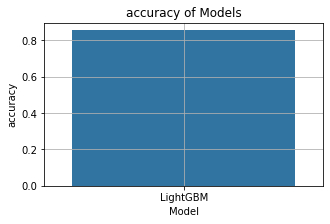

accuracy : {'LightGBM': 0.8541000000000001}
-----------


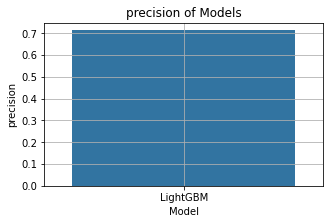

precision : {'LightGBM': 0.7116770849030345}
-----------


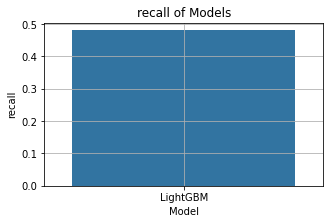

recall : {'LightGBM': 0.48041373028428974}
-----------


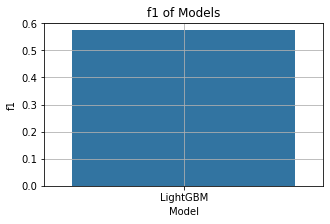

f1 : {'LightGBM': 0.5735108510979725}
-----------


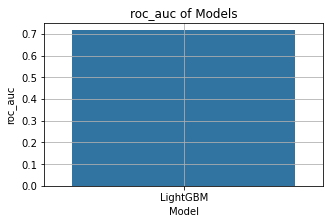

roc_auc : {'LightGBM': 0.7152007456066927}
-----------


In [243]:
for metric,name in zip([accuracy, precision, recall, f1, roc_auc],['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    plt.figure(figsize=(5,3))
    plt.title(f"{name} of Models")
    plt.xlabel("Model")
    plt.ylabel(f"{name}")
    sns.barplot(x=list(metric.keys()), y=list(metric.values()))
    plt.grid()
    plt.show()
    print(f'{name} : {metric}')
    print('-----------')

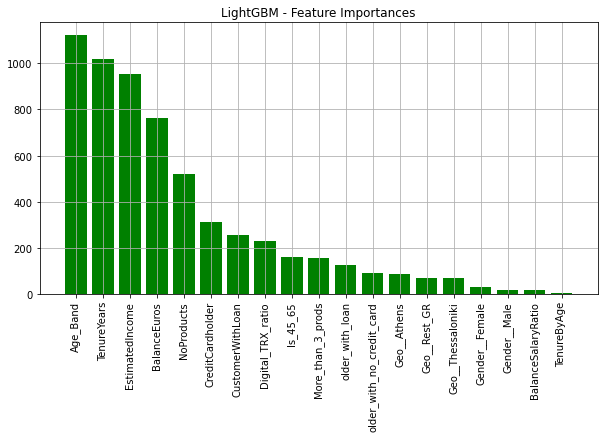

In [244]:
for model, feat_imp in feature_importances.items():
    plt.figure(figsize=(10, 5))
    plt.title(f'{model} - Feature Importances')
    plt.bar(range(len(features_label)), feat_imp.values(), color = "green", align = "center")
    plt.xticks(range(len(features_label)), feat_imp.keys(), rotation = 90)
    plt.grid()
    plt.show()

### Extra Features experimentation

In [245]:
X = df.drop(['Inactive'], axis=1)
features_label = X.columns
X = X.values
y = df['Inactive'].values

print(X.shape, y.shape)

(10000, 19) (10000,)


In [246]:
features_label

Index(['Age_Band', 'TenureYears', 'EstimatedIncome', 'BalanceEuros',
       'NoProducts', 'CreditCardholder', 'CustomerWithLoan',
       'Digital_TRX_ratio', 'Is_45_65', 'More_than_3_prods', 'older_with_loan',
       'older_with_no_credit_card', 'Geo__Athens', 'Geo__Rest_GR',
       'Geo__Thessaloniki', 'Gender__Female', 'Gender__Male',
       'BalanceSalaryRatio', 'TenureByAge'],
      dtype='object')

In [247]:
from sklearn.model_selection import StratifiedKFold

to_print_shapes = False

# Models for Classification
models = [('XGB' ,XGBClassifier(random_state=123456)),
          ('CART', DecisionTreeClassifier(random_state=123456)),
          ('RF', RandomForestClassifier(random_state=123456)),
          ('GB', GradientBoostingClassifier(random_state = 12345)),
          ("LightGBM", LGBMClassifier(random_state=123456))]

results = {}
accuracy = {}
precision = {}
recall = {}
f1 = {}
roc_auc = {}

feature_importances = {}

# enumerate the splits and summarize the distributions
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    results_per_model = []
    feature_importance_per_model = {}
    acc_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    roc_auc_per_fold = []
    for train_ix, test_ix in kfold.split(X, y):
        # select rows
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        # print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
        if to_print_shapes:
            # print the number of unique label values
            train_unique, train_counts = np.unique(train_y, return_counts=True)
            test_unique, test_counts = np.unique(test_y, return_counts=True)
            # print('Train: ', train_unique, train_counts)
            # print('Test: ', test_unique, test_counts)

        model.fit(train_X, train_y)
        results_per_model.append(model.score(test_X, test_y))

        y_pred = model.predict(test_X)

        # f-1 score, precision, recall, accuracy, roc_auc
        acc_per_fold.append(accuracy_score(test_y, y_pred))
        precision_per_fold.append(precision_score(test_y, y_pred))
        recall_per_fold.append(recall_score(test_y, y_pred))
        f1_per_fold.append(f1_score(test_y, y_pred))
        roc_auc_per_fold.append(roc_auc_score(test_y, y_pred))

        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        for i,column in zip(range(X.shape[1]), features_label):
            feature_importance_per_model[column] = importances[indices[i]]

        # print(classification_report(test_y,  model.predict(test_X)))

    # mean value of feature_importance_per_model
    feature_importance_per_model = {k: v / 5 for k, v in feature_importance_per_model.items()}
    # print(feature_importance_per_model)

    feature_importances[name] = feature_importance_per_model
    
    results[name] = results_per_model
    print('>%s %.3f (%.3f)' % (name, np.mean(results_per_model), np.std(results_per_model)))

    accuracy[name] = np.mean(acc_per_fold)
    precision[name] = np.mean(precision_per_fold)
    recall[name] = np.mean(recall_per_fold)
    f1[name] = np.mean(f1_per_fold)
    roc_auc[name] = np.mean(roc_auc_per_fold)
    print('>%s %.3f (%.3f)' % (name, np.mean(acc_per_fold), np.std(acc_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(precision_per_fold), np.std(precision_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(recall_per_fold), np.std(recall_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(f1_per_fold), np.std(f1_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(roc_auc_per_fold), np.std(roc_auc_per_fold)))

>XGB 0.849 (0.006)
>XGB 0.849 (0.006)
>XGB 0.692 (0.024)
>XGB 0.474 (0.013)
>XGB 0.563 (0.016)
>XGB 0.710 (0.008)
>CART 0.784 (0.008)
>CART 0.784 (0.008)
>CART 0.473 (0.018)
>CART 0.484 (0.013)
>CART 0.478 (0.015)
>CART 0.673 (0.009)
>RF 0.850 (0.005)
>RF 0.850 (0.005)
>RF 0.717 (0.029)
>RF 0.439 (0.013)
>RF 0.544 (0.011)
>RF 0.697 (0.006)
>GB 0.858 (0.006)
>GB 0.858 (0.006)
>GB 0.766 (0.029)
>GB 0.441 (0.017)
>GB 0.559 (0.018)
>GB 0.703 (0.009)
>LightGBM 0.853 (0.005)
>LightGBM 0.853 (0.005)
>LightGBM 0.718 (0.026)
>LightGBM 0.463 (0.016)
>LightGBM 0.562 (0.013)
>LightGBM 0.708 (0.007)


In [248]:
results

{'XGB': [0.8385, 0.85, 0.853, 0.856, 0.85],
 'CART': [0.7705, 0.782, 0.79, 0.7855, 0.793],
 'RF': [0.8415, 0.8475, 0.8525, 0.852, 0.855],
 'GB': [0.849, 0.8645, 0.86, 0.855, 0.8625],
 'LightGBM': [0.844, 0.852, 0.856, 0.8575, 0.8555]}

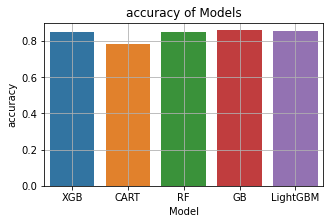

accuracy : {'XGB': 0.8494999999999999, 'CART': 0.7842, 'RF': 0.8497, 'GB': 0.8582000000000001, 'LightGBM': 0.853}
-----------


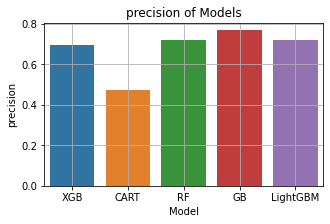

precision : {'XGB': 0.6922706961498621, 'CART': 0.4726311727635257, 'RF': 0.716569547031502, 'GB': 0.7659551451374007, 'LightGBM': 0.7181397431704015}
-----------


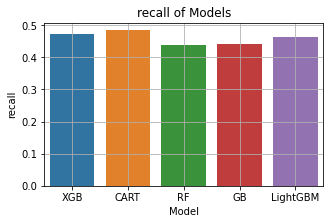

recall : {'XGB': 0.47403279160074785, 'CART': 0.483834316122537, 'RF': 0.4387914089841315, 'GB': 0.4407462006807613, 'LightGBM': 0.462788244882305}
-----------


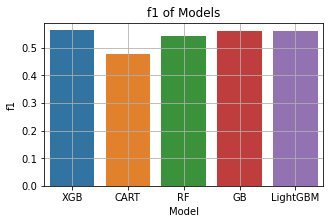

f1 : {'XGB': 0.5626508507639582, 'CART': 0.4780797719820008, 'RF': 0.5438520536440417, 'GB': 0.5592833314135455, 'LightGBM': 0.562456453036997}
-----------


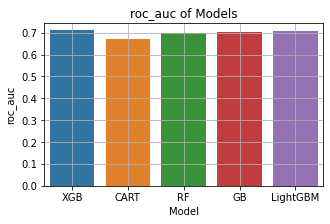

roc_auc : {'XGB': 0.7099368986919531, 'CART': 0.6725536450215255, 'RF': 0.6969662647098738, 'GB': 0.7030322319506633, 'LightGBM': 0.7079593811672152}
-----------


In [249]:
# barplot for accuracy
for metric,name in zip([accuracy, precision, recall, f1, roc_auc],['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    plt.figure(figsize=(5,3))
    plt.title(f"{name} of Models")
    plt.xlabel("Model")
    plt.ylabel(f"{name}")
    sns.barplot(x=list(metric.keys()), y=list(metric.values()))
    plt.grid()
    plt.show()
    print(f'{name} : {metric}')
    print('-----------')

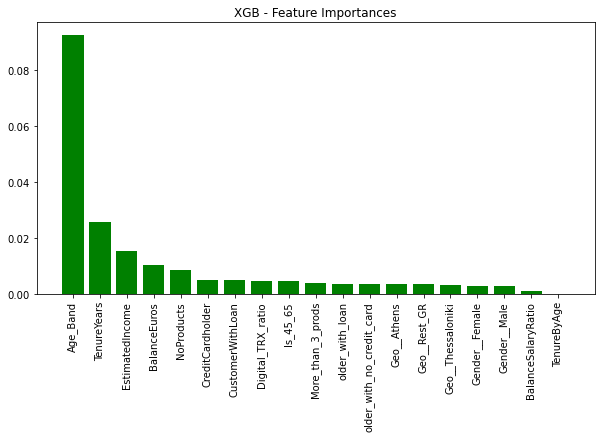

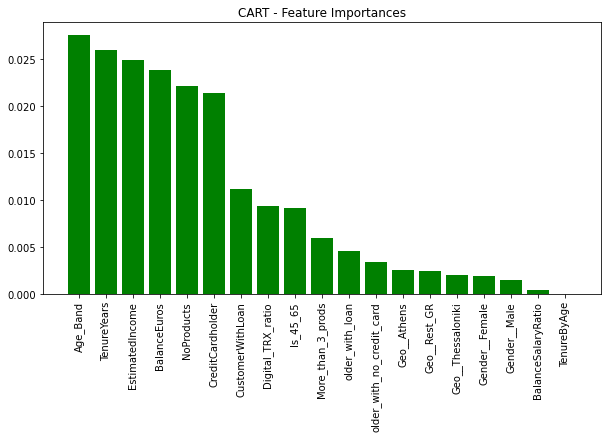

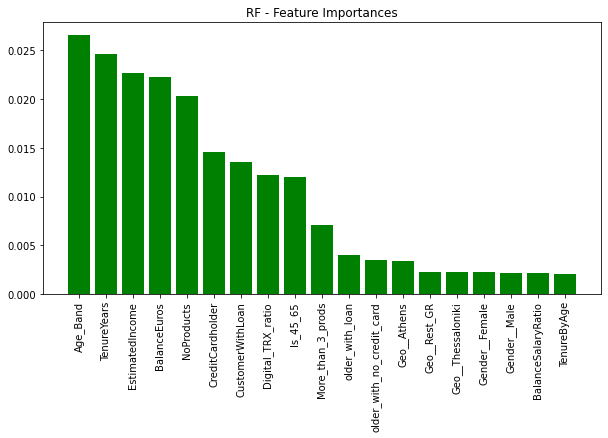

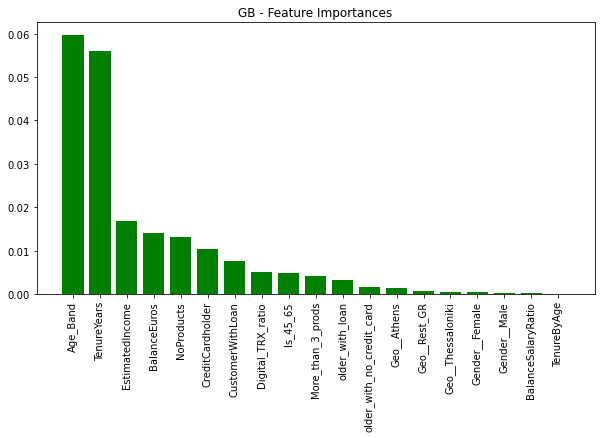

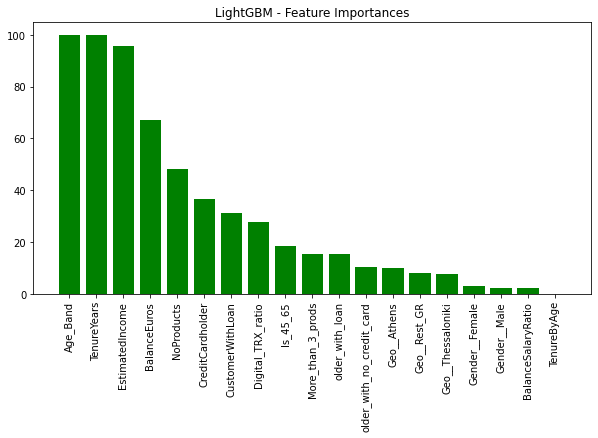

In [250]:
for model, feat_imp in feature_importances.items():
    plt.figure(figsize=(10, 5))
    plt.title(f'{model} - Feature Importances')
    plt.bar(range(len(features_label)), feat_imp.values(), color = "green", align = "center")
    plt.xticks(range(len(features_label)), feat_imp.keys(), rotation = 90)
    plt.show()

In [251]:
# mean and standard deviation of the results
for name, values in results.items():
    print('>%s %.3f (%.3f)' % (name, np.mean(values), np.std(values)))

>XGB 0.849 (0.006)
>CART 0.784 (0.008)
>RF 0.850 (0.005)
>GB 0.858 (0.006)
>LightGBM 0.853 (0.005)


In [252]:
results

{'XGB': [0.8385, 0.85, 0.853, 0.856, 0.85],
 'CART': [0.7705, 0.782, 0.79, 0.7855, 0.793],
 'RF': [0.8415, 0.8475, 0.8525, 0.852, 0.855],
 'GB': [0.849, 0.8645, 0.86, 0.855, 0.8625],
 'LightGBM': [0.844, 0.852, 0.856, 0.8575, 0.8555]}

## Experiment with SMOTE - Teckle imblanace dataset

In [263]:
X = df.drop(['Inactive'], axis=1)
features_label = X.columns
X = X.values
y = df['Inactive'].values

print(X.shape, y.shape)

(10000, 19) (10000,)


In [264]:
# import smote oversampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# define oversampling strategy - oversample minority class to have 20% of majority class and leave majority class as is
# oversample = SMOTE(sampling_strategy='not majority', random_state=123456)
undersampler = RandomUnderSampler(sampling_strategy=0.8)

# fit and apply the transform
X, y = undersampler.fit_resample(X, y)

print(X.shape, y.shape)

(4594, 19) (4594,)


In [265]:
undersampler.sampling_strategy_

OrderedDict([(0, 2552)])

Class=0, n=2552 (55.551%)
Class=1, n=2042 (44.449%)


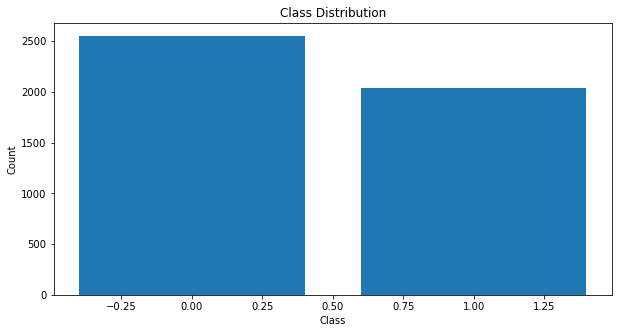

In [267]:
from collections import Counter
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# plot the distribution
plt.figure(figsize=(10, 5))
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.bar(counter.keys(), counter.values())
plt.show()


(3675, 19) (919, 19) (3675,) (919,)
[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


<Figure size 432x288 with 0 Axes>

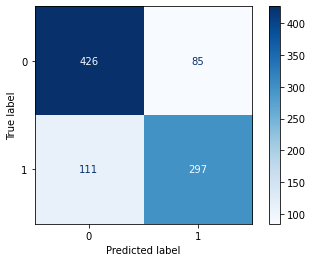

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


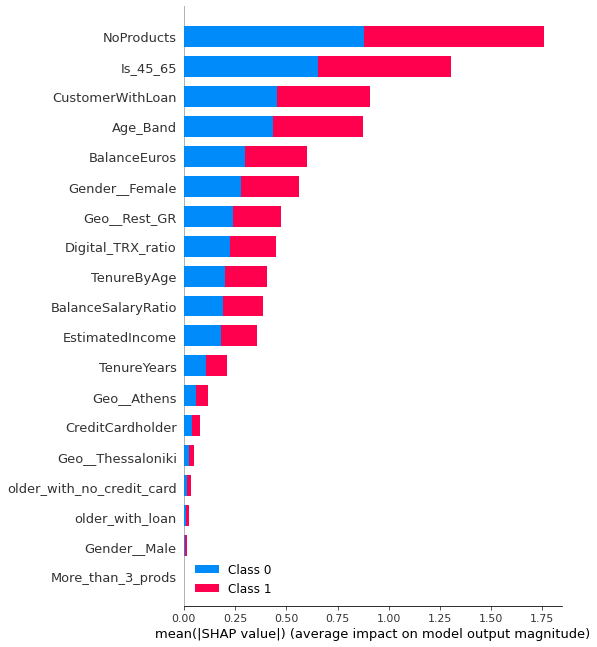

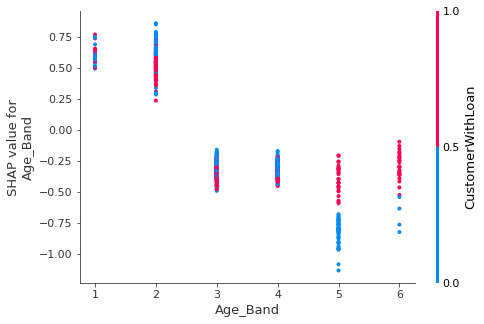

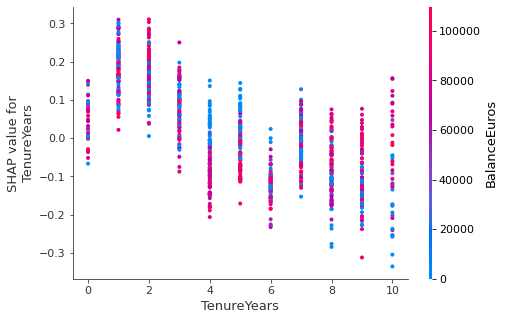

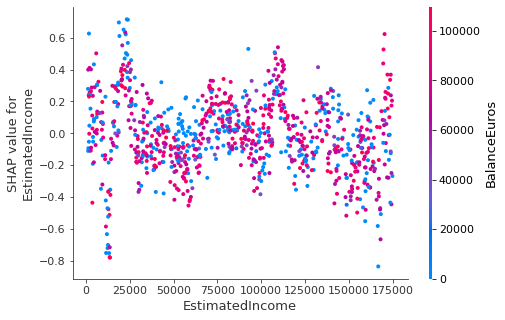

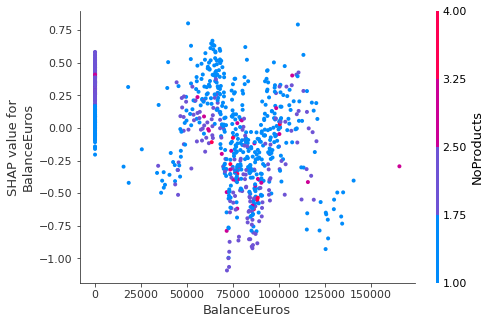

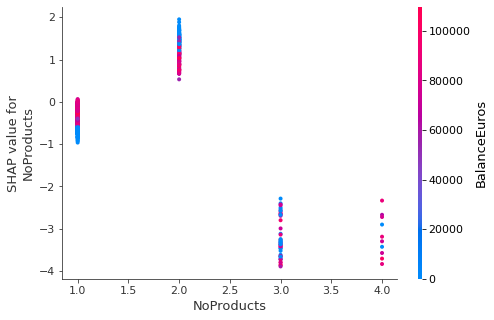

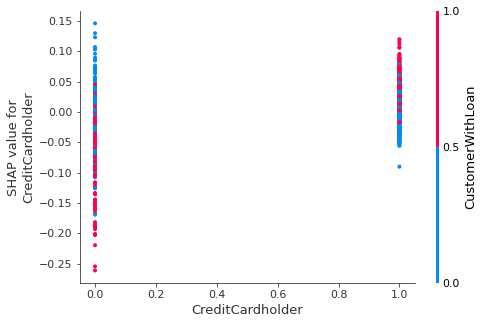

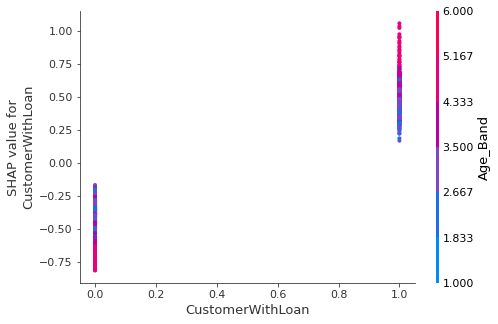

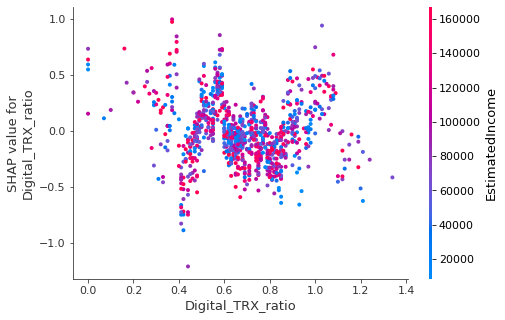

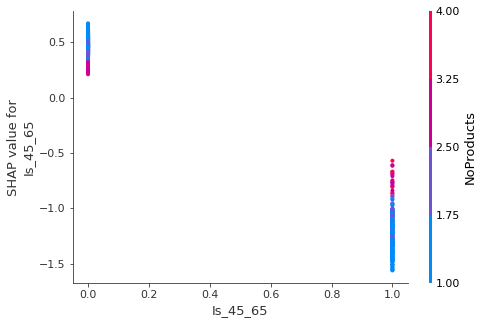

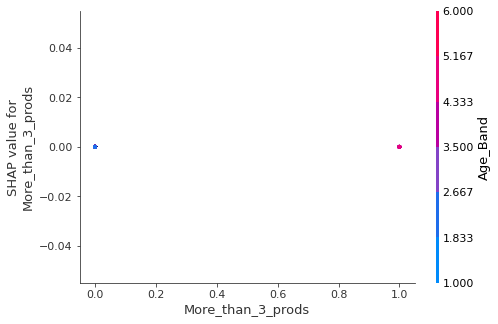

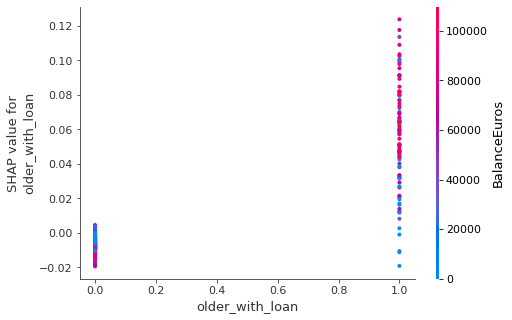

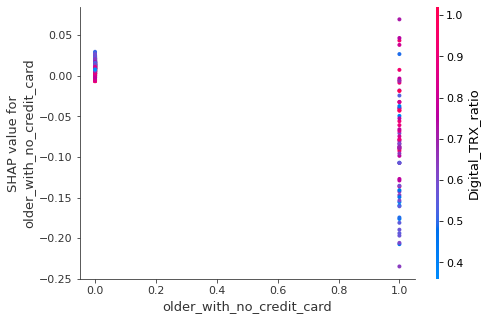

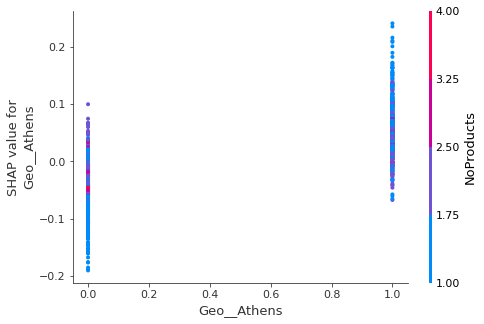

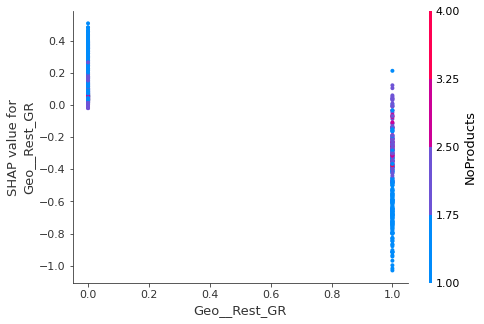

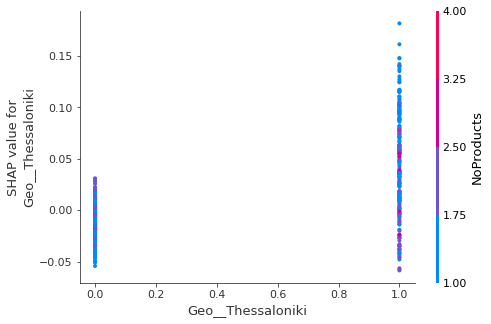

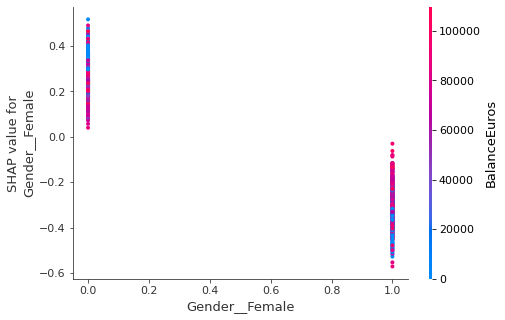

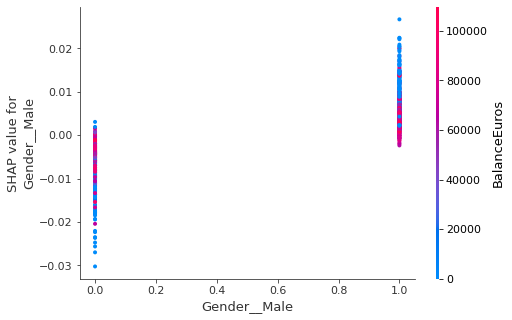

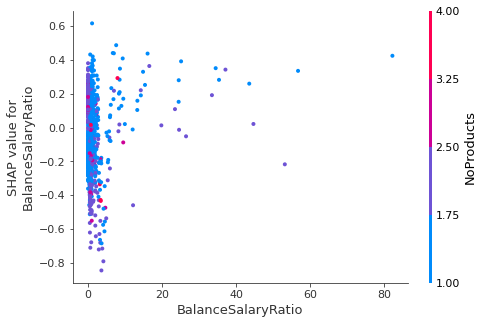

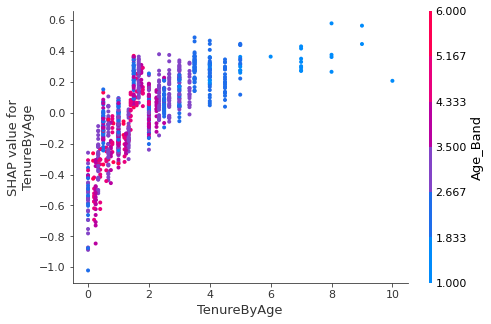

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       511
           1       0.78      0.73      0.75       408

    accuracy                           0.79       919
   macro avg       0.79      0.78      0.78       919
weighted avg       0.79      0.79      0.79       919

(3675, 19) (919, 19) (3675,) (919,)
[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


<Figure size 432x288 with 0 Axes>

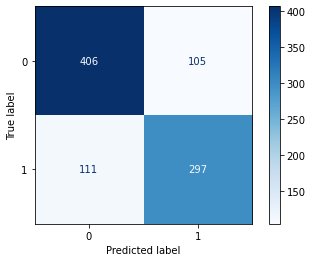

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


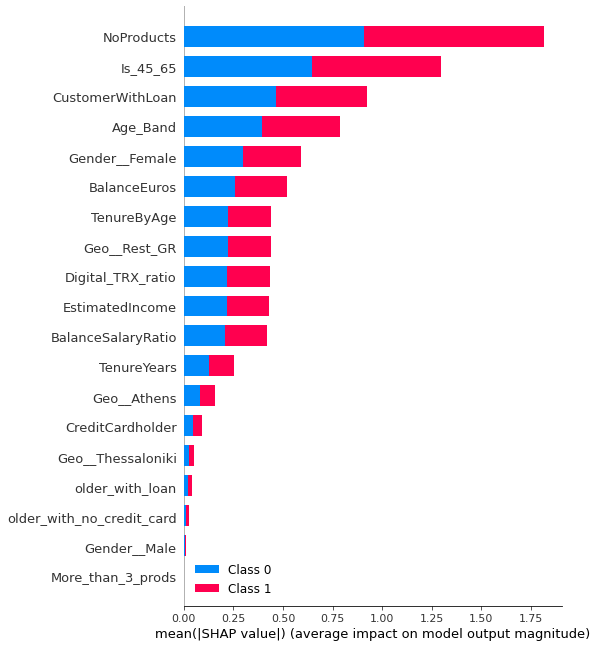

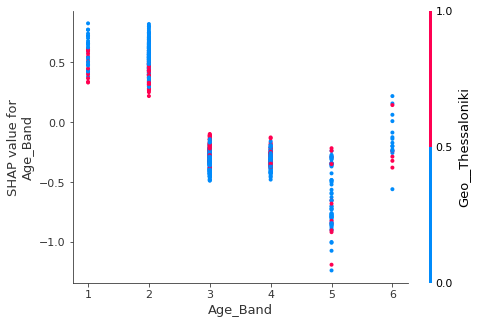

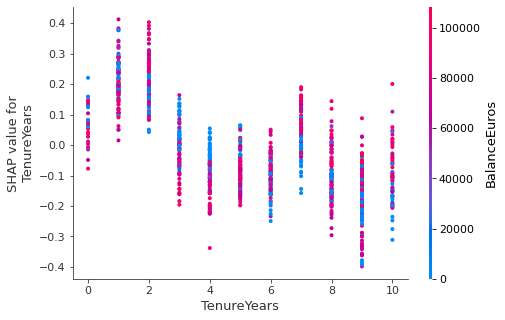

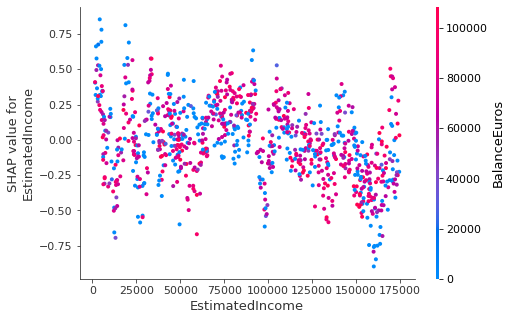

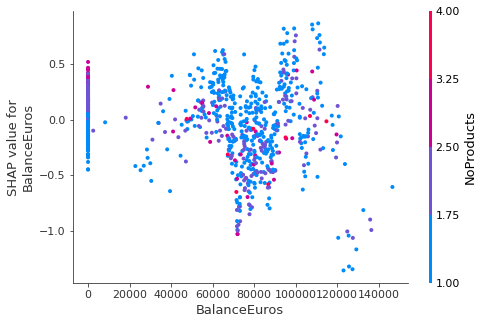

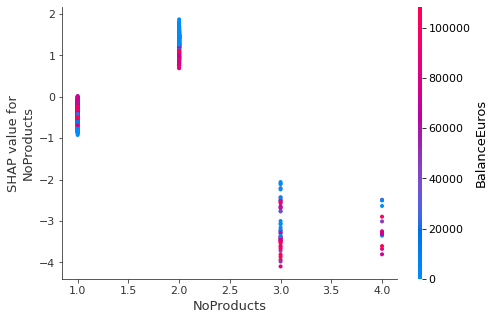

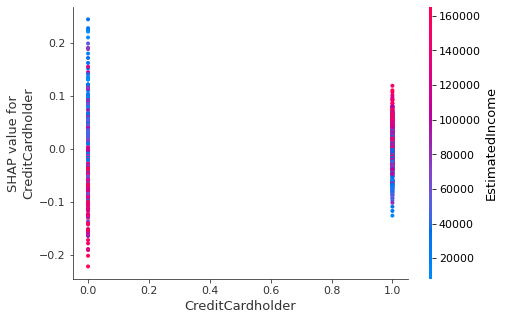

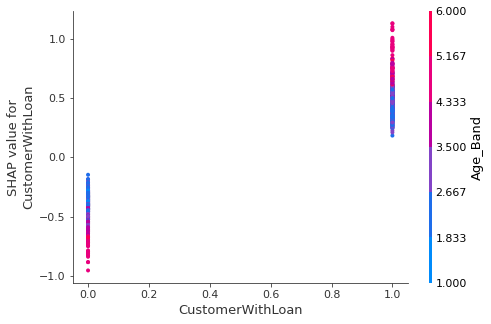

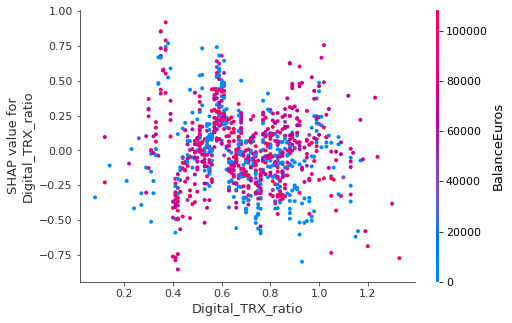

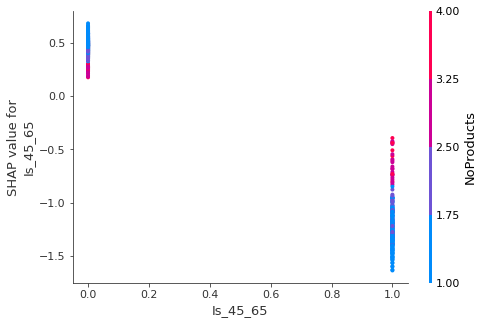

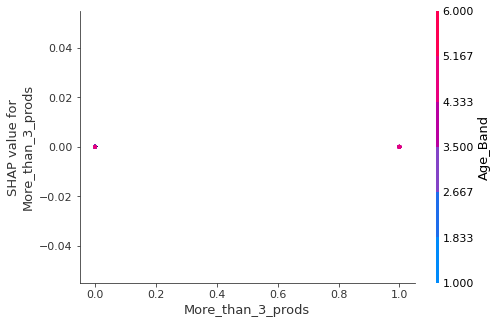

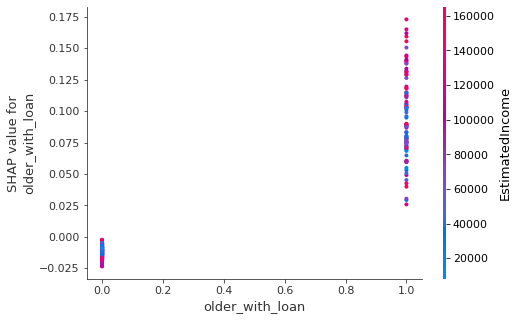

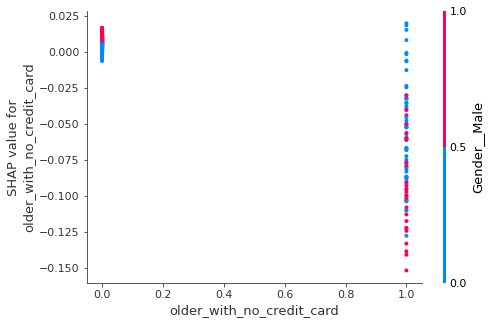

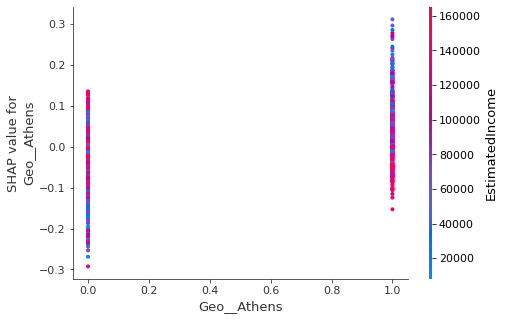

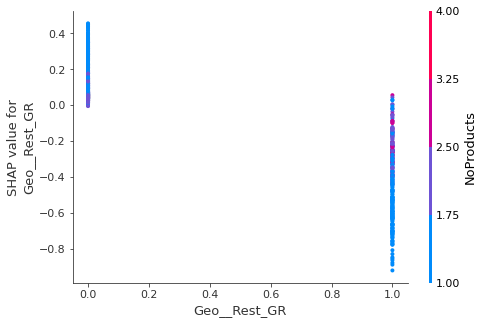

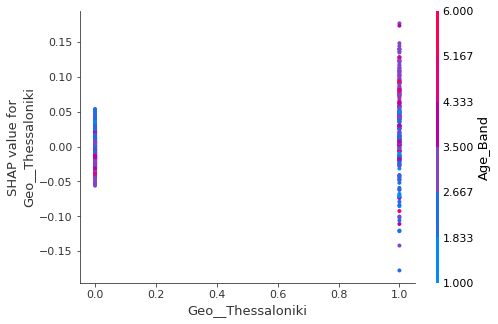

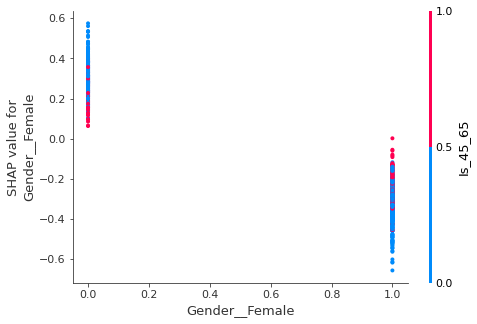

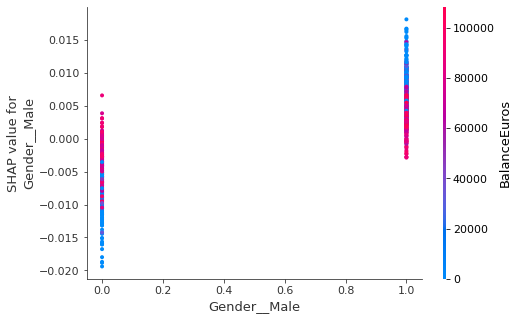

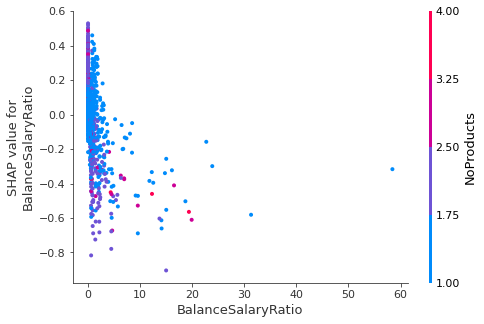

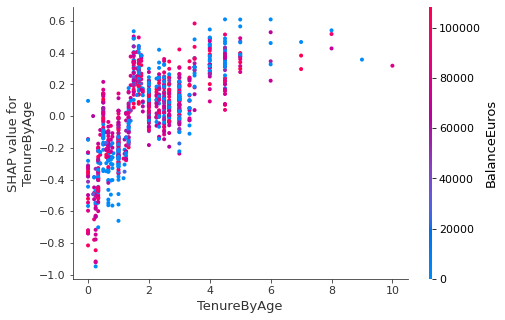

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       511
           1       0.74      0.73      0.73       408

    accuracy                           0.76       919
   macro avg       0.76      0.76      0.76       919
weighted avg       0.76      0.76      0.76       919

(3675, 19) (919, 19) (3675,) (919,)
[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


<Figure size 432x288 with 0 Axes>

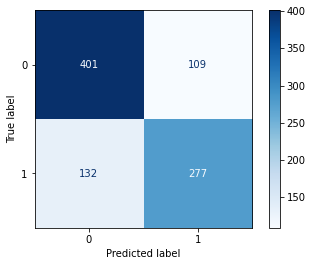

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


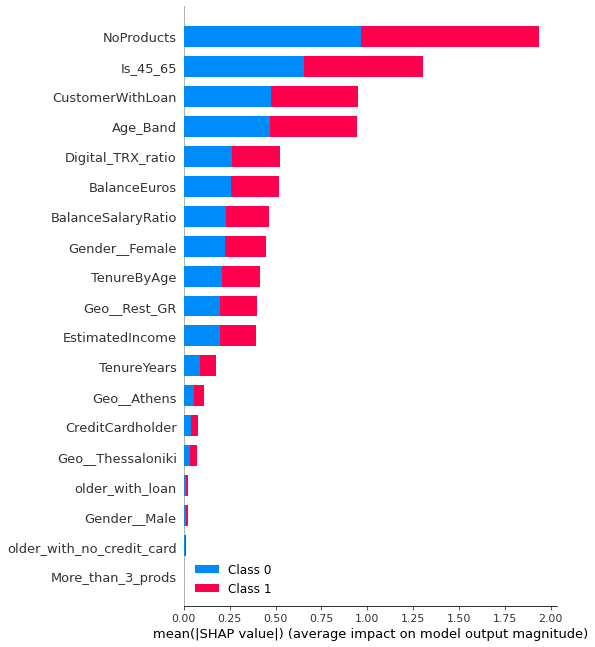

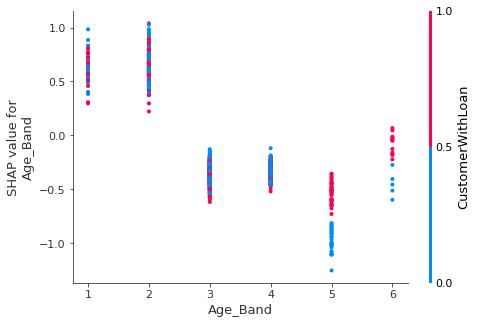

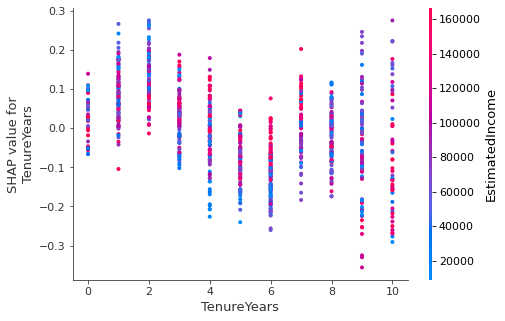

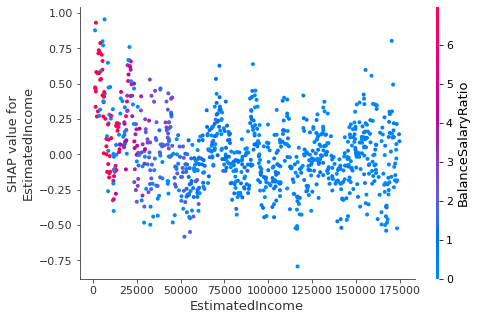

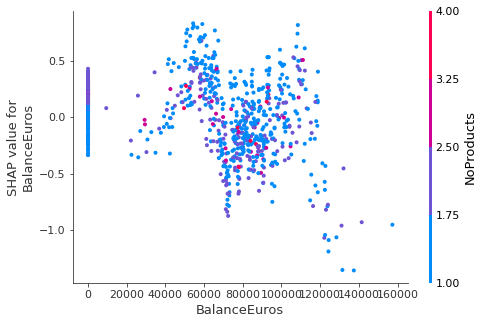

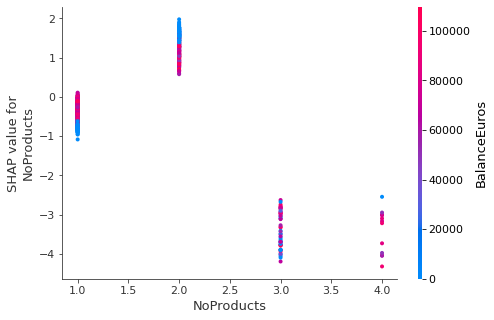

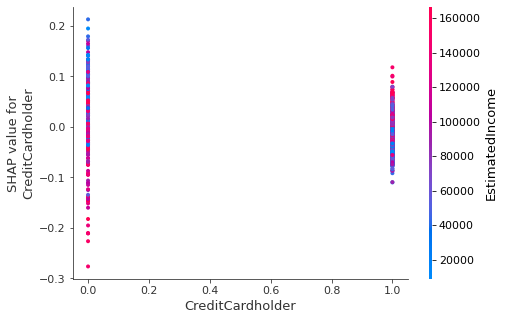

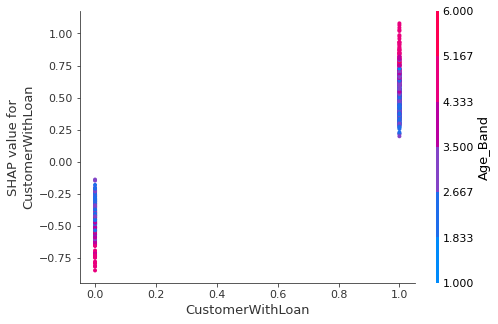

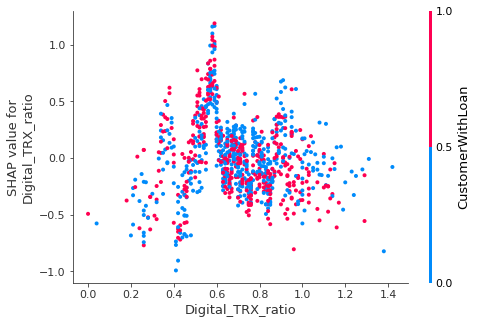

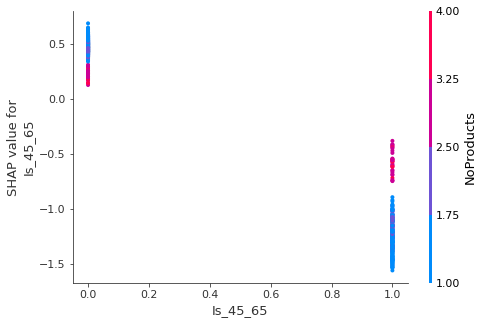

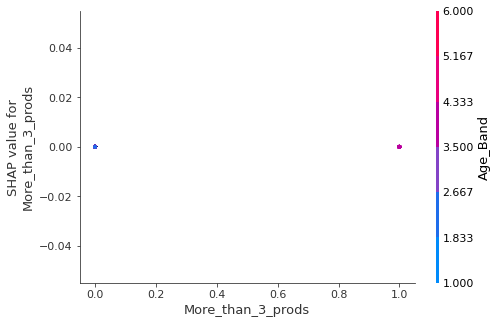

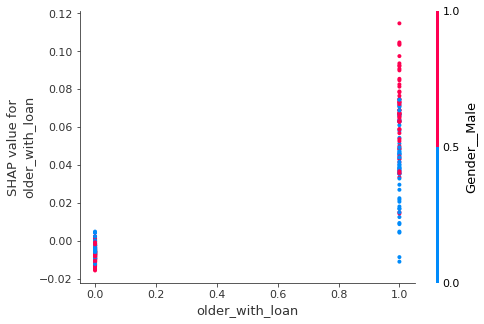

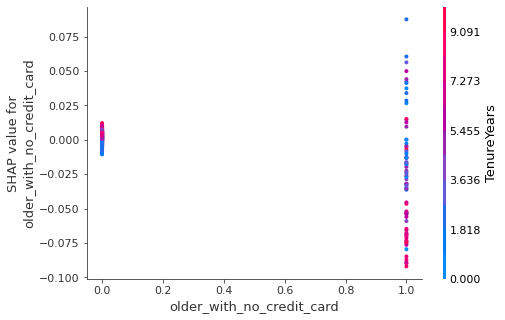

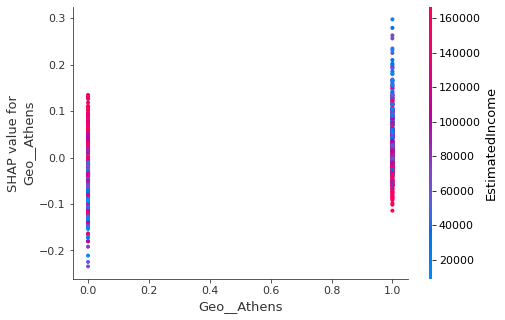

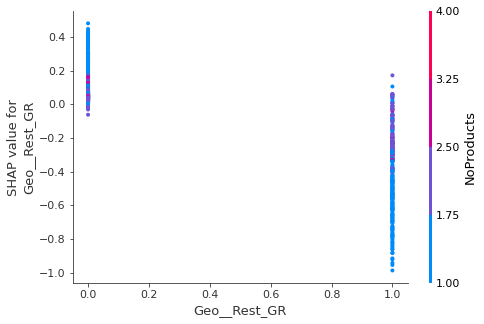

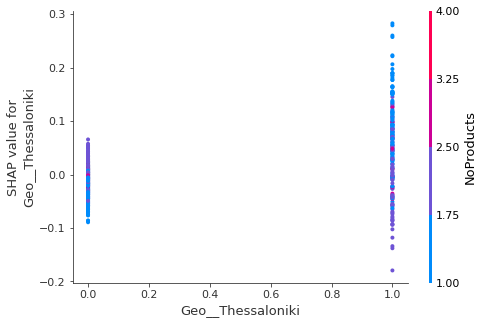

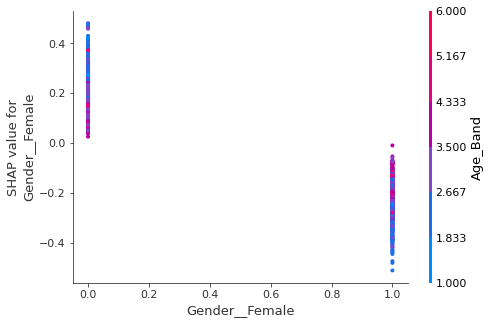

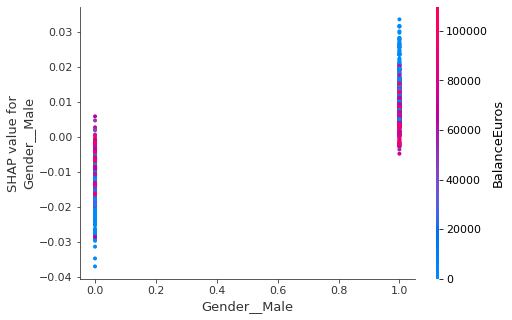

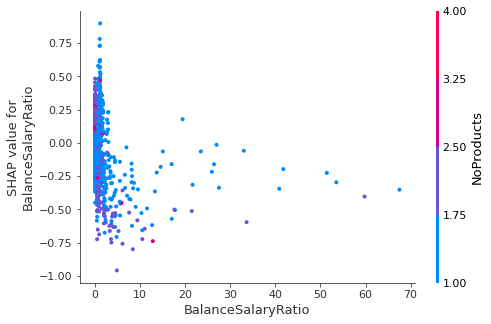

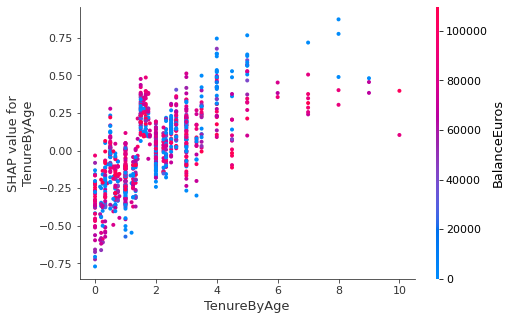

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       510
           1       0.72      0.68      0.70       409

    accuracy                           0.74       919
   macro avg       0.73      0.73      0.73       919
weighted avg       0.74      0.74      0.74       919

(3675, 19) (919, 19) (3675,) (919,)
[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


<Figure size 432x288 with 0 Axes>

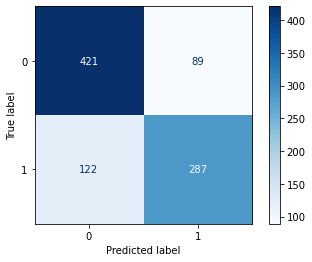

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


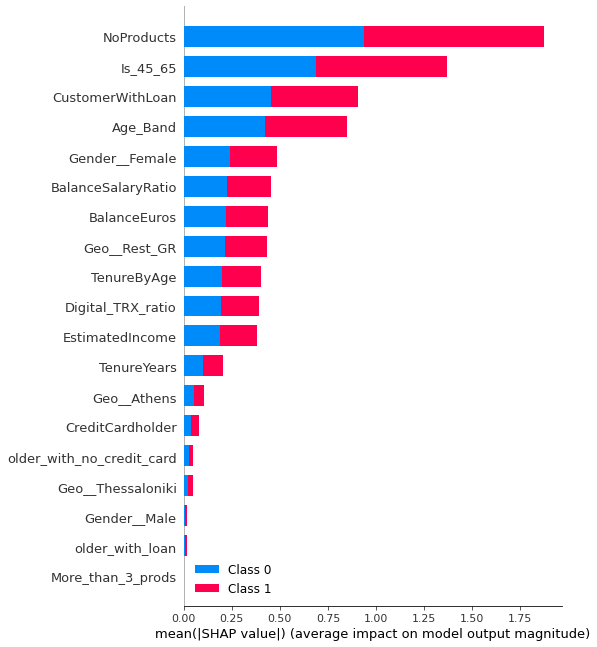

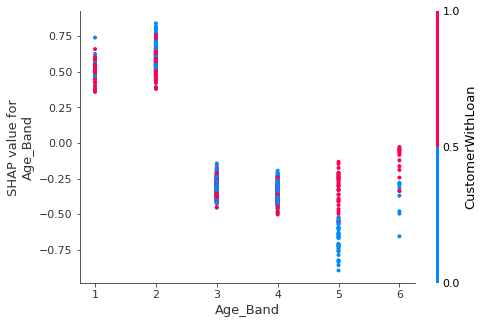

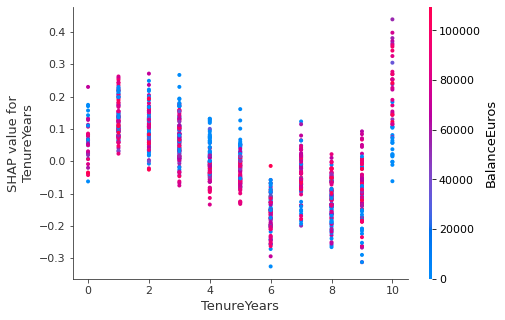

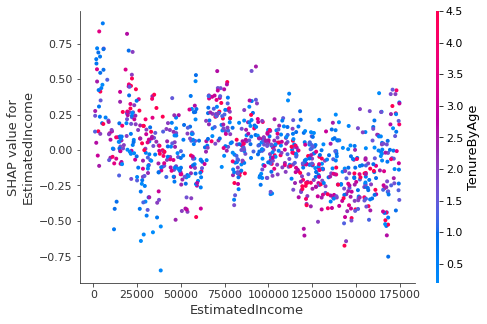

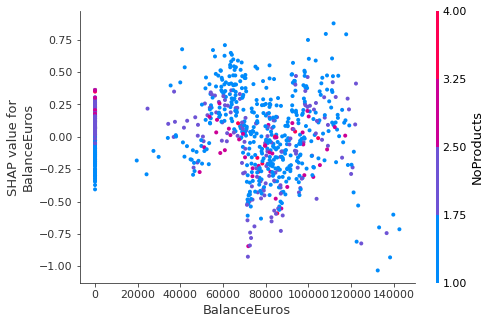

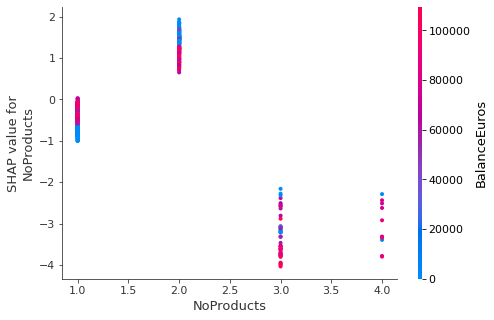

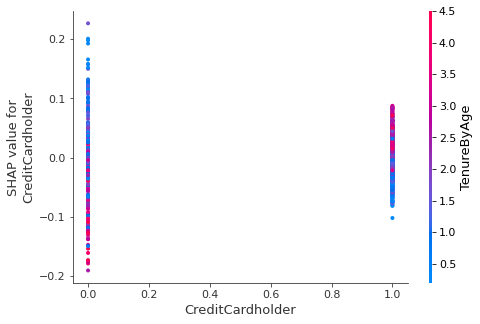

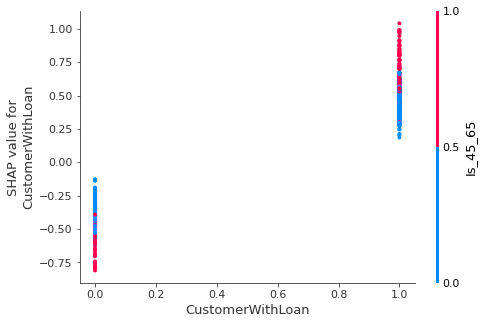

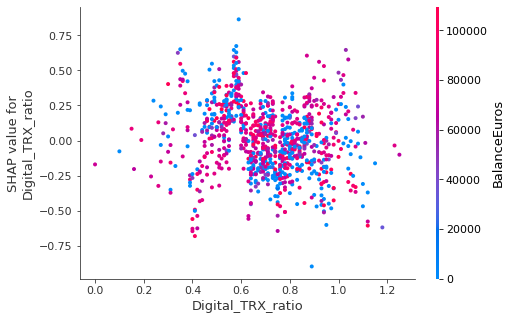

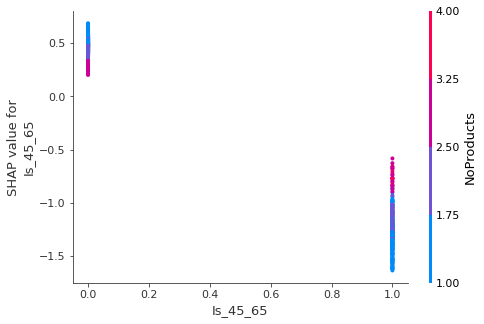

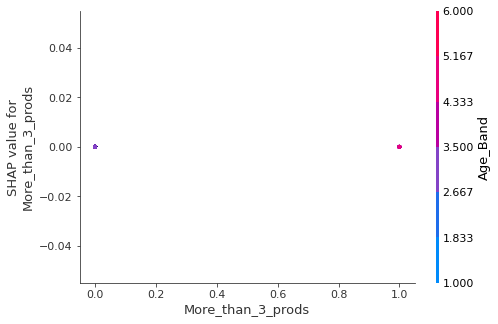

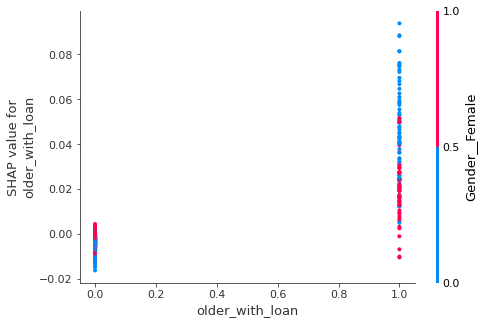

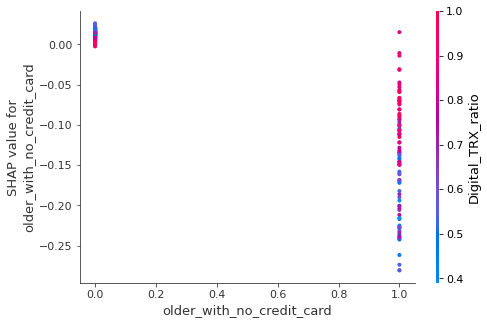

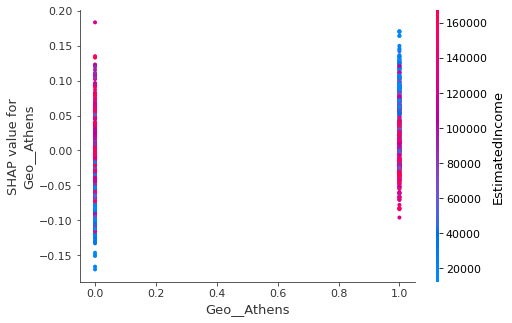

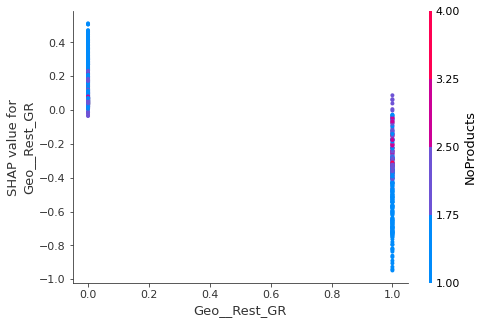

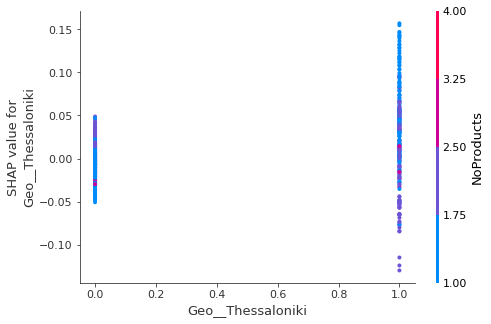

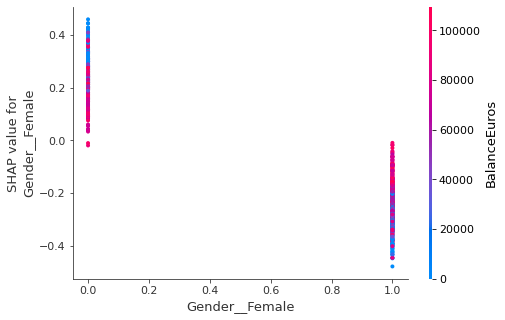

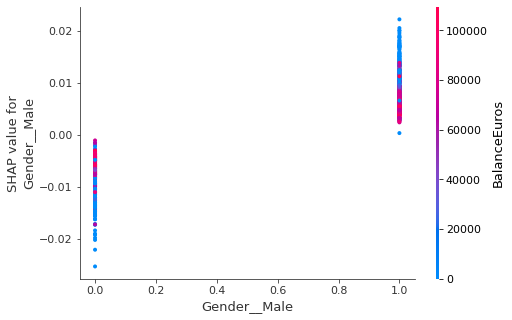

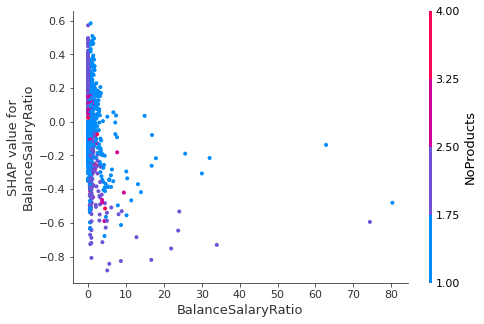

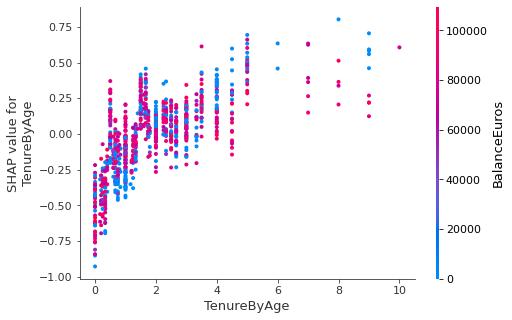

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       510
           1       0.76      0.70      0.73       409

    accuracy                           0.77       919
   macro avg       0.77      0.76      0.77       919
weighted avg       0.77      0.77      0.77       919

(3676, 19) (918, 19) (3676,) (918,)
[LightGBM] [Warning] bagging_fraction is set=0.683304123698687, subsample=0.9249682718298411 will be ignored. Current value: bagging_fraction=0.683304123698687
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0.7580854915970148 will be ignored. Current value: bagging_freq=1


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


<Figure size 432x288 with 0 Axes>

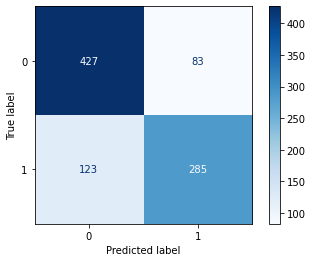

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


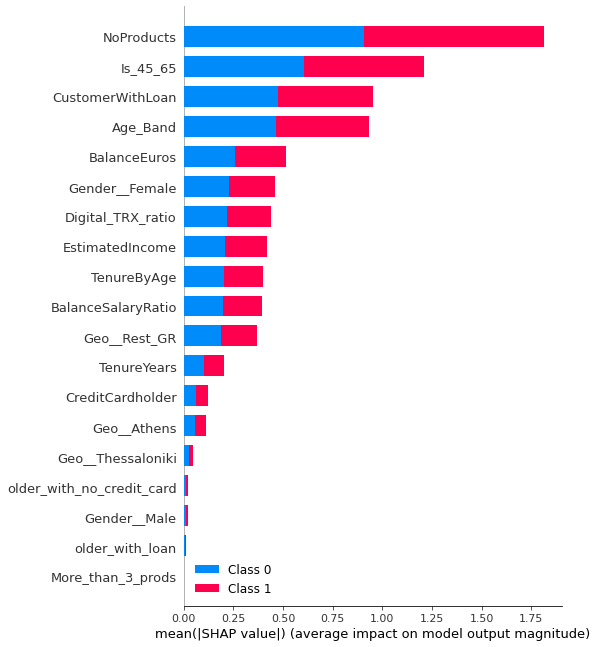

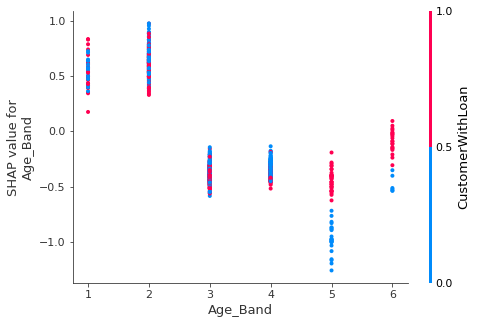

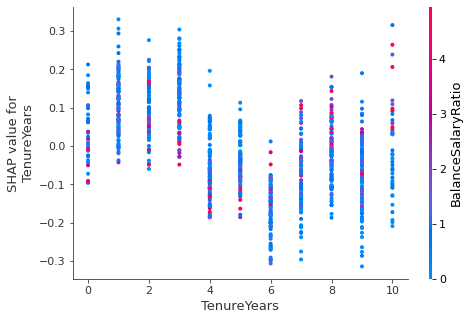

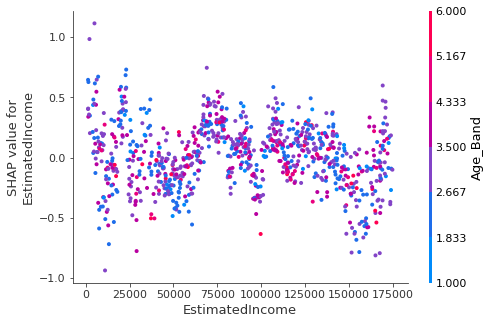

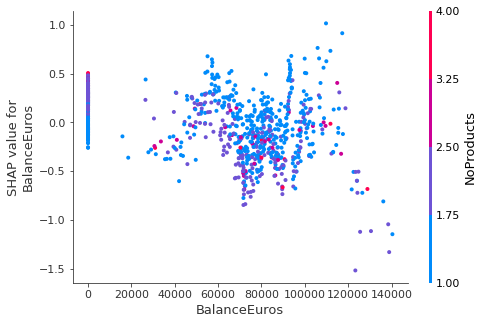

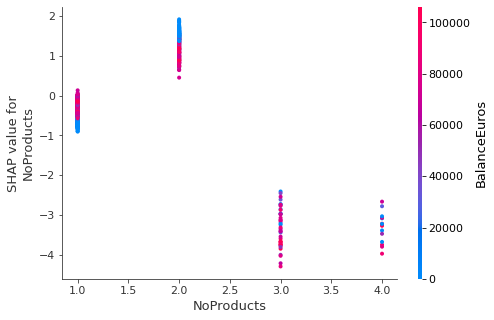

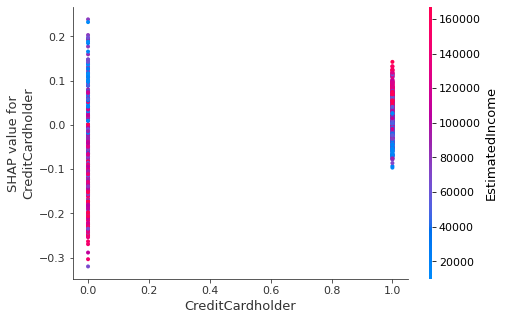

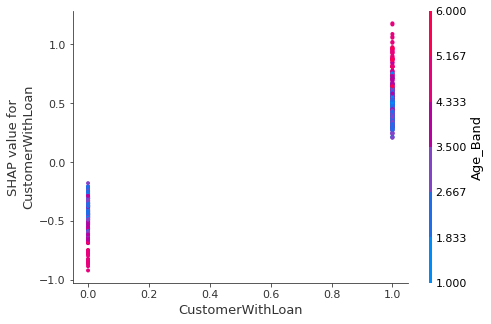

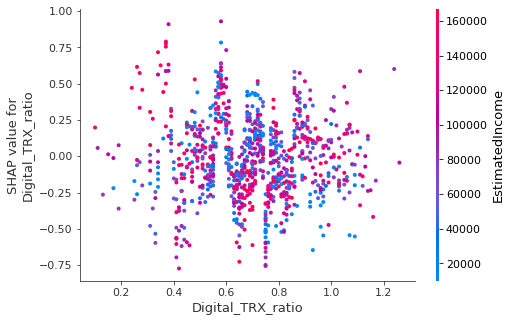

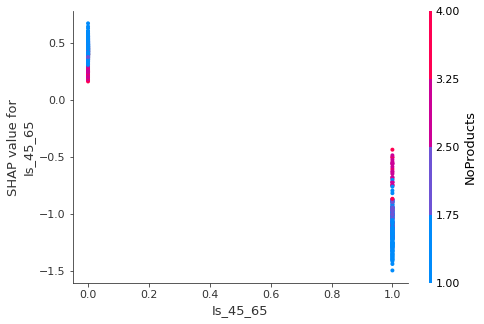

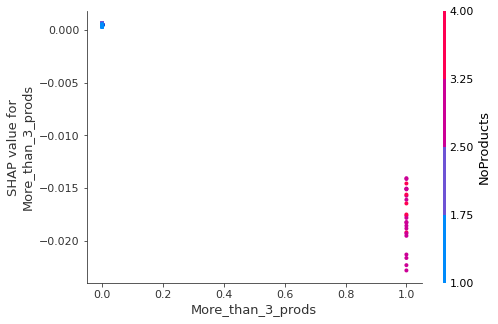

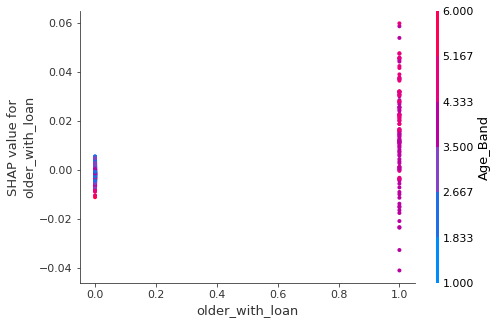

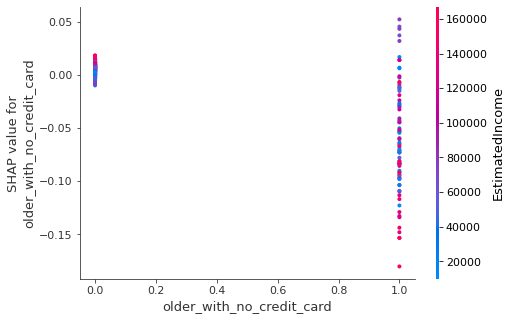

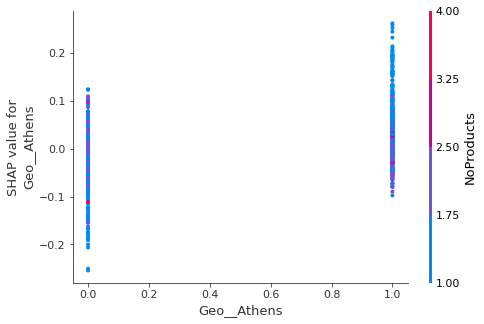

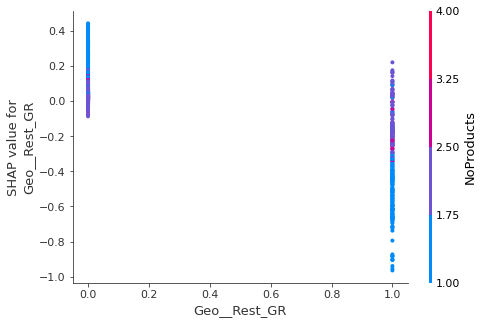

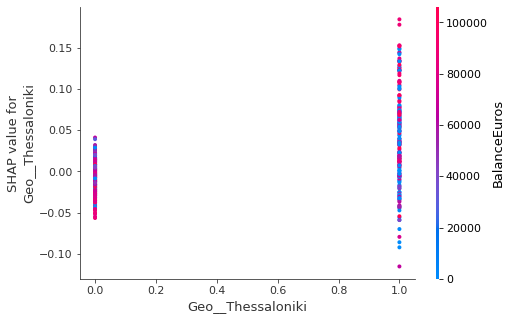

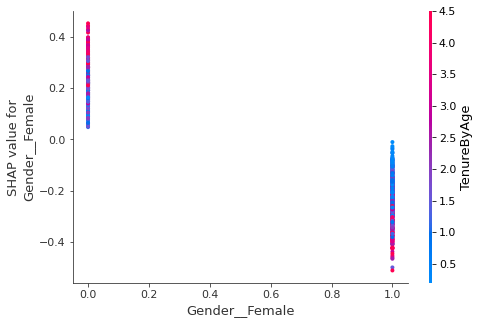

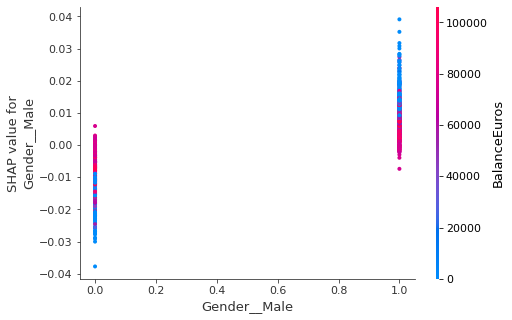

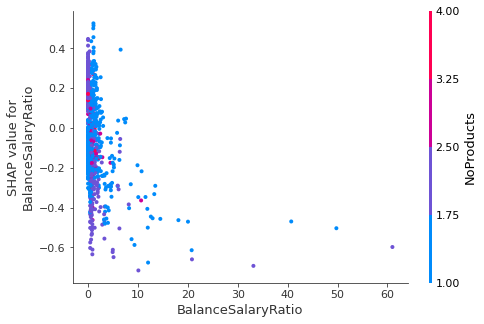

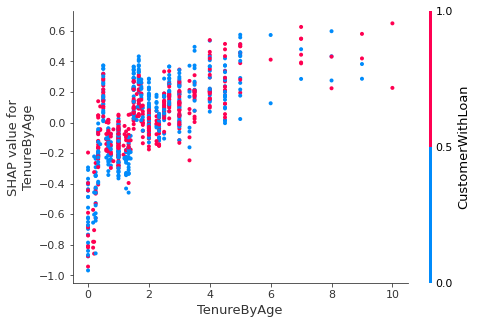

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       510
           1       0.77      0.70      0.73       408

    accuracy                           0.78       918
   macro avg       0.78      0.77      0.77       918
weighted avg       0.78      0.78      0.77       918

>LightGBM 0.767 (0.016)
>LightGBM 0.767 (0.016)
>LightGBM 0.754 (0.023)
>LightGBM 0.707 (0.019)
>LightGBM 0.730 (0.018)
>LightGBM 0.761 (0.016)


In [268]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix
import sklearn

import shap

lgbm_params = {
    'objective': 'binary',
    'metric': 'auc', 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'random_state': 42,
    'learning_rate': 0.014,
    'subsample': 0.9249682718298411,
    'subsample_freq': 0.7580854915970148,
    'colsample_bytree': 0.9768551421448343,
    'reg_alpha': 0.0029587956244222367,
    'reg_lambda': 0.21206304009356328,
    'min_child_weight': 5,
    'min_child_samples': 50,
    'bagging_fraction': 0.683304123698687,
    'bagging_freq': 1,
    'random_state':123456
}

to_print_shapes = False

# Models for Classification
models = [("LightGBM", LGBMClassifier(**lgbm_params))]

results = {}
accuracy = {}
precision = {}
recall = {}
f1 = {}
roc_auc = {}

roc_curve_per_model = {}

feature_importances = {}

# enumerate the splits and summarize the distributions
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    results_per_model = []
    feature_importance_per_model = {}
    acc_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    roc_auc_per_fold = []
    true_positive_rate_per_fold = []
    false_positive_rate_per_fold = []
    classification_report_per_fold = []
    for train_ix, test_ix in kfold.split(X, y):
        # select rows
        train_X, test_X = X[train_ix], X[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
        if to_print_shapes:
            # print the number of unique label values
            train_unique, train_counts = np.unique(train_y, return_counts=True)
            test_unique, test_counts = np.unique(test_y, return_counts=True)
            print('Train: ', train_unique, train_counts)
            print('Test: ', test_unique, test_counts)

        model.fit(train_X, train_y)
        results_per_model.append(model.score(test_X, test_y))

        y_pred = model.predict(test_X)

        # f-1 score, precision, recall, accuracy, roc_auc
        acc_per_fold.append(accuracy_score(test_y, y_pred))
        precision_per_fold.append(precision_score(test_y, y_pred))
        recall_per_fold.append(recall_score(test_y, y_pred))
        f1_per_fold.append(f1_score(test_y, y_pred))
        roc_auc_per_fold.append(roc_auc_score(test_y, y_pred))
        
        fpr1, tpr1, _ = sklearn.metrics.roc_curve(test_y, y_pred)
        true_positive_rate_per_fold.append(tpr1)
        false_positive_rate_per_fold.append(fpr1)

        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        for i,column in zip(range(X.shape[1]), features_label):
            feature_importance_per_model[column] = importances[indices[i]]

        # plot classification matrix for each fold
        plt.figure()
        plot_confusion_matrix(model, test_X, test_y, cmap=plt.cm.Blues)
        plt.show()

        # explain the model's predictions using SHAP
        X_test = pd.DataFrame(test_X, columns=features_label)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test)

        for name_ in X_test.columns:
            shap.dependence_plot(name_, shap_values[0], X_test)

        # # plot roc curve for each fold
        # plt.figure()
        # plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(test_y, y_pred))
        # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # plt.title(f'ROC Curve - {name}')
        # plt.legend(loc="lower right")
        # plt.show()

        # append classification report for each fold
        print(classification_report(test_y, y_pred))
        classification_report_per_fold.append(classification_report(test_y,  y_pred))

    # mean value of feature_importance_per_model
    feature_importance_per_model = {k: v / 5 for k, v in feature_importance_per_model.items()}
    # print(feature_importance_per_model)
    # mean value of true_positive_rate_per_fold and false_positive_rate_per_fold
    true_positive_rate_per_fold = np.mean(true_positive_rate_per_fold, axis=0)
    false_positive_rate_per_fold = np.mean(false_positive_rate_per_fold, axis=0)
    #
    roc_curve_per_model[name] = [true_positive_rate_per_fold, false_positive_rate_per_fold]

    feature_importances[name] = feature_importance_per_model
    
    results[name] = results_per_model
    print('>%s %.3f (%.3f)' % (name, np.mean(results_per_model), np.std(results_per_model)))

    accuracy[name] = np.mean(acc_per_fold)
    precision[name] = np.mean(precision_per_fold)
    recall[name] = np.mean(recall_per_fold)
    f1[name] = np.mean(f1_per_fold)
    roc_auc[name] = np.mean(roc_auc_per_fold)
    print('>%s %.3f (%.3f)' % (name, np.mean(acc_per_fold), np.std(acc_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(precision_per_fold), np.std(precision_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(recall_per_fold), np.std(recall_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(f1_per_fold), np.std(f1_per_fold)))
    print('>%s %.3f (%.3f)' % (name, np.mean(roc_auc_per_fold), np.std(roc_auc_per_fold)))

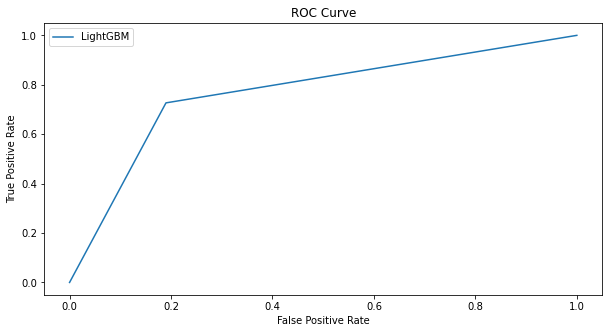

In [258]:
# roc curve for each model in the same plot
plt.figure(figsize=(10, 5))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
for name, model in models:
    plt.plot(roc_curve_per_model[name][1], roc_curve_per_model[name][0], label=name)
plt.legend()

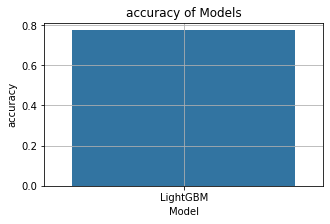

accuracy : {'LightGBM': 0.772966258199568}
-----------


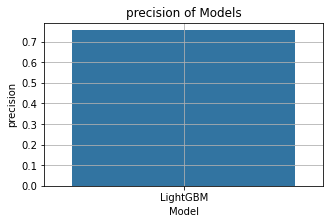

precision : {'LightGBM': 0.7542055276815552}
-----------


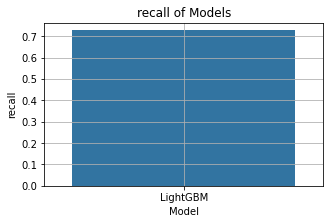

recall : {'LightGBM': 0.7267510427153747}
-----------


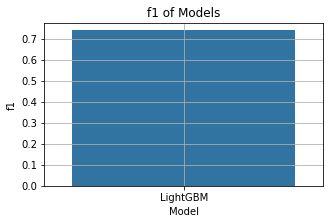

f1 : {'LightGBM': 0.7401094498410874}
-----------


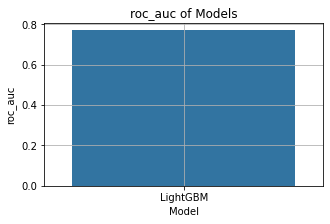

roc_auc : {'LightGBM': 0.7683446322897314}
-----------


In [259]:
# barplot for accuracy
for metric,name in zip([accuracy, precision, recall, f1, roc_auc],['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    plt.figure(figsize=(5,3))
    plt.title(f"{name} of Models")
    plt.xlabel("Model")
    plt.ylabel(f"{name}")
    sns.barplot(x=list(metric.keys()), y=list(metric.values()))
    plt.grid()
    plt.show()
    print(f'{name} : {metric}')
    print('-----------')

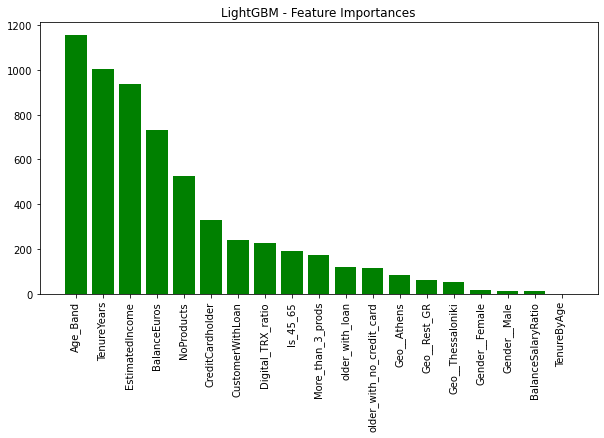

In [260]:
for model, feat_imp in feature_importances.items():
    plt.figure(figsize=(10, 5))
    plt.title(f'{model} - Feature Importances')
    plt.bar(range(len(features_label)), feat_imp.values(), color = "green", align = "center")
    plt.xticks(range(len(features_label)), feat_imp.keys(), rotation = 90)
    plt.show()

In [261]:
roc_auc

{'LightGBM': 0.7683446322897314}

In [262]:
f1

{'LightGBM': 0.7401094498410874}